In [618]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from solver_1d import false_transient_one_iteration_python
import global_parameters as gp
from supportfunctions import PDESolver_2d, finiteDiff
import matplotlib.pyplot as plt
from numba import njit,jit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode
import plotly.graph_objects as go
from scipy import interpolate
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Smooth Ambiguity
Base line model, no ambiguity:
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & - \delta \phi(y) + \delta\eta \log\tilde e \\
&  + \frac{\xi_m}{2} h'h + \frac{d\phi(y)}{dy} \tilde e (\theta + \sigma_y h) + \frac{1}{2}\frac{d^2\phi(y)}{dy^2}|\sigma_y|^2(\tilde e)^2\\
                           & + (\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot (\theta + \sigma_y h)
\end{aligned}
$$

In [619]:
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ/3
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
ȳ= 2
ξₘ = 0.002
ξₐ = 1/10_000
years = np.linspace(0,100)

In [567]:
# y grid
n_y = 200
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, n_y)
dy = y_grid[1] - y_grid[0]

In [568]:
# no ambguity
def solve_no_ambiguity(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ, σy, γ1, γ2, γ3, ȳ = args
    hy = y_grid[1] - y_grid[0]
    # initialize the while loop
    episode = 0
    lhs_error = 1
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    ϕ =  - δ*η*y_grid**2
    ems = - δ*η/((η-1)*dΛ*θ)
    ems_old = ems
    h_star = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, hy)
        dϕdyy = derivative_1d(ϕ, 2, hy)
        temp = dϕdy + (η-1)*dΛ
        a = dϕdyy*σy**2  
        b = temp*θ
        c = δ*η
        Δ = b**2 - 4*a*c
        ems_new = (-b - np.sqrt(Δ))/(2*a)
        ems_new[ems_new <= 1e-15] = 1e-15    
        ems = ems_new*1 + ems_old*0
        # coefficients
        A = -δ*np.ones(y_grid.shape)
        B = ems*θ
        C = σy**2*ems**2/2
        D = δ*η*np.log(ems) + (η-1)*dΛ*ems*θ

        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems

In [569]:
@njit 
def simulate_no_amb(y_grid, ems, θ,  dt=1, T=100):
    # initiate
    periods = int(T/dt)
    ems_t = np.zeros(periods)
    y_t = np.zeros(periods)
    # interpolate
    y0 = θ*290
    y = y0
    for t in range(periods):
        ems_point = np.interp(y, y_grid, ems)
        ems_t[t] = ems_point
        dy = ems_point*θ*dt
        y = dy + y
        y_t[t] = y
    return y_t, ems_t

In [359]:
γ3 = np.average(γ3_list, weights=[0.5, 0.5, 0])
args = (δ, η, μ, σy, γ1, γ2, γ3, ȳ)
ϕ_avg_no_amb, ems_avg_no_amb = solve_no_ambiguity(y_grid, args)

episode: 1,	 ode error: 0.001779153012524026,	 ft error: 0.0014223248725152352
episode: 2,	 ode error: 0.0015049032574734073,	 ft error: 0.0013360725507361548
episode: 3,	 ode error: 0.0013671331753261247,	 ft error: 0.0012708051254015783
episode: 4,	 ode error: 0.0012829025057267875,	 ft error: 0.001219186848093099
episode: 5,	 ode error: 0.0012235396059041529,	 ft error: 0.0011771221855777431
episode: 6,	 ode error: 0.0011777715275382863,	 ft error: 0.0011414128977125125
episode: 7,	 ode error: 0.0011433942856131072,	 ft error: 0.0011137612499461432
episode: 8,	 ode error: 0.0011133647452149982,	 ft error: 0.001088307612763851
episode: 9,	 ode error: 0.0010874715414420787,	 ft error: 0.0010657864374630248
episode: 10,	 ode error: 0.0010649240250734222,	 ft error: 0.0010457437986854136
episode: 11,	 ode error: 0.0010445970253538871,	 ft error: 0.0010274624085391182
episode: 12,	 ode error: 0.001025899148884802,	 ft error: 0.0010106495314333983
episode: 13,	 ode error: 0.00100926918610

episode: 119,	 ode error: 0.00047556444304360835,	 ft error: 0.0004747144949135881
episode: 120,	 ode error: 0.00047317926154135694,	 ft error: 0.00047233945341892264
episode: 121,	 ode error: 0.00047081092662140753,	 ft error: 0.00046998099818689837
episode: 122,	 ode error: 0.0004684591201697017,	 ft error: 0.000467638811839817
episode: 123,	 ode error: 0.00046612352638047364,	 ft error: 0.00046531257932644115
episode: 124,	 ode error: 0.0004638038317256077,	 ft error: 0.00046300198791923014
episode: 125,	 ode error: 0.0004614997249537562,	 ft error: 0.0004607067272411706
episode: 126,	 ode error: 0.00045921089711862975,	 ft error: 0.00045842648932077856
episode: 127,	 ode error: 0.00045693704163562586,	 ft error: 0.0004561609686733077
episode: 128,	 ode error: 0.00045467785436585715,	 ft error: 0.0004539098624091696
episode: 129,	 ode error: 0.00045243303372618083,	 ft error: 0.0004516728703651135
episode: 130,	 ode error: 0.00045020228082410824,	 ft error: 0.0004494496952603284
epi

episode: 243,	 ode error: 0.0002523263110642711,	 ft error: 0.00025228532703138373
episode: 244,	 ode error: 0.0002509839588246452,	 ft error: 0.0002509442886632074
episode: 245,	 ode error: 0.0002496487843273022,	 ft error: 0.0002496104430701104
episode: 246,	 ode error: 0.0002483207711193688,	 ft error: 0.00024828377315292327
episode: 247,	 ode error: 0.0002469999019672715,	 ft error: 0.0002469642610415194
episode: 248,	 ode error: 0.00024568615888008753,	 ft error: 0.0002456518881195404
episode: 249,	 ode error: 0.00024437952313275367,	 ft error: 0.00024434663504921406
episode: 250,	 ode error: 0.00024307997528919456,	 ft error: 0.00024304848179175498
episode: 251,	 ode error: 0.0002417874952253679,	 ft error: 0.00024175740763363968
episode: 252,	 ode error: 0.00024050206215187758,	 ft error: 0.00024047339120654432
episode: 253,	 ode error: 0.0002392236546367234,	 ft error: 0.00023919641051197799
episode: 254,	 ode error: 0.0002379522506275254,	 ft error: 0.00023792644294281612
epis

episode: 369,	 ode error: 0.00013079668118888479,	 ft error: 0.00013092566523595825
episode: 370,	 ode error: 0.00013013634630986727,	 ft error: 0.00013026632610185773
episode: 371,	 ode error: 0.00012947962800609488,	 ft error: 0.00012961059683516224
episode: 372,	 ode error: 0.0001288265034043106,	 ft error: 0.00012895845460043448
episode: 373,	 ode error: 0.00012817694979487787,	 ft error: 0.00012830987671149283
episode: 374,	 ode error: 0.00012753094463133566,	 ft error: 0.00012766484068305978
episode: 375,	 ode error: 0.00012688846553059782,	 ft error: 0.000127023324161743
episode: 376,	 ode error: 0.00012624949027261194,	 ft error: 0.00012638530496817774
episode: 377,	 ode error: 0.00012561399679998143,	 ft error: 0.00012575076108555425
episode: 378,	 ode error: 0.00012498196321784612,	 ft error: 0.00012511967066741275
episode: 379,	 ode error: 0.0001243533677935093,	 ft error: 0.00012449201202381172
episode: 380,	 ode error: 0.00012372818895623654,	 ft error: 0.00012386776362752

episode: 494,	 ode error: 7.043070172324376e-05,	 ft error: 7.064644646082956e-05
episode: 495,	 ode error: 7.008936882811471e-05,	 ft error: 7.03055889734322e-05
episode: 496,	 ode error: 6.974978026783518e-05,	 ft error: 6.996647314030935e-05
episode: 497,	 ode error: 6.941192633553596e-05,	 ft error: 6.962908914748267e-05
episode: 498,	 ode error: 6.907579737937698e-05,	 ft error: 6.929342743331827e-05
episode: 499,	 ode error: 6.874138380287445e-05,	 ft error: 6.895947840583616e-05
episode: 500,	 ode error: 6.840867606465841e-05,	 ft error: 6.862723250957807e-05
episode: 501,	 ode error: 6.807766467820857e-05,	 ft error: 6.829668026666255e-05
episode: 502,	 ode error: 6.77483402116083e-05,	 ft error: 6.796781225268389e-05
episode: 503,	 ode error: 6.742069328752299e-05,	 ft error: 6.764061906680552e-05
episode: 504,	 ode error: 6.70947145825359e-05,	 ft error: 6.731509149424572e-05
episode: 505,	 ode error: 6.677039482756481e-05,	 ft error: 6.699122020522216e-05
episode: 506,	 ode 

episode: 618,	 ode error: 3.8868623984686466e-05,	 ft error: 3.912561972784871e-05
episode: 619,	 ode error: 3.868467317153586e-05,	 ft error: 3.8941880616469304e-05
episode: 620,	 ode error: 3.850161500894029e-05,	 ft error: 3.87590327174947e-05
episode: 621,	 ode error: 3.831944487798491e-05,	 ft error: 3.857707108689361e-05
episode: 622,	 ode error: 3.8138158185852065e-05,	 ft error: 3.8395991266866145e-05
episode: 623,	 ode error: 3.795775036595256e-05,	 ft error: 3.8215788717941665e-05
episode: 624,	 ode error: 3.7778216877955295e-05,	 ft error: 3.803645890509041e-05
episode: 625,	 ode error: 3.759955320824129e-05,	 ft error: 3.7857997081322536e-05
episode: 626,	 ode error: 3.742175486804258e-05,	 ft error: 3.768039905018006e-05
episode: 627,	 ode error: 3.724481739448735e-05,	 ft error: 3.750366029964721e-05
episode: 628,	 ode error: 3.7068736350340855e-05,	 ft error: 3.732777634777677e-05
episode: 629,	 ode error: 3.689350732421104e-05,	 ft error: 3.715274259734336e-05
episode: 

episode: 742,	 ode error: 2.1648116242993076e-05,	 ft error: 2.191723123520321e-05
episode: 743,	 ode error: 2.1546468532835793e-05,	 ft error: 2.181551154170162e-05
episode: 744,	 ode error: 2.1445299174107182e-05,	 ft error: 2.171426498769058e-05
episode: 745,	 ode error: 2.1344605837553157e-05,	 ft error: 2.1613489193337648e-05
episode: 746,	 ode error: 2.124438620649356e-05,	 ft error: 2.1513181709190143e-05
episode: 747,	 ode error: 2.1144637975764624e-05,	 ft error: 2.1413340443981098e-05
episode: 748,	 ode error: 2.1045358854663893e-05,	 ft error: 2.131396232873025e-05
episode: 749,	 ode error: 2.0946546564363524e-05,	 ft error: 2.121504511639246e-05
episode: 750,	 ode error: 2.0848198837897063e-05,	 ft error: 2.111658655948312e-05
episode: 751,	 ode error: 2.0750313421054236e-05,	 ft error: 2.101858412139705e-05
episode: 752,	 ode error: 2.065288807183408e-05,	 ft error: 2.092103540682807e-05
episode: 753,	 ode error: 2.0555920561270884e-05,	 ft error: 2.0823937754247773e-05
ep

episode: 866,	 ode error: 1.2063566035447663e-05,	 ft error: 1.243771815223153e-05
episode: 867,	 ode error: 1.2006259822698248e-05,	 ft error: 1.2377595947308622e-05
episode: 868,	 ode error: 1.1949225994601644e-05,	 ft error: 1.2317985101673961e-05
episode: 869,	 ode error: 1.1892462649322716e-05,	 ft error: 1.2258856924967273e-05
episode: 870,	 ode error: 1.1835967963537528e-05,	 ft error: 1.2200185556393572e-05
episode: 871,	 ode error: 1.177974017924229e-05,	 ft error: 1.2141949683533437e-05
episode: 872,	 ode error: 1.1723777599612246e-05,	 ft error: 1.2084129420442125e-05
episode: 873,	 ode error: 1.1668078580470307e-05,	 ft error: 1.2026707765094846e-05
episode: 874,	 ode error: 1.1612641524276664e-05,	 ft error: 1.1969669788045034e-05
episode: 875,	 ode error: 1.1557464878052433e-05,	 ft error: 1.1913001260651276e-05
episode: 876,	 ode error: 1.1502547125380198e-05,	 ft error: 1.1856690625006161e-05
episode: 877,	 ode error: 1.1447886785785144e-05,	 ft error: 1.180072657783655

episode: 990,	 ode error: 6.651511145794949e-06,	 ft error: 6.9743005736561114e-06
episode: 991,	 ode error: 6.619235165269445e-06,	 ft error: 6.9419876914713265e-06
episode: 992,	 ode error: 6.587107003067387e-06,	 ft error: 6.909823617705832e-06
episode: 993,	 ode error: 6.555125975421278e-06,	 ft error: 6.877807476717476e-06
episode: 994,	 ode error: 6.5232914015108095e-06,	 ft error: 6.845938735576078e-06
episode: 995,	 ode error: 6.491602604423463e-06,	 ft error: 6.8142165249538795e-06
episode: 996,	 ode error: 6.4600589103160945e-06,	 ft error: 6.782640257103438e-06
episode: 997,	 ode error: 6.428659648749957e-06,	 ft error: 6.751209248705611e-06
episode: 998,	 ode error: 6.397404152596589e-06,	 ft error: 6.719922814660273e-06
episode: 999,	 ode error: 6.366291758322525e-06,	 ft error: 6.688780213939816e-06
episode: 1000,	 ode error: 6.3353218057504495e-06,	 ft error: 6.657780748884716e-06
episode: 1001,	 ode error: 6.304493637507985e-06,	 ft error: 6.626923922808947e-06
episode:

episode: 1114,	 ode error: 3.597829954443536e-06,	 ft error: 3.915784459046501e-06
episode: 1115,	 ode error: 3.579713996983364e-06,	 ft error: 3.897571747453014e-06
episode: 1116,	 ode error: 3.561680774418299e-06,	 ft error: 3.879442661512226e-06
episode: 1117,	 ode error: 3.543729783330395e-06,	 ft error: 3.861396572583479e-06
episode: 1118,	 ode error: 3.5258605177239085e-06,	 ft error: 3.843433103260334e-06
episode: 1119,	 ode error: 3.508072469790959e-06,	 ft error: 3.825551622057185e-06
episode: 1120,	 ode error: 3.4903651297947622e-06,	 ft error: 3.807751646952203e-06
episode: 1121,	 ode error: 3.47273798639153e-06,	 ft error: 3.7900326137670546e-06
episode: 1122,	 ode error: 3.455190526478573e-06,	 ft error: 3.7723941222200796e-06
episode: 1123,	 ode error: 3.4377222359019584e-06,	 ft error: 3.754835560855948e-06
episode: 1124,	 ode error: 3.4203325995521387e-06,	 ft error: 3.7373564250320346e-06
episode: 1125,	 ode error: 3.4030211017401684e-06,	 ft error: 3.719956133939791e-

episode: 1238,	 ode error: 2.2315625571574867e-06,	 ft error: 2.1673181110441293e-06
episode: 1239,	 ode error: 2.2260052871018402e-06,	 ft error: 2.1567873306066465e-06
episode: 1240,	 ode error: 2.2204750427714387e-06,	 ft error: 2.1463076759857076e-06
episode: 1241,	 ode error: 2.2149716969130395e-06,	 ft error: 2.135878853319155e-06
episode: 1242,	 ode error: 2.2094951287831665e-06,	 ft error: 2.125500713628936e-06
episode: 1243,	 ode error: 2.2040452145673955e-06,	 ft error: 2.115173093295934e-06
episode: 1244,	 ode error: 2.1986218289327683e-06,	 ft error: 2.1048956902932256e-06
episode: 1245,	 ode error: 2.1932248529541246e-06,	 ft error: 2.0946683222898095e-06
episode: 1246,	 ode error: 2.1878541661239106e-06,	 ft error: 2.084490806307053e-06
episode: 1247,	 ode error: 2.182509646584741e-06,	 ft error: 2.0743628919665342e-06
episode: 1248,	 ode error: 2.1771911751047347e-06,	 ft error: 2.064284364463228e-06
episode: 1249,	 ode error: 2.1718986322373382e-06,	 ft error: 2.0542550

episode: 1362,	 ode error: 1.714886426129375e-06,	 ft error: 1.3374708166905929e-06
episode: 1363,	 ode error: 1.7118879809502156e-06,	 ft error: 1.3334722940549124e-06
episode: 1364,	 ode error: 1.7089047705880992e-06,	 ft error: 1.3294856098314267e-06
episode: 1365,	 ode error: 1.7059367230559046e-06,	 ft error: 1.32551074873144e-06
episode: 1366,	 ode error: 1.7029837682935715e-06,	 ft error: 1.3215476608064807e-06
episode: 1367,	 ode error: 1.7000458352298587e-06,	 ft error: 1.3175963122872651e-06
episode: 1368,	 ode error: 1.6971228535161997e-06,	 ft error: 1.3136567146923572e-06
episode: 1369,	 ode error: 1.6942147566594511e-06,	 ft error: 1.3097287882823014e-06
episode: 1370,	 ode error: 1.6913214743391274e-06,	 ft error: 1.3058124668831792e-06
episode: 1371,	 ode error: 1.688442934360537e-06,	 ft error: 1.301907791469159e-06
episode: 1372,	 ode error: 1.6855790708820333e-06,	 ft error: 1.2980146556091736e-06
episode: 1373,	 ode error: 1.6827298124750764e-06,	 ft error: 1.294133

episode: 1486,	 ode error: 1.4399407121521075e-06,	 ft error: 9.226515829940015e-07
episode: 1487,	 ode error: 1.4383769002707407e-06,	 ft error: 9.198933719848739e-07
episode: 1488,	 ode error: 1.4368215679300112e-06,	 ft error: 9.171433099433579e-07
episode: 1489,	 ode error: 1.4352746722750935e-06,	 ft error: 9.144014106315934e-07
episode: 1490,	 ode error: 1.4337361738671578e-06,	 ft error: 9.116676356081081e-07
episode: 1491,	 ode error: 1.4322060320580009e-06,	 ft error: 9.089419444654098e-07
episode: 1492,	 ode error: 1.430684205320728e-06,	 ft error: 9.062243575113279e-07
episode: 1493,	 ode error: 1.4291706559487936e-06,	 ft error: 9.035148283362271e-07
episode: 1494,	 ode error: 1.4276653444163603e-06,	 ft error: 9.008133391071501e-07
episode: 1495,	 ode error: 1.4261682318078886e-06,	 ft error: 8.981198582983889e-07
episode: 1496,	 ode error: 1.4246792786682316e-06,	 ft error: 8.954343587673035e-07
episode: 1497,	 ode error: 1.423198445341773e-06,	 ft error: 8.92756804165654

episode: 1610,	 ode error: 1.29966269443347e-06,	 ft error: 6.364365873432847e-07
episode: 1611,	 ode error: 1.2988910360246407e-06,	 ft error: 6.345326319818583e-07
episode: 1612,	 ode error: 1.298124007433391e-06,	 ft error: 6.326343122859772e-07
episode: 1613,	 ode error: 1.2973615844215141e-06,	 ft error: 6.307416172690594e-07
episode: 1614,	 ode error: 1.2966037435150572e-06,	 ft error: 6.288545721077251e-07
episode: 1615,	 ode error: 1.2958504627206538e-06,	 ft error: 6.269745744686788e-07
episode: 1616,	 ode error: 1.2951017189236557e-06,	 ft error: 6.251001715210092e-07
episode: 1617,	 ode error: 1.2943574914035501e-06,	 ft error: 6.232313289171917e-07
episode: 1618,	 ode error: 1.2936177577510706e-06,	 ft error: 6.213680065851139e-07
episode: 1619,	 ode error: 1.2928824937320218e-06,	 ft error: 6.195102035880251e-07
episode: 1620,	 ode error: 1.2921516767619304e-06,	 ft error: 6.176579260321521e-07
episode: 1621,	 ode error: 1.291425286159423e-06,	 ft error: 6.158111343773642e

episode: 1734,	 ode error: 1.2542371509620745e-06,	 ft error: 4.3898383419079445e-07
episode: 1735,	 ode error: 1.2545480517046708e-06,	 ft error: 4.376706498725643e-07
episode: 1736,	 ode error: 1.254856625676167e-06,	 ft error: 4.3636139725883316e-07
episode: 1737,	 ode error: 1.2551628853216322e-06,	 ft error: 4.3505599444752335e-07
episode: 1738,	 ode error: 1.2554668430526873e-06,	 ft error: 4.3375446815337637e-07
episode: 1739,	 ode error: 1.255768511131117e-06,	 ft error: 4.324568099918954e-07
episode: 1740,	 ode error: 1.2560679018764937e-06,	 ft error: 4.3116297051189656e-07
episode: 1741,	 ode error: 1.2563650273688894e-06,	 ft error: 4.298730169281321e-07
episode: 1742,	 ode error: 1.2566598996682646e-06,	 ft error: 4.2858687354883446e-07
episode: 1743,	 ode error: 1.256952530925815e-06,	 ft error: 4.273045328568685e-07
episode: 1744,	 ode error: 1.2572429331066874e-06,	 ft error: 4.260260147321652e-07
episode: 1745,	 ode error: 1.2575311181088622e-06,	 ft error: 4.247512913

episode: 1858,	 ode error: 1.2783954737921794e-06,	 ft error: 3.0277329421402044e-07
episode: 1859,	 ode error: 1.2784964688374056e-06,	 ft error: 3.0186760997114037e-07
episode: 1860,	 ode error: 1.2785962991642991e-06,	 ft error: 3.00964632475124e-07
episode: 1861,	 ode error: 1.2786949716767884e-06,	 ft error: 3.000642974486841e-07
episode: 1862,	 ode error: 1.2787924931450655e-06,	 ft error: 2.991666618948341e-07
episode: 1863,	 ode error: 1.2788888703831242e-06,	 ft error: 2.982716531980493e-07
episode: 1864,	 ode error: 1.2789841100595127e-06,	 ft error: 2.973793364335897e-07
episode: 1865,	 ode error: 1.2790782187939356e-06,	 ft error: 2.964896618380212e-07
episode: 1866,	 ode error: 1.2791712032983633e-06,	 ft error: 2.956026125729613e-07
episode: 1867,	 ode error: 1.279263070164691e-06,	 ft error: 2.947182137803354e-07
episode: 1868,	 ode error: 1.2793538259232308e-06,	 ft error: 2.938364417522562e-07
episode: 1869,	 ode error: 1.2794434771924408e-06,	 ft error: 2.929572667439

episode: 1982,	 ode error: 1.2838685277508934e-06,	 ft error: 2.0881767492236802e-07
episode: 1983,	 ode error: 1.2838679948263317e-06,	 ft error: 2.0819304884234224e-07
episode: 1984,	 ode error: 1.2838669287789078e-06,	 ft error: 2.0757025414458452e-07
episode: 1985,	 ode error: 1.2838653332616782e-06,	 ft error: 2.0694932007653266e-07
episode: 1986,	 ode error: 1.283863211909268e-06,	 ft error: 2.0633021697441523e-07
episode: 1987,	 ode error: 1.283860568307947e-06,	 ft error: 2.0571296450999643e-07
episode: 1988,	 ode error: 1.2838574060311915e-06,	 ft error: 2.0509753826993457e-07
episode: 1989,	 ode error: 1.283853728670692e-06,	 ft error: 2.0448393586031122e-07
episode: 1990,	 ode error: 1.283849539784963e-06,	 ft error: 2.038721552225879e-07
episode: 1991,	 ode error: 1.2838448428481673e-06,	 ft error: 2.0326220469500206e-07
episode: 1992,	 ode error: 1.2838396414377386e-06,	 ft error: 2.026540378447887e-07
episode: 1993,	 ode error: 1.283833939065733e-06,	 ft error: 2.02047689

episode: 2106,	 ode error: 1.280708328800658e-06,	 ft error: 1.4401276955677833e-07
episode: 2107,	 ode error: 1.2806643761099955e-06,	 ft error: 1.4358197569554662e-07
episode: 2108,	 ode error: 1.2806202222493063e-06,	 ft error: 1.4315245729553303e-07
episode: 2109,	 ode error: 1.280575869208264e-06,	 ft error: 1.4272418501678116e-07
episode: 2110,	 ode error: 1.28053131887853e-06,	 ft error: 1.422971929870842e-07
episode: 2111,	 ode error: 1.2804865730038813e-06,	 ft error: 1.4187148876983655e-07
episode: 2112,	 ode error: 1.2804416334083794e-06,	 ft error: 1.4144703798281885e-07
episode: 2113,	 ode error: 1.2803965019617851e-06,	 ft error: 1.410238426961345e-07
episode: 2114,	 ode error: 1.2803511804600253e-06,	 ft error: 1.4060191149088225e-07
episode: 2115,	 ode error: 1.2803056706890519e-06,	 ft error: 1.4018123188861792e-07
episode: 2116,	 ode error: 1.280259974481546e-06,	 ft error: 1.397617927061575e-07
episode: 2117,	 ode error: 1.2802140936480169e-06,	 ft error: 1.393435971

episode: 2230,	 ode error: 1.274216352627872e-06,	 ft error: 9.931646150161215e-08
episode: 2231,	 ode error: 1.2741588936382659e-06,	 ft error: 9.901932792229692e-08
episode: 2232,	 ode error: 1.274101399047255e-06,	 ft error: 9.87231079293179e-08
episode: 2233,	 ode error: 1.274043869849324e-06,	 ft error: 9.842771912330998e-08
episode: 2234,	 ode error: 1.2739863069317296e-06,	 ft error: 9.813323859538445e-08
episode: 2235,	 ode error: 1.2739287111764703e-06,	 ft error: 9.783961064935287e-08
episode: 2236,	 ode error: 1.2738710834178397e-06,	 ft error: 9.754687987917343e-08
episode: 2237,	 ode error: 1.27381342451767e-06,	 ft error: 9.725500239634219e-08
episode: 2238,	 ode error: 1.2737557353418596e-06,	 ft error: 9.696400111077383e-08
episode: 2239,	 ode error: 1.2736980167640582e-06,	 ft error: 9.667385386426716e-08
episode: 2240,	 ode error: 1.2736402696920143e-06,	 ft error: 9.638456061056289e-08
episode: 2241,	 ode error: 1.2735824949241885e-06,	 ft error: 9.609614245546332e-0

episode: 2353,	 ode error: 1.2671066057796509e-06,	 ft error: 6.869589691075688e-08
episode: 2354,	 ode error: 1.2670499900734955e-06,	 ft error: 6.84903660522207e-08
episode: 2355,	 ode error: 1.2669934135540388e-06,	 ft error: 6.82854397910752e-08
episode: 2356,	 ode error: 1.2669368767111774e-06,	 ft error: 6.808109646640656e-08
episode: 2357,	 ode error: 1.2668803798361822e-06,	 ft error: 6.787739646972139e-08
episode: 2358,	 ode error: 1.266823923309771e-06,	 ft error: 6.767427344206434e-08
episode: 2359,	 ode error: 1.266767507502578e-06,	 ft error: 6.747177080934641e-08
episode: 2360,	 ode error: 1.2667111327824732e-06,	 ft error: 6.726985568121051e-08
episode: 2361,	 ode error: 1.2666547995718075e-06,	 ft error: 6.706853306522506e-08
episode: 2362,	 ode error: 1.266598508157515e-06,	 ft error: 6.686783003464111e-08
episode: 2363,	 ode error: 1.2665422588864863e-06,	 ft error: 6.666770970923756e-08
episode: 2364,	 ode error: 1.2664860521579787e-06,	 ft error: 6.646818025377958e-

episode: 2478,	 ode error: 1.2604270968176543e-06,	 ft error: 4.723088774249984e-08
episode: 2479,	 ode error: 1.2603774750048649e-06,	 ft error: 4.7089569627882063e-08
episode: 2480,	 ode error: 1.260327920467525e-06,	 ft error: 4.6948623461107175e-08
episode: 2481,	 ode error: 1.2602784333991647e-06,	 ft error: 4.680810541252134e-08
episode: 2482,	 ode error: 1.26022901385085e-06,	 ft error: 4.666801069428776e-08
episode: 2483,	 ode error: 1.260179661880694e-06,	 ft error: 4.6528337525423666e-08
episode: 2484,	 ode error: 1.2601303775879556e-06,	 ft error: 4.638907630712582e-08
episode: 2485,	 ode error: 1.2600811611196525e-06,	 ft error: 4.625021829638791e-08
episode: 2486,	 ode error: 1.2600320125179059e-06,	 ft error: 4.6111793434537126e-08
episode: 2487,	 ode error: 1.2599829318705904e-06,	 ft error: 4.5973767073363245e-08
episode: 2488,	 ode error: 1.2599339192658518e-06,	 ft error: 4.583616037649267e-08
episode: 2489,	 ode error: 1.2598849748227353e-06,	 ft error: 4.56989502836

episode: 2604,	 ode error: 1.2547257870350304e-06,	 ft error: 3.237484100249155e-08
episode: 2605,	 ode error: 1.254685064043374e-06,	 ft error: 3.227791559497669e-08
episode: 2606,	 ode error: 1.254644412410381e-06,	 ft error: 3.218128531018438e-08
episode: 2607,	 ode error: 1.2546038320292033e-06,	 ft error: 3.2084956925101014e-08
episode: 2608,	 ode error: 1.2545633229240185e-06,	 ft error: 3.198889344385725e-08
episode: 2609,	 ode error: 1.254522885106048e-06,	 ft error: 3.189312004307314e-08
episode: 2610,	 ode error: 1.2544825184713712e-06,	 ft error: 3.179764901615571e-08
episode: 2611,	 ode error: 1.2544422229769994e-06,	 ft error: 3.170251725489089e-08
episode: 2612,	 ode error: 1.2544019987056573e-06,	 ft error: 3.160764629195345e-08
episode: 2613,	 ode error: 1.2543618456149525e-06,	 ft error: 3.1513074233435745e-08
episode: 2614,	 ode error: 1.2543217636375018e-06,	 ft error: 3.141878060960076e-08
episode: 2615,	 ode error: 1.2542817527469593e-06,	 ft error: 3.1324768334783

episode: 2730,	 ode error: 1.250143211417934e-06,	 ft error: 2.2191189406883804e-08
episode: 2731,	 ode error: 1.2501111195414145e-06,	 ft error: 2.2124778328858064e-08
episode: 2732,	 ode error: 1.250079092208643e-06,	 ft error: 2.2058569797145378e-08
episode: 2733,	 ode error: 1.250047129366385e-06,	 ft error: 2.1992548060456585e-08
episode: 2734,	 ode error: 1.250015230973712e-06,	 ft error: 2.1926720959741797e-08
episode: 2735,	 ode error: 1.2499833968832269e-06,	 ft error: 2.1861107669477835e-08
episode: 2736,	 ode error: 1.2499516270412614e-06,	 ft error: 2.1795670812156203e-08
episode: 2737,	 ode error: 1.2499199213882387e-06,	 ft error: 2.1730437044694316e-08
episode: 2738,	 ode error: 1.2498882798366094e-06,	 ft error: 2.1665393888647966e-08
episode: 2739,	 ode error: 1.2498567022725324e-06,	 ft error: 2.1600554631998985e-08
episode: 2740,	 ode error: 1.2498251886806661e-06,	 ft error: 2.1535885956491807e-08
episode: 2741,	 ode error: 1.2497937389334e-06,	 ft error: 2.14714366

episode: 2856,	 ode error: 1.2465818187791847e-06,	 ft error: 1.5210534914933405e-08
episode: 2857,	 ode error: 1.2465572173785697e-06,	 ft error: 1.5165010670836754e-08
episode: 2858,	 ode error: 1.2465326699603809e-06,	 ft error: 1.5119602537564763e-08
episode: 2859,	 ode error: 1.2465081764616802e-06,	 ft error: 1.5074336651617802e-08
episode: 2860,	 ode error: 1.2464837367917743e-06,	 ft error: 1.502919960936581e-08
episode: 2861,	 ode error: 1.2464593508427308e-06,	 ft error: 1.498420691923667e-08
episode: 2862,	 ode error: 1.246435018586469e-06,	 ft error: 1.4939326072512436e-08
episode: 2863,	 ode error: 1.2464107398440952e-06,	 ft error: 1.4894627152021538e-08
episode: 2864,	 ode error: 1.246386514510171e-06,	 ft error: 1.4850057769115004e-08
episode: 2865,	 ode error: 1.2463623425888705e-06,	 ft error: 1.480561113524163e-08
episode: 2866,	 ode error: 1.2463382239900423e-06,	 ft error: 1.4761302886042346e-08
episode: 2867,	 ode error: 1.2463141585609765e-06,	 ft error: 1.471713

episode: 2982,	 ode error: 1.2438786790723209e-06,	 ft error: 1.0425607113728752e-08
episode: 2983,	 ode error: 1.2438601924271092e-06,	 ft error: 1.0394401647277156e-08
episode: 2984,	 ode error: 1.2438417488834876e-06,	 ft error: 1.036328252379537e-08
episode: 2985,	 ode error: 1.2438233483562378e-06,	 ft error: 1.0332261360148273e-08
episode: 2986,	 ode error: 1.2438049907070154e-06,	 ft error: 1.030134080468037e-08
episode: 2987,	 ode error: 1.243786675893862e-06,	 ft error: 1.0270497132156924e-08
episode: 2988,	 ode error: 1.2437684038358958e-06,	 ft error: 1.0239755397767336e-08
episode: 2989,	 ode error: 1.2437501744559762e-06,	 ft error: 1.0209095617497166e-08
episode: 2990,	 ode error: 1.2437319876492064e-06,	 ft error: 1.017853874102359e-08
episode: 2991,	 ode error: 1.243713843356118e-06,	 ft error: 1.014805907130952e-08
episode: 2992,	 ode error: 1.2436957415253198e-06,	 ft error: 1.0117672602505401e-08
episode: 2993,	 ode error: 1.2436776820220997e-06,	 ft error: 1.0087385

In [360]:
yt_avg_no, et_avg_no = simulate_no_amb(y_grid, ems_avg_no_amb, θ_list.mean())

# Case 1: drop h
$$
\begin{aligned}
0 = \max_{\tilde e} \min_h \min_{\pi^c} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& + \sum \pi^c_i \left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_i \\
& + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \xi_a \sum \pi^c_i (\log \pi^c_i - \log \hat\pi^c_i)
\end{aligned}
$$

Optimald distribution:
$$
\pi^c_j \propto \hat\pi^c_j \exp\left( -\frac{1}{\xi_a}\left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_j \right)
$$

First order condition for $\tilde e^*$:

$$
  \left[ \frac{d^2\phi(y)}{dy^2}\right] \cdot|\sigma_y|^2\cdot(\tilde e)^2 + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j \tilde e + \delta\eta = 0
$$

$$
A =  \left[ \frac{d^2\phi(y)}{dy^2}\right] \cdot|\sigma_y|^2
$$

$$
B = \sum_j \pi_j^c \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j
$$

$$
C = \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$

In [672]:
# def func
def solve_smooth(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ = args
    dy = y_grid[1] - y_grid[0]
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
    ϕ = - δ*η*y_grid**2
    ems = δ*η
    ems_old = ems
    πo = np.ones((len(θ_list), n_y))/len(θ_list)
    lhs_error = 1
    episode = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy)
        dϕdyy = derivative_1d(ϕ, 2, dy)
        temp = dϕdy + (η-1)*dΛ
        # update belief
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
        a = dϕdyy*σy**2
        b = (θ_list@π)*temp
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        # solve for ode
        A = - δ*np.ones(y_grid.shape)
        B = (θ_list@π)*ems
#         C = np.zeros(y_grid.shape)
        C = ems**2*σy**2/2
        D = δ*η*np.log(ems) + (θ_list@π)*(η-1)*dΛ*ems + ξₐ*np.sum(π*(np.log(π) - np.log(πo)), axis=0)
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems, π

In [665]:
def simulate_traj(y_grid, ems, π_mat, θ_list,  dt=1, T=100):
    # initiate
    periods = int(T/dt)
    ems_t = np.zeros(periods)
    y_t = np.zeros(periods)
    π_t = np.zeros((periods, len(θ_list)))
    # interpolate
    get_π = interpolate.interp1d(y_grid, π_mat)
    y0 = np.median(θ_list)*290
    y = y0
    for t in range(periods):
        ems_point = np.interp(y, y_grid, ems)
        π_list = get_π(y)
        ems_t[t] = ems_point
        π_t[t] = π_list
        dy = ems_point*(θ_list@π_list)*dt
        y = dy + y
        y_t[t] = y
    return y_t, ems_t, π_t

# average over high and low damage

In [693]:
ξₐ = 1/4000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_avg, ems_avg, π_avg = solve_smooth(y_grid, args)

episode: 1,	 ode error: 0.0016934891531327114,	 ft error: 0.0014480394107717804
episode: 2,	 ode error: 0.001438561563391556,	 ft error: 0.0013064231643694193
episode: 3,	 ode error: 0.001328161332156861,	 ft error: 0.0012388783957860275
episode: 4,	 ode error: 0.0012613581911630064,	 ft error: 0.0011937469931453612
episode: 5,	 ode error: 0.0012115688791901815,	 ft error: 0.0011582918482874666
episode: 6,	 ode error: 0.0011710534386390739,	 ft error: 0.0011286364052267377
episode: 7,	 ode error: 0.0011367854526565264,	 ft error: 0.0011017741023461388
episode: 8,	 ode error: 0.0011071793912090615,	 ft error: 0.0010777156922230904
episode: 9,	 ode error: 0.0010812107868962589,	 ft error: 0.0010565982455244267
episode: 10,	 ode error: 0.0010581479966867164,	 ft error: 0.001036640868174927
episode: 11,	 ode error: 0.0010374282586404575,	 ft error: 0.0010183695584013099
episode: 12,	 ode error: 0.0010186212894620914,	 ft error: 0.0010015266498913991
episode: 13,	 ode error: 0.0010013942057

episode: 103,	 ode error: 0.0005091140640270723,	 ft error: 0.0005082647515629198
episode: 104,	 ode error: 0.0005064227549071012,	 ft error: 0.0005055866269005824
episode: 105,	 ode error: 0.0005037530443020594,	 ft error: 0.000502929771067466
episode: 106,	 ode error: 0.0005011045168845055,	 ft error: 0.0005002937739964168
episode: 107,	 ode error: 0.0004984767649440932,	 ft error: 0.0004976782330891212
episode: 108,	 ode error: 0.0004958693881668215,	 ft error: 0.0004950827530176884
episode: 109,	 ode error: 0.000493281993439707,	 ft error: 0.0004925069455506808
episode: 110,	 ode error: 0.000490714194679463,	 ft error: 0.0004899504294017764
episode: 111,	 ode error: 0.00048816561268401944,	 ft error: 0.0004874128301000924
episode: 112,	 ode error: 0.00048563587500553916,	 ft error: 0.0004848937798806671
episode: 113,	 ode error: 0.0004831246158435204,	 ft error: 0.0004823929175937677
episode: 114,	 ode error: 0.0004806314759567676,	 ft error: 0.0004799098886316619
episode: 115,	 od

episode: 210,	 ode error: 0.0002938827446575921,	 ft error: 0.00029350678918370343
episode: 211,	 ode error: 0.00029233986232526737,	 ft error: 0.0002919660568670666
episode: 212,	 ode error: 0.00029080440749930836,	 ft error: 0.00029043276032152587
episode: 213,	 ode error: 0.0002892763708888809,	 ft error: 0.0002889068900386686
episode: 214,	 ode error: 0.00028775574279561776,	 ft error: 0.0002873884360883594
episode: 215,	 ode error: 0.0002862425131023045,	 ft error: 0.00028587738810851676
episode: 216,	 ode error: 0.0002847366712630762,	 ft error: 0.0002843737352964856
episode: 217,	 ode error: 0.0002832382062951702,	 ft error: 0.0002828774664020983
episode: 218,	 ode error: 0.00028174710677201056,	 ft error: 0.00028138856972198534
episode: 219,	 ode error: 0.00028026336081767196,	 ft error: 0.000279907033095018
episode: 220,	 ode error: 0.00027878695610255536,	 ft error: 0.00027843284389900136
episode: 221,	 ode error: 0.0002773178798402649,	 ft error: 0.0002769659890487312
episod

episode: 317,	 ode error: 0.0001671392194273312,	 ft error: 0.00016698926830052696
episode: 318,	 ode error: 0.00016627091211694018,	 ft error: 0.00016612270115047567
episode: 319,	 ode error: 0.00016540744447303857,	 ft error: 0.00016526096411552857
episode: 320,	 ode error: 0.00016454878909045892,	 ft error: 0.00016440402979232827
episode: 321,	 ode error: 0.00016369491865939078,	 ft error: 0.0001635518708727422
episode: 322,	 ode error: 0.00016284580596711879,	 ft error: 0.00016270446014899725
episode: 323,	 ode error: 0.00016200142389960243,	 ft error: 0.00016186177051326356
episode: 324,	 ode error: 0.00016116174544307917,	 ft error: 0.00016102377495670617
episode: 325,	 ode error: 0.00016032674368554936,	 ft error: 0.00016019044657783477
episode: 326,	 ode error: 0.00015949639181822854,	 ft error: 0.00015936175857655943
episode: 327,	 ode error: 0.00015867066313697152,	 ft error: 0.00015853768425981113
episode: 328,	 ode error: 0.000157849531043564,	 ft error: 0.00015771819704096

episode: 435,	 ode error: 9.164945286902165e-05,	 ft error: 9.164562823890665e-05
episode: 436,	 ode error: 9.11939100971445e-05,	 ft error: 9.119089799176916e-05
episode: 437,	 ode error: 9.0740775101002e-05,	 ft error: 9.073856989660438e-05
episode: 438,	 ode error: 9.029003384777975e-05,	 ft error: 9.028862997149482e-05
episode: 439,	 ode error: 8.984167239591695e-05,	 ft error: 8.984106426068265e-05
episode: 440,	 ode error: 8.939567689425455e-05,	 ft error: 8.9395858991273e-05
episode: 441,	 ode error: 8.89520335815799e-05,	 ft error: 8.895300043764802e-05
episode: 442,	 ode error: 8.851072878614263e-05,	 ft error: 8.851247493707934e-05
episode: 443,	 ode error: 8.80717489249211e-05,	 ft error: 8.807426894572498e-05
episode: 444,	 ode error: 8.763508050302392e-05,	 ft error: 8.763836901334865e-05
episode: 445,	 ode error: 8.720071011318045e-05,	 ft error: 8.720476176472351e-05
episode: 446,	 ode error: 8.67686244351751e-05,	 ft error: 8.677343390085801e-05
episode: 447,	 ode error

episode: 542,	 ode error: 5.4186874733536594e-05,	 ft error: 5.424391496924401e-05
episode: 543,	 ode error: 5.39246602524803e-05,	 ft error: 5.398206716684488e-05
episode: 544,	 ode error: 5.366376376939302e-05,	 ft error: 5.37215343153948e-05
episode: 545,	 ode error: 5.340417815043977e-05,	 ft error: 5.346230927500325e-05
episode: 546,	 ode error: 5.314589630475621e-05,	 ft error: 5.320438498437423e-05
episode: 547,	 ode error: 5.288891118425279e-05,	 ft error: 5.294775440184881e-05
episode: 548,	 ode error: 5.2633215783193135e-05,	 ft error: 5.269241054303708e-05
episode: 549,	 ode error: 5.237880313801297e-05,	 ft error: 5.2438346459330695e-05
episode: 550,	 ode error: 5.2125666326986514e-05,	 ft error: 5.218555523787971e-05
episode: 551,	 ode error: 5.187379846995587e-05,	 ft error: 5.1934030015909904e-05
episode: 552,	 ode error: 5.162319272804955e-05,	 ft error: 5.1683763952273254e-05
episode: 553,	 ode error: 5.137384230337273e-05,	 ft error: 5.1434750281016225e-05
episode: 55

episode: 660,	 ode error: 3.0724613944116126e-05,	 ft error: 3.0806692684556825e-05
episode: 661,	 ode error: 3.0578238516045094e-05,	 ft error: 3.066038963594568e-05
episode: 662,	 ode error: 3.043257211311713e-05,	 ft error: 3.0514793437144694e-05
episode: 663,	 ode error: 3.0287611128702375e-05,	 ft error: 3.0369900473499006e-05
episode: 664,	 ode error: 3.0143351976054692e-05,	 ft error: 3.0225707169095894e-05
episode: 665,	 ode error: 2.999979108828728e-05,	 ft error: 3.008220995403636e-05
episode: 666,	 ode error: 2.9856924918180653e-05,	 ft error: 2.993940528076463e-05
episode: 667,	 ode error: 2.971474993809732e-05,	 ft error: 2.979728962217154e-05
episode: 668,	 ode error: 2.957326263982544e-05,	 ft error: 2.9655859477862683e-05
episode: 669,	 ode error: 2.9432459534520488e-05,	 ft error: 2.9515111346703482e-05
episode: 670,	 ode error: 2.9292337152511195e-05,	 ft error: 2.9375041775992854e-05
episode: 671,	 ode error: 2.9152892043265923e-05,	 ft error: 2.923564730313022e-05
e

episode: 781,	 ode error: 1.726997965071156e-05,	 ft error: 1.7344433354826716e-05
episode: 782,	 ode error: 1.7188059570594238e-05,	 ft error: 1.7262298501787475e-05
episode: 783,	 ode error: 1.7106527683992444e-05,	 ft error: 1.7180548925396777e-05
episode: 784,	 ode error: 1.7025382106079247e-05,	 ft error: 1.7099182726317462e-05
episode: 785,	 ode error: 1.694462096182923e-05,	 ft error: 1.7018198016245194e-05
episode: 786,	 ode error: 1.686424238594856e-05,	 ft error: 1.6937592918209177e-05
episode: 787,	 ode error: 1.6784244522853077e-05,	 ft error: 1.685736555130657e-05
episode: 788,	 ode error: 1.670462552659654e-05,	 ft error: 1.6777514052883823e-05
episode: 789,	 ode error: 1.6625383560777036e-05,	 ft error: 1.6698036578490415e-05
episode: 790,	 ode error: 1.6546516798563566e-05,	 ft error: 1.6618931274817172e-05
episode: 791,	 ode error: 1.6468023422569066e-05,	 ft error: 1.654019630800696e-05
episode: 792,	 ode error: 1.638990162490322e-05,	 ft error: 1.6461829837379392e-05

episode: 900,	 ode error: 9.799865565414054e-06,	 ft error: 9.820974345801464e-06
episode: 901,	 ode error: 9.753215282934098e-06,	 ft error: 9.773536072399391e-06
episode: 902,	 ode error: 9.706785238654107e-06,	 ft error: 9.726309631123236e-06
episode: 903,	 ode error: 9.660574413868995e-06,	 ft error: 9.679293870602328e-06
episode: 904,	 ode error: 9.614581795086628e-06,	 ft error: 9.632487707698461e-06
episode: 905,	 ode error: 9.56880637430831e-06,	 ft error: 9.58588996603782e-06
episode: 906,	 ode error: 9.523247148767269e-06,	 ft error: 9.539499553369118e-06
episode: 907,	 ode error: 9.477903120989483e-06,	 ft error: 9.49331535667064e-06
episode: 908,	 ode error: 9.432773298750745e-06,	 ft error: 9.447336256004912e-06
episode: 909,	 ode error: 9.387856695048584e-06,	 ft error: 9.401561160924759e-06
episode: 910,	 ode error: 9.34315232812915e-06,	 ft error: 9.355988949272254e-06
episode: 911,	 ode error: 9.298659221442657e-06,	 ft error: 9.31061851975242e-06
episode: 912,	 ode er

episode: 1019,	 ode error: 5.984487781942715e-06,	 ft error: 5.353107394879634e-06
episode: 1020,	 ode error: 5.972734777949615e-06,	 ft error: 5.3223404818808495e-06
episode: 1021,	 ode error: 5.961105948516419e-06,	 ft error: 5.291593270483527e-06
episode: 1022,	 ode error: 5.9496028289281536e-06,	 ft error: 5.260860322954068e-06
episode: 1023,	 ode error: 5.938227057698147e-06,	 ft error: 5.230136089703907e-06
episode: 1024,	 ode error: 5.926980378970616e-06,	 ft error: 5.199414446419026e-06
episode: 1025,	 ode error: 5.915864655811577e-06,	 ft error: 5.16868928222373e-06
episode: 1026,	 ode error: 5.904881869227534e-06,	 ft error: 5.137953729648463e-06
episode: 1027,	 ode error: 5.894034137779458e-06,	 ft error: 5.1072005822355715e-06
episode: 1028,	 ode error: 5.883323724726209e-06,	 ft error: 5.076422236530154e-06
episode: 1029,	 ode error: 5.87275304749326e-06,	 ft error: 5.045610478084569e-06
episode: 1030,	 ode error: 5.862324693566012e-06,	 ft error: 5.0147563542685125e-06
ep

episode: 1138,	 ode error: 4.670595263137685e-06,	 ft error: 3.15743730082881e-06
episode: 1139,	 ode error: 4.661258773624587e-06,	 ft error: 3.141867146796984e-06
episode: 1140,	 ode error: 4.652020285848043e-06,	 ft error: 3.12637103749384e-06
episode: 1141,	 ode error: 4.642875965207068e-06,	 ft error: 3.1109486795198133e-06
episode: 1142,	 ode error: 4.6338221992093045e-06,	 ft error: 3.09559976643022e-06
episode: 1143,	 ode error: 4.624855585923021e-06,	 ft error: 3.080323996452565e-06
episode: 1144,	 ode error: 4.615972922423746e-06,	 ft error: 3.0651210653394787e-06
episode: 1145,	 ode error: 4.60717119391609e-06,	 ft error: 3.0499906731457083e-06
episode: 1146,	 ode error: 4.598447563122711e-06,	 ft error: 3.0349325163409047e-06
episode: 1147,	 ode error: 4.589799360401052e-06,	 ft error: 3.0199462954192775e-06
episode: 1148,	 ode error: 4.581224074085e-06,	 ft error: 3.00503170863146e-06
episode: 1149,	 ode error: 4.572719341470609e-06,	 ft error: 2.990188458021348e-06
episod

episode: 1253,	 ode error: 3.7967461325996905e-06,	 ft error: 2.0887293927564685e-06
episode: 1254,	 ode error: 3.7966608357262307e-06,	 ft error: 2.082475483097812e-06
episode: 1255,	 ode error: 3.7964797635036394e-06,	 ft error: 2.076244920110974e-06
episode: 1256,	 ode error: 3.7961928843546224e-06,	 ft error: 2.0700343125734655e-06
episode: 1257,	 ode error: 3.7912986107168332e-06,	 ft error: 2.867955915438388e-06
episode: 1258,	 ode error: 3.759399163614423e-06,	 ft error: 2.059964523577762e-06
episode: 1259,	 ode error: 3.7599995947059338e-06,	 ft error: 2.0537969810478325e-06
episode: 1260,	 ode error: 3.760478842639427e-06,	 ft error: 2.047652462080126e-06
episode: 1261,	 ode error: 3.7608273569453288e-06,	 ft error: 2.041527589989138e-06
episode: 1262,	 ode error: 3.7565529634136607e-06,	 ft error: 2.8206700989260223e-06
episode: 1263,	 ode error: 3.7253206510595737e-06,	 ft error: 2.0316241071867878e-06
episode: 1264,	 ode error: 3.7264817473898213e-06,	 ft error: 2.025541374

episode: 1371,	 ode error: 3.463618733906169e-06,	 ft error: 1.4786493045028846e-06
episode: 1372,	 ode error: 3.4613093370335405e-06,	 ft error: 1.4742252119638126e-06
episode: 1373,	 ode error: 3.4590104011320857e-06,	 ft error: 1.4698142853282934e-06
episode: 1374,	 ode error: 3.456722045231753e-06,	 ft error: 1.4654164854147056e-06
episode: 1375,	 ode error: 3.4544443758728616e-06,	 ft error: 1.4610317716652148e-06
episode: 1376,	 ode error: 3.4521774879191984e-06,	 ft error: 1.456660106852655e-06
episode: 1377,	 ode error: 3.4499214655024668e-06,	 ft error: 1.452301453958027e-06
episode: 1378,	 ode error: 3.4476763827494066e-06,	 ft error: 1.4479557758119896e-06
episode: 1379,	 ode error: 3.445442304077944e-06,	 ft error: 1.443622966492327e-06
episode: 1380,	 ode error: 3.443219283279957e-06,	 ft error: 1.439303132742357e-06
episode: 1381,	 ode error: 3.4410073716954e-06,	 ft error: 1.434996174642008e-06
episode: 1382,	 ode error: 3.438806610145948e-06,	 ft error: 1.43070199639984

episode: 1491,	 ode error: 2.6859704014673986e-06,	 ft error: 9.694929365098674e-07
episode: 1492,	 ode error: 2.6850925108667977e-06,	 ft error: 9.638535912459556e-07
episode: 1493,	 ode error: 2.6841837968543942e-06,	 ft error: 9.582786738201086e-07
episode: 1494,	 ode error: 2.6832455678236318e-06,	 ft error: 9.527653641964544e-07
episode: 1495,	 ode error: 2.68227914975805e-06,	 ft error: 9.473107705678293e-07
episode: 1496,	 ode error: 2.681285885096016e-06,	 ft error: 9.419122749589522e-07
episode: 1497,	 ode error: 2.6802671219023104e-06,	 ft error: 9.36567616238726e-07
episode: 1498,	 ode error: 2.679224203129863e-06,	 ft error: 9.312744363859649e-07
episode: 1499,	 ode error: 2.6781584678253322e-06,	 ft error: 9.260305965097526e-07
episode: 1500,	 ode error: 2.677071244167387e-06,	 ft error: 9.208340575004674e-07
episode: 1501,	 ode error: 2.6759638449386463e-06,	 ft error: 9.156831969984551e-07
episode: 1502,	 ode error: 2.67483755666772e-06,	 ft error: 9.10576263788802e-07
e

episode: 1608,	 ode error: 2.5326523665012823e-06,	 ft error: 5.821004168497328e-07
episode: 1609,	 ode error: 2.530978503916773e-06,	 ft error: 5.809173918985833e-07
episode: 1610,	 ode error: 2.5292994380306613e-06,	 ft error: 5.797348067807888e-07
episode: 1611,	 ode error: 2.527615935343471e-06,	 ft error: 5.785494203390067e-07
episode: 1612,	 ode error: 2.525928823913148e-06,	 ft error: 5.773581859362202e-07
episode: 1613,	 ode error: 2.5242389864846867e-06,	 ft error: 5.761578174510544e-07
episode: 1614,	 ode error: 2.522547365281546e-06,	 ft error: 5.749449479934092e-07
episode: 1615,	 ode error: 2.520854962287215e-06,	 ft error: 5.737161165586535e-07
episode: 1616,	 ode error: 2.5191628398100302e-06,	 ft error: 5.724677872946209e-07
episode: 1617,	 ode error: 2.517472120299022e-06,	 ft error: 5.711963975650141e-07
episode: 1618,	 ode error: 2.5157839858946213e-06,	 ft error: 5.698980922822876e-07
episode: 1619,	 ode error: 2.514099683003073e-06,	 ft error: 5.685693233586919e-07

episode: 1726,	 ode error: 2.5369113748653638e-06,	 ft error: 4.911182142098662e-07
episode: 1727,	 ode error: 2.5380964614620904e-06,	 ft error: 4.905951142321804e-07
episode: 1728,	 ode error: 2.539267160876074e-06,	 ft error: 4.90046975406185e-07
episode: 1729,	 ode error: 2.540423227968987e-06,	 ft error: 4.894742241384753e-07
episode: 1730,	 ode error: 2.5415644407560177e-06,	 ft error: 4.888772804287345e-07
episode: 1731,	 ode error: 2.54269059902037e-06,	 ft error: 4.882565612929213e-07
episode: 1732,	 ode error: 2.5438015231223207e-06,	 ft error: 4.876124828911976e-07
episode: 1733,	 ode error: 2.5448970531070296e-06,	 ft error: 4.869454821194534e-07
episode: 1734,	 ode error: 2.545977048442759e-06,	 ft error: 4.862559664064089e-07
episode: 1735,	 ode error: 2.5470413859096067e-06,	 ft error: 4.855443467080556e-07
episode: 1736,	 ode error: 2.548089959029324e-06,	 ft error: 4.848110516514348e-07
episode: 1737,	 ode error: 2.549122677819582e-06,	 ft error: 4.840564782916206e-07


episode: 1843,	 ode error: 2.5854959648110936e-06,	 ft error: 3.5044922817861757e-07
episode: 1844,	 ode error: 2.5854427940347723e-06,	 ft error: 3.4919910031859053e-07
episode: 1845,	 ode error: 2.5853888653031747e-06,	 ft error: 3.479564475670586e-07
episode: 1846,	 ode error: 2.585334358880579e-06,	 ft error: 3.4672135915819746e-07
episode: 1847,	 ode error: 2.5852794522435076e-06,	 ft error: 3.454939477333848e-07
episode: 1848,	 ode error: 2.5852243209825688e-06,	 ft error: 3.442742824965225e-07
episode: 1849,	 ode error: 2.5851691371996783e-06,	 ft error: 3.430624473735322e-07
episode: 1850,	 ode error: 2.5851140702182673e-06,	 ft error: 3.4185850981046284e-07
episode: 1851,	 ode error: 2.585059286102547e-06,	 ft error: 3.4066254307046906e-07
episode: 1852,	 ode error: 2.5850049479383703e-06,	 ft error: 3.3947459618840125e-07
episode: 1853,	 ode error: 2.584951214967227e-06,	 ft error: 3.3829471454462545e-07
episode: 1854,	 ode error: 2.5848982427842176e-06,	 ft error: 3.37122967

episode: 1963,	 ode error: 2.591302340041379e-06,	 ft error: 2.407694005279737e-07
episode: 1964,	 ode error: 2.591360244743083e-06,	 ft error: 2.3994658009350117e-07
episode: 1965,	 ode error: 2.5914149561456464e-06,	 ft error: 2.3912226807439507e-07
episode: 1966,	 ode error: 2.5914664161471083e-06,	 ft error: 2.38296496736512e-07
episode: 1967,	 ode error: 2.591514570098475e-06,	 ft error: 2.374692756555256e-07
episode: 1968,	 ode error: 2.5915593656152176e-06,	 ft error: 2.366406040450279e-07
episode: 1969,	 ode error: 2.59160075218517e-06,	 ft error: 2.3581050679251833e-07
episode: 1970,	 ode error: 2.591638682191528e-06,	 ft error: 2.3497901293726792e-07
episode: 1971,	 ode error: 2.591673110950959e-06,	 ft error: 2.3414615018859294e-07
episode: 1972,	 ode error: 2.5917039965323236e-06,	 ft error: 2.3331194639458763e-07
episode: 1973,	 ode error: 2.591731299614482e-06,	 ft error: 2.3247662253589318e-07
episode: 1974,	 ode error: 2.5917549833209537e-06,	 ft error: 2.31641759581661

episode: 2083,	 ode error: 2.5800018572957493e-06,	 ft error: 1.5104446019163314e-07
episode: 2084,	 ode error: 2.5799181192982562e-06,	 ft error: 1.5055154271396515e-07
episode: 2085,	 ode error: 2.579837658477904e-06,	 ft error: 1.5006388717301683e-07
episode: 2086,	 ode error: 2.5797605072263165e-06,	 ft error: 1.4958141829335414e-07
episode: 2087,	 ode error: 2.579686694149084e-06,	 ft error: 1.4910407731411057e-07
episode: 2088,	 ode error: 2.5796162450376415e-06,	 ft error: 1.4863182138761627e-07
episode: 2089,	 ode error: 2.579549183550473e-06,	 ft error: 1.4816458336850785e-07
episode: 2090,	 ode error: 2.579485530335775e-06,	 ft error: 1.4770231320423063e-07
episode: 2091,	 ode error: 2.5794253038853208e-06,	 ft error: 1.472449560312635e-07
episode: 2092,	 ode error: 2.579368520228009e-06,	 ft error: 1.4679242761143446e-07
episode: 2093,	 ode error: 2.579315191982381e-06,	 ft error: 1.4634468219430302e-07
episode: 2094,	 ode error: 2.579265330058438e-06,	 ft error: 1.459016534

episode: 2202,	 ode error: 2.5877186007836083e-06,	 ft error: 1.1126745019564752e-07
episode: 2203,	 ode error: 2.587841715605873e-06,	 ft error: 1.109797548651259e-07
episode: 2204,	 ode error: 2.587964501529717e-06,	 ft error: 1.1069211450220884e-07
episode: 2205,	 ode error: 2.588086948184746e-06,	 ft error: 1.1040454151595158e-07
episode: 2206,	 ode error: 2.588209045969374e-06,	 ft error: 1.1011702801914473e-07
episode: 2207,	 ode error: 2.58833078533899e-06,	 ft error: 1.0982960117755791e-07
episode: 2208,	 ode error: 2.5884521583437897e-06,	 ft error: 1.0954228735898797e-07
episode: 2209,	 ode error: 2.5885731582313623e-06,	 ft error: 1.092552373802939e-07
episode: 2210,	 ode error: 2.5886937776813915e-06,	 ft error: 1.0896832329983694e-07
episode: 2211,	 ode error: 2.5888140113646983e-06,	 ft error: 1.0868156022127615e-07
episode: 2212,	 ode error: 2.588933854657323e-06,	 ft error: 1.0839493833764147e-07
episode: 2213,	 ode error: 2.589053302610696e-06,	 ft error: 1.08108471538

episode: 2321,	 ode error: 2.6010228802910026e-06,	 ft error: 8.102883831499301e-08
episode: 2322,	 ode error: 2.6011419560369024e-06,	 ft error: 8.082548704398582e-08
episode: 2323,	 ode error: 2.601261301315137e-06,	 ft error: 8.062283957342246e-08
episode: 2324,	 ode error: 2.6013809103227854e-06,	 ft error: 8.042087359475907e-08
episode: 2325,	 ode error: 2.601500776596593e-06,	 ft error: 8.021958657529934e-08
episode: 2326,	 ode error: 2.601620893786171e-06,	 ft error: 8.001895499219296e-08
episode: 2327,	 ode error: 2.601741254845344e-06,	 ft error: 7.981897553790049e-08
episode: 2328,	 ode error: 2.601861852759757e-06,	 ft error: 7.961961403836945e-08
episode: 2329,	 ode error: 2.6019826793955087e-06,	 ft error: 7.942087175416557e-08
episode: 2330,	 ode error: 2.602103727004294e-06,	 ft error: 7.92227326333143e-08
episode: 2331,	 ode error: 2.6022249874100905e-06,	 ft error: 7.9025174413531e-08
episode: 2332,	 ode error: 2.602346451929089e-06,	 ft error: 7.882820470446936e-08
ep

episode: 2439,	 ode error: 2.6142294541380484e-06,	 ft error: 5.8924215830720904e-08
episode: 2440,	 ode error: 2.6143131743140767e-06,	 ft error: 5.8742255619933147e-08
episode: 2441,	 ode error: 2.614396271958077e-06,	 ft error: 5.8560466903908224e-08
episode: 2442,	 ode error: 2.6144787496515344e-06,	 ft error: 5.837888820507213e-08
episode: 2443,	 ode error: 2.614560611490836e-06,	 ft error: 5.8197513301549986e-08
episode: 2444,	 ode error: 2.614641861172081e-06,	 ft error: 5.80163587079093e-08
episode: 2445,	 ode error: 2.614722502877634e-06,	 ft error: 5.783541829479377e-08
episode: 2446,	 ode error: 2.6148025402976307e-06,	 ft error: 5.765469356563043e-08
episode: 2447,	 ode error: 2.6148819772084018e-06,	 ft error: 5.747422075301027e-08
episode: 2448,	 ode error: 2.614960818678267e-06,	 ft error: 5.72939815960775e-08
episode: 2449,	 ode error: 2.61503906882443e-06,	 ft error: 5.7113995500605405e-08
episode: 2450,	 ode error: 2.6151167324503944e-06,	 ft error: 5.6934268966024604

episode: 2560,	 ode error: 2.621500320691304e-06,	 ft error: 4.0004717848559267e-08
episode: 2561,	 ode error: 2.6215494915980166e-06,	 ft error: 3.9879791448316215e-08
episode: 2562,	 ode error: 2.6215986026777486e-06,	 ft error: 3.9755322205533204e-08
episode: 2563,	 ode error: 2.6216476538777535e-06,	 ft error: 3.963129522471798e-08
episode: 2564,	 ode error: 2.6216966446150018e-06,	 ft error: 3.950771624202284e-08
episode: 2565,	 ode error: 2.6217455746841453e-06,	 ft error: 3.938458319890925e-08
episode: 2566,	 ode error: 2.621794443864224e-06,	 ft error: 3.92618897462893e-08
episode: 2567,	 ode error: 2.6218432517821633e-06,	 ft error: 3.9139638752239136e-08
episode: 2568,	 ode error: 2.6218919981688647e-06,	 ft error: 3.9017807364668165e-08
episode: 2569,	 ode error: 2.6219406818899817e-06,	 ft error: 3.8896405459935376e-08
episode: 2570,	 ode error: 2.621989302376633e-06,	 ft error: 3.877542727875882e-08
episode: 2571,	 ode error: 2.6220378590379833e-06,	 ft error: 3.8654889196

episode: 2679,	 ode error: 2.6267122666355763e-06,	 ft error: 2.7628439015769946e-08
episode: 2680,	 ode error: 2.626749733662887e-06,	 ft error: 2.7542833476908633e-08
episode: 2681,	 ode error: 2.6267871206762396e-06,	 ft error: 2.745751962601739e-08
episode: 2682,	 ode error: 2.626824428923389e-06,	 ft error: 2.7372507085029106e-08
episode: 2683,	 ode error: 2.6268616601523393e-06,	 ft error: 2.7287803371078834e-08
episode: 2684,	 ode error: 2.626898816347398e-06,	 ft error: 2.7203392501580957e-08
episode: 2685,	 ode error: 2.6269358987045482e-06,	 ft error: 2.7119272869025046e-08
episode: 2686,	 ode error: 2.626972908448776e-06,	 ft error: 2.703545920699583e-08
episode: 2687,	 ode error: 2.627009847513159e-06,	 ft error: 2.695195359716148e-08
episode: 2688,	 ode error: 2.6270467178466598e-06,	 ft error: 2.6868746498542873e-08
episode: 2689,	 ode error: 2.6270835209291597e-06,	 ft error: 2.678583761045461e-08
episode: 2690,	 ode error: 2.6271202582655857e-06,	 ft error: 2.6703233860

episode: 2798,	 ode error: 2.6309496603163073e-06,	 ft error: 1.9430855917323964e-08
episode: 2799,	 ode error: 2.6309845986367732e-06,	 ft error: 1.9376187136247818e-08
episode: 2800,	 ode error: 2.631019512429713e-06,	 ft error: 1.932168570972781e-08
episode: 2801,	 ode error: 2.6310544006701215e-06,	 ft error: 1.926735887734325e-08
episode: 2802,	 ode error: 2.6310892627466175e-06,	 ft error: 1.9213204395518435e-08
episode: 2803,	 ode error: 2.631124097877925e-06,	 ft error: 1.9159202962563498e-08
episode: 2804,	 ode error: 2.6311589045351015e-06,	 ft error: 1.9105369046072223e-08
episode: 2805,	 ode error: 2.631193681932643e-06,	 ft error: 1.905169665546621e-08
episode: 2806,	 ode error: 2.631228429158519e-06,	 ft error: 1.8998197852856023e-08
episode: 2807,	 ode error: 2.6312631457715125e-06,	 ft error: 1.89448463051393e-08
episode: 2808,	 ode error: 2.631297830214547e-06,	 ft error: 1.8891653600268864e-08
episode: 2809,	 ode error: 2.6313324815050105e-06,	 ft error: 1.88386091333

episode: 2919,	 ode error: 2.6347734688259364e-06,	 ft error: 1.3763599704397222e-08
episode: 2920,	 ode error: 2.634800653172995e-06,	 ft error: 1.372359053943469e-08
episode: 2921,	 ode error: 2.6348277646178657e-06,	 ft error: 1.368367964077466e-08
episode: 2922,	 ode error: 2.6348548031648314e-06,	 ft error: 1.3643891063249333e-08
episode: 2923,	 ode error: 2.6348817698512023e-06,	 ft error: 1.360420469563121e-08
episode: 2924,	 ode error: 2.6349086646526923e-06,	 ft error: 1.3564609713245801e-08
episode: 2925,	 ode error: 2.6349354871523173e-06,	 ft error: 1.3525123278290696e-08
episode: 2926,	 ode error: 2.6349622378271805e-06,	 ft error: 1.348575083779761e-08
episode: 2927,	 ode error: 2.6349889173606002e-06,	 ft error: 1.3446485233140997e-08
episode: 2928,	 ode error: 2.6350155260513827e-06,	 ft error: 1.3407321260150429e-08
episode: 2929,	 ode error: 2.6350420639547137e-06,	 ft error: 1.3368259473937421e-08
episode: 2930,	 ode error: 2.6350685311838924e-06,	 ft error: 1.332930

In [694]:
yt_avg, et_avg, πt_avg = simulate_traj(y_grid, ems_avg, π_avg, θ_list)

(0.0, 14.0)

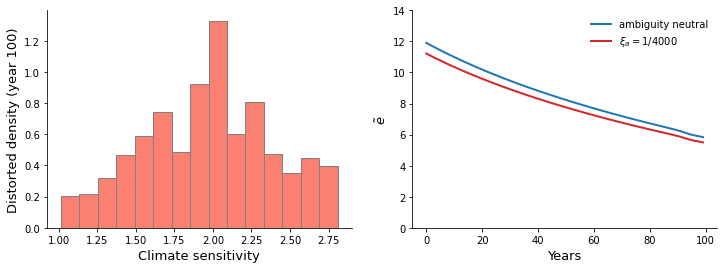

In [695]:
# plot 3
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.hist(θ_list*1000, weights=πt_avg[-1], density=True, bins=15, color="salmon", ec="grey")
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)


ax2.plot(et_neutral, color='C0', label='ambiguity neutral', linewidth=2.)
ax2.plot(et_avg, color='C3', label=r'$\xi_a = 1/4000$', linewidth=2.)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel(r'$\tilde{e}$', fontsize=13)
ax2.legend(frameon=False, loc='upper right')
ax2.set_ylim(0, 14)
# plt.savefig("../figures/hist_ems.pdf")

Text(0, 0.5, 'Distorted density (year 90)')

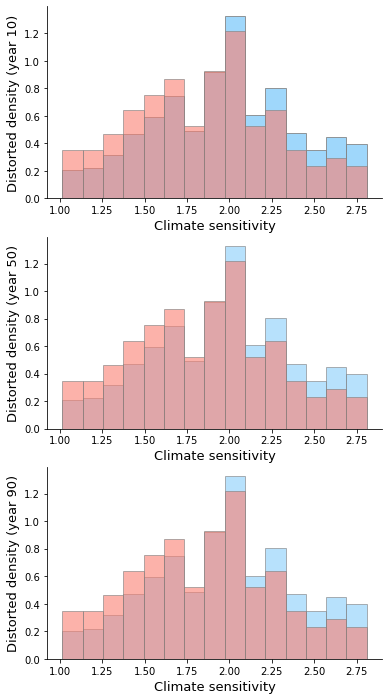

In [696]:
# histogram 10, 50, 90
colors = plotly.colors.qualitative.Set1
colors18 = plotly.colors.cyclical.IceFire
colors[5] = 'rgb(230,171,2)'

fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(6,12))
ax1.hist(θ_list*1000, weights=πt_avg[10]*np.exp(-10*δ), density=True, bins=15, color='lightskyblue', ec="grey", alpha=0.8)
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 10)', fontsize=13)

ax1.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 10)', fontsize=13)


ax2.hist(θ_list*1000, weights=πt_avg[50]*np.exp(-50*δ), density=True, bins=15, color="lightskyblue", ec="grey", alpha=0.6)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Distorted density (year 50)', fontsize=13)

ax2.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Distorted density (year 50)', fontsize=13)


ax3.hist(θ_list*1000, weights=πt_avg[90]*np.exp(-90*δ), density=True, bins=15, color="lightskyblue", ec="grey", alpha=0.6)
ax3.set_xlabel('Climate sensitivity', fontsize=13)
ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

ax3.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
ax3.set_xlabel('Climate sensitivity', fontsize=13)
ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

In [697]:
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
ξₐ = 1000
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_neutral, ems_neutral, π_neutral = solve_smooth(y_grid, args)

episode: 1,	 ode error: 0.0016934891576189867,	 ft error: 0.0014480394347653363
episode: 2,	 ode error: 0.0014492932759830744,	 ft error: 0.001317707050147796
episode: 3,	 ode error: 0.001335724065973165,	 ft error: 0.0012488543699307585
episode: 4,	 ode error: 0.0012683610116385128,	 ft error: 0.0012027362062758552
episode: 5,	 ode error: 0.0012191415970985856,	 ft error: 0.0011669909899751662
episode: 6,	 ode error: 0.0011793433594166163,	 ft error: 0.001137432680164021
episode: 7,	 ode error: 0.0011456443247324143,	 ft error: 0.0011107328221837789
episode: 8,	 ode error: 0.0011164157754603242,	 ft error: 0.0010868349176976313
episode: 9,	 ode error: 0.0010906685074948208,	 ft error: 0.0010658911506376996
episode: 10,	 ode error: 0.0010677201398960562,	 ft error: 0.001046000075909776
episode: 11,	 ode error: 0.0010470463512866949,	 ft error: 0.0010277609980478628
episode: 12,	 ode error: 0.0010282443264723736,	 ft error: 0.001010925706634729
episode: 13,	 ode error: 0.001010998860753

episode: 156,	 ode error: 0.00039458307689537527,	 ft error: 0.0003940712092523451
episode: 157,	 ode error: 0.0003926018188976395,	 ft error: 0.00039209281040376853
episode: 158,	 ode error: 0.0003906293077861301,	 ft error: 0.0003901230948990739
episode: 159,	 ode error: 0.000388665461071919,	 ft error: 0.0003881619848601752
episode: 160,	 ode error: 0.000386710205095272,	 ft error: 0.00038620940987449626
episode: 161,	 ode error: 0.0003847634673619393,	 ft error: 0.0003842653009124633
episode: 162,	 ode error: 0.0003828251799493106,	 ft error: 0.00038232959389824844
episode: 163,	 ode error: 0.00038089528007319534,	 ft error: 0.0003804022291478924
episode: 164,	 ode error: 0.00037897370678728235,	 ft error: 0.00037848314923460047
episode: 165,	 ode error: 0.00037706040502244725,	 ft error: 0.0003765723021260705
episode: 166,	 ode error: 0.0003751553216710451,	 ft error: 0.00037466963734918146
episode: 167,	 ode error: 0.0003732584075129273,	 ft error: 0.0003727751090823461
episode: 

episode: 263,	 ode error: 0.00022643620190049578,	 ft error: 0.00022617273447651337
episode: 264,	 ode error: 0.00022525124724866532,	 ft error: 0.00022499005312597484
episode: 265,	 ode error: 0.00022407270901977027,	 ft error: 0.00022381378178189712
episode: 266,	 ode error: 0.00022290055967981123,	 ft error: 0.00022264389215903568
episode: 267,	 ode error: 0.00022173477053496343,	 ft error: 0.00022148035585631276
episode: 268,	 ode error: 0.00022057531411775815,	 ft error: 0.00022032314504351336
episode: 269,	 ode error: 0.00021942216286570924,	 ft error: 0.00021917223187249701
episode: 270,	 ode error: 0.00021827528775355295,	 ft error: 0.00021802758797465999
episode: 271,	 ode error: 0.0002171346609554795,	 ft error: 0.00021688918440609478
episode: 272,	 ode error: 0.00021600025370883838,	 ft error: 0.0002157569927503193
episode: 273,	 ode error: 0.00021487203669363398,	 ft error: 0.00021463098369760755
episode: 274,	 ode error: 0.00021374998425424468,	 ft error: 0.000213511131177

episode: 375,	 ode error: 0.00012715688112555144,	 ft error: 0.00012709227947704332
episode: 376,	 ode error: 0.00012651787064154197,	 ft error: 0.0001264545300775725
episode: 377,	 ode error: 0.00012588232641120786,	 ft error: 0.00012582023859409228
episode: 378,	 ode error: 0.0001252502287307591,	 ft error: 0.00012518938550078648
episode: 379,	 ode error: 0.00012462155620442323,	 ft error: 0.0001245619496550073
episode: 380,	 ode error: 0.00012399628887302958,	 ft error: 0.00012393791082569255
episode: 381,	 ode error: 0.0001233744063362679,	 ft error: 0.00012331724931561225
episode: 382,	 ode error: 0.0001227558879039407,	 ft error: 0.00012269994363600656
episode: 383,	 ode error: 0.00012214071407370497,	 ft error: 0.000122085975769413
episode: 384,	 ode error: 0.00012152886630162059,	 ft error: 0.0001214753255326014
episode: 385,	 ode error: 0.00012092032235800341,	 ft error: 0.00012086797138766148
episode: 386,	 ode error: 0.00012031506448560811,	 ft error: 0.00012026389578585299


episode: 494,	 ode error: 7.069784924337895e-05,	 ft error: 7.073799258456674e-05
episode: 495,	 ode error: 7.035638208869872e-05,	 ft error: 7.039710396623822e-05
episode: 496,	 ode error: 7.001665096367359e-05,	 ft error: 7.005794789682884e-05
episode: 497,	 ode error: 6.967864913889432e-05,	 ft error: 6.97205170218281e-05
episode: 498,	 ode error: 6.934236456444896e-05,	 ft error: 6.938479956433707e-05
episode: 499,	 ode error: 6.900778869082852e-05,	 ft error: 6.905078778670268e-05
episode: 500,	 ode error: 6.867491166631429e-05,	 ft error: 6.871847074059931e-05
episode: 501,	 ode error: 6.834372517871407e-05,	 ft error: 6.838784033460592e-05
episode: 502,	 ode error: 6.801421863765196e-05,	 ft error: 6.805888652310077e-05
episode: 503,	 ode error: 6.768638275797577e-05,	 ft error: 6.773159959003647e-05
episode: 504,	 ode error: 6.736020968962106e-05,	 ft error: 6.74059720622705e-05
episode: 505,	 ode error: 6.703568814857774e-05,	 ft error: 6.70819916142688e-05
episode: 506,	 ode 

episode: 614,	 ode error: 3.9840199943940065e-05,	 ft error: 3.992769234922404e-05
episode: 615,	 ode error: 3.96522691095421e-05,	 ft error: 3.97400026779654e-05
episode: 616,	 ode error: 3.9465251220948804e-05,	 ft error: 3.955322395360339e-05
episode: 617,	 ode error: 3.9279141184651346e-05,	 ft error: 3.936735115233255e-05
episode: 618,	 ode error: 3.909393455671752e-05,	 ft error: 3.918238018339737e-05
episode: 619,	 ode error: 3.89096256327863e-05,	 ft error: 3.8998303835274806e-05
episode: 620,	 ode error: 3.872621104761211e-05,	 ft error: 3.881512108403855e-05
episode: 621,	 ode error: 3.85436858694934e-05,	 ft error: 3.8632824810452826e-05
episode: 622,	 ode error: 3.836204496888984e-05,	 ft error: 3.84514107211927e-05
episode: 623,	 ode error: 3.8181285382766876e-05,	 ft error: 3.827087456539924e-05
episode: 624,	 ode error: 3.800140038397659e-05,	 ft error: 3.809121253241695e-05
episode: 625,	 ode error: 3.782238705568315e-05,	 ft error: 3.791241929125555e-05
episode: 626,	 

episode: 732,	 ode error: 2.288478229372701e-05,	 ft error: 2.2987077936409417e-05
episode: 733,	 ode error: 2.2778012754519654e-05,	 ft error: 2.288031608480475e-05
episode: 734,	 ode error: 2.2671747615897182e-05,	 ft error: 2.2774053917059188e-05
episode: 735,	 ode error: 2.2565983413029393e-05,	 ft error: 2.266829034203166e-05
episode: 736,	 ode error: 2.246071716805061e-05,	 ft error: 2.256302594342193e-05
episode: 737,	 ode error: 2.235594713813566e-05,	 ft error: 2.2458254315081232e-05
episode: 738,	 ode error: 2.2251671303550008e-05,	 ft error: 2.2353974356292827e-05
episode: 739,	 ode error: 2.2147886585242968e-05,	 ft error: 2.2250184192051936e-05
episode: 740,	 ode error: 2.20445891787077e-05,	 ft error: 2.2146879063549472e-05
episode: 741,	 ode error: 2.1941779413859664e-05,	 ft error: 2.2044057554557184e-05
episode: 742,	 ode error: 2.1839454087099253e-05,	 ft error: 2.1941718808607402e-05
episode: 743,	 ode error: 2.1737609652508027e-05,	 ft error: 2.1839862103060586e-05


episode: 853,	 ode error: 1.3007115259625187e-05,	 ft error: 1.3088452798445949e-05
episode: 854,	 ode error: 1.2946542449114497e-05,	 ft error: 1.3027414709418372e-05
episode: 855,	 ode error: 1.288625045045566e-05,	 ft error: 1.296665176566773e-05
episode: 856,	 ode error: 1.2826238163297964e-05,	 ft error: 1.2906171211329864e-05
episode: 857,	 ode error: 1.2766505598471069e-05,	 ft error: 1.2845952040985154e-05
episode: 858,	 ode error: 1.2707050228822877e-05,	 ft error: 1.2786009857106614e-05
episode: 859,	 ode error: 1.2647871298439718e-05,	 ft error: 1.2726327860470196e-05
episode: 860,	 ode error: 1.2588967188487403e-05,	 ft error: 1.2666916782075321e-05
episode: 861,	 ode error: 1.2530337348299106e-05,	 ft error: 1.260777033822158e-05
episode: 862,	 ode error: 1.2471979178468027e-05,	 ft error: 1.2548883562048715e-05
episode: 863,	 ode error: 1.2413891911713395e-05,	 ft error: 1.249025965865495e-05
episode: 864,	 ode error: 1.2356075538189461e-05,	 ft error: 1.2431892007502832e

episode: 971,	 ode error: 7.505988646357804e-06,	 ft error: 7.298478543193987e-06
episode: 972,	 ode error: 7.471588537853757e-06,	 ft error: 7.25146659036798e-06
episode: 973,	 ode error: 7.437385715954297e-06,	 ft error: 7.203562546950759e-06
episode: 974,	 ode error: 7.403381086179984e-06,	 ft error: 7.15491270714593e-06
episode: 975,	 ode error: 7.36957822880318e-06,	 ft error: 7.105186238022995e-06
episode: 976,	 ode error: 7.335980449149518e-06,	 ft error: 7.05411515926809e-06
episode: 977,	 ode error: 7.302591121775598e-06,	 ft error: 7.001781655348779e-06
episode: 978,	 ode error: 7.269415392177105e-06,	 ft error: 6.947605282955904e-06
episode: 979,	 ode error: 7.236459843598946e-06,	 ft error: 6.891202051310478e-06
episode: 980,	 ode error: 7.203729578350972e-06,	 ft error: 6.832551345560082e-06
episode: 981,	 ode error: 7.171233944844335e-06,	 ft error: 6.770561895343604e-06
episode: 982,	 ode error: 7.138984180539215e-06,	 ft error: 6.705011675855096e-06
episode: 983,	 ode e

episode: 1092,	 ode error: 4.982871291933514e-06,	 ft error: 4.553952193999308e-06
episode: 1093,	 ode error: 4.9729921173537715e-06,	 ft error: 4.530921734561637e-06
episode: 1094,	 ode error: 4.96311698111021e-06,	 ft error: 4.5080374030948e-06
episode: 1095,	 ode error: 4.95324531556195e-06,	 ft error: 4.485327719100374e-06
episode: 1096,	 ode error: 4.943378955525254e-06,	 ft error: 4.462800277290254e-06
episode: 1097,	 ode error: 4.933516861607701e-06,	 ft error: 4.440443614611711e-06
episode: 1098,	 ode error: 4.923660957324564e-06,	 ft error: 4.418220235687572e-06
episode: 1099,	 ode error: 4.913812624168096e-06,	 ft error: 4.396151648058955e-06
episode: 1100,	 ode error: 4.903972439215961e-06,	 ft error: 4.374239981087362e-06
episode: 1101,	 ode error: 4.894141591766494e-06,	 ft error: 4.352472718419098e-06
episode: 1102,	 ode error: 4.884320795139939e-06,	 ft error: 4.330865672197426e-06
episode: 1103,	 ode error: 4.874510675184412e-06,	 ft error: 4.309391410939334e-06
episode

episode: 1214,	 ode error: 3.974109364182545e-06,	 ft error: 2.537779508389922e-06
episode: 1215,	 ode error: 3.9678344377751815e-06,	 ft error: 2.526156792775902e-06
episode: 1216,	 ode error: 3.961587959000305e-06,	 ft error: 2.514607025036475e-06
episode: 1217,	 ode error: 3.955369188942911e-06,	 ft error: 2.5031123467254375e-06
episode: 1218,	 ode error: 3.949179129654414e-06,	 ft error: 2.4916794996489764e-06
episode: 1219,	 ode error: 3.943014904662099e-06,	 ft error: 2.480312274270406e-06
episode: 1220,	 ode error: 3.936880933271924e-06,	 ft error: 2.469012256057594e-06
episode: 1221,	 ode error: 3.930772564799214e-06,	 ft error: 2.4577616752434013e-06
episode: 1222,	 ode error: 3.92469251857719e-06,	 ft error: 2.4465782103716416e-06
episode: 1223,	 ode error: 3.918638690460544e-06,	 ft error: 2.4354531915025497e-06
episode: 1224,	 ode error: 3.912612603284953e-06,	 ft error: 2.4243850001159917e-06
episode: 1225,	 ode error: 3.9066137924571e-06,	 ft error: 2.4133802666951682e-06

episode: 1333,	 ode error: 3.4189914430843554e-06,	 ft error: 1.4492955196024337e-06
episode: 1334,	 ode error: 3.4158397510942844e-06,	 ft error: 1.4453189877093135e-06
episode: 1335,	 ode error: 3.412704959711646e-06,	 ft error: 1.4413483208006173e-06
episode: 1336,	 ode error: 3.409586757717833e-06,	 ft error: 1.4373804738930982e-06
episode: 1337,	 ode error: 3.406486440741272e-06,	 ft error: 1.433421799208745e-06
episode: 1338,	 ode error: 3.403401939040449e-06,	 ft error: 1.429470510375582e-06
episode: 1339,	 ode error: 3.4003334030425613e-06,	 ft error: 1.4255205737246739e-06
episode: 1340,	 ode error: 3.3972807999305436e-06,	 ft error: 1.4215779024079334e-06
episode: 1341,	 ode error: 3.39424341617078e-06,	 ft error: 1.4176424363461042e-06
episode: 1342,	 ode error: 3.3912226794216094e-06,	 ft error: 1.4137097527691656e-06
episode: 1343,	 ode error: 3.3882159286479025e-06,	 ft error: 1.4097832393376402e-06
episode: 1344,	 ode error: 3.385224783255766e-06,	 ft error: 1.4058666165

episode: 1454,	 ode error: 3.1246335253504176e-06,	 ft error: 1.0166564981192727e-06
episode: 1455,	 ode error: 3.122797622077912e-06,	 ft error: 1.0135839472596997e-06
episode: 1456,	 ode error: 3.1209717147224775e-06,	 ft error: 1.0105230406967647e-06
episode: 1457,	 ode error: 3.1191541379334232e-06,	 ft error: 1.0074710658086738e-06
episode: 1458,	 ode error: 3.1173451925339173e-06,	 ft error: 1.0044276019828084e-06
episode: 1459,	 ode error: 3.1155458825661867e-06,	 ft error: 1.001395010328162e-06
episode: 1460,	 ode error: 3.1137551105312952e-06,	 ft error: 9.983734534577127e-07
episode: 1461,	 ode error: 3.1119743028077892e-06,	 ft error: 9.95359365138504e-07
episode: 1462,	 ode error: 3.1102014300381925e-06,	 ft error: 9.923544051076982e-07
episode: 1463,	 ode error: 3.108437234563698e-06,	 ft error: 9.893622220207474e-07
episode: 1464,	 ode error: 3.106683788732024e-06,	 ft error: 9.863750967629519e-07
episode: 1465,	 ode error: 3.1049379287137295e-06,	 ft error: 9.83398801696

episode: 1571,	 ode error: 2.9657486798971133e-06,	 ft error: 7.163367309048763e-07
episode: 1572,	 ode error: 2.964803449792097e-06,	 ft error: 7.142105439237694e-07
episode: 1573,	 ode error: 2.963863818138796e-06,	 ft error: 7.120905535136964e-07
episode: 1574,	 ode error: 2.962929979252911e-06,	 ft error: 7.099769236638502e-07
episode: 1575,	 ode error: 2.9620021466856238e-06,	 ft error: 7.078684196211901e-07
episode: 1576,	 ode error: 2.961079464996216e-06,	 ft error: 7.057661935196599e-07
episode: 1577,	 ode error: 2.960162446394971e-06,	 ft error: 7.036725271335661e-07
episode: 1578,	 ode error: 2.9592499212553183e-06,	 ft error: 7.015806343171893e-07
episode: 1579,	 ode error: 2.958343669771089e-06,	 ft error: 6.994988119753595e-07
episode: 1580,	 ode error: 2.9574427980709342e-06,	 ft error: 6.974211461581911e-07
episode: 1581,	 ode error: 2.9565473533428024e-06,	 ft error: 6.953502638383976e-07
episode: 1582,	 ode error: 2.9556571080079953e-06,	 ft error: 6.932868013472445e-0

episode: 1693,	 ode error: 2.884012306990152e-06,	 ft error: 4.979797062094431e-07
episode: 1694,	 ode error: 2.8835703346661787e-06,	 ft error: 4.964960598323928e-07
episode: 1695,	 ode error: 2.883131606285297e-06,	 ft error: 4.950174361043058e-07
episode: 1696,	 ode error: 2.8826947431160677e-06,	 ft error: 4.935454561242707e-07
episode: 1697,	 ode error: 2.882261725267168e-06,	 ft error: 4.920775979397329e-07
episode: 1698,	 ode error: 2.8818317582274397e-06,	 ft error: 4.906128697977168e-07
episode: 1699,	 ode error: 2.8814047297275307e-06,	 ft error: 4.891542922103032e-07
episode: 1700,	 ode error: 2.880981071684747e-06,	 ft error: 4.877014837927537e-07
episode: 1701,	 ode error: 2.88056044502234e-06,	 ft error: 4.86253160456492e-07
episode: 1702,	 ode error: 2.8801425812513028e-06,	 ft error: 4.848074265535278e-07
episode: 1703,	 ode error: 2.8797268373034627e-06,	 ft error: 4.833618674991251e-07
episode: 1704,	 ode error: 2.879314636177149e-06,	 ft error: 4.81925839825037e-07
e

episode: 1812,	 ode error: 2.8490080461151786e-06,	 ft error: 3.4947633239847586e-07
episode: 1813,	 ode error: 2.8488352206878153e-06,	 ft error: 3.484376843304604e-07
episode: 1814,	 ode error: 2.848663647491952e-06,	 ft error: 3.473999455004077e-07
episode: 1815,	 ode error: 2.848493225118256e-06,	 ft error: 3.4636655247647735e-07
episode: 1816,	 ode error: 2.8483242309965e-06,	 ft error: 3.453349015312505e-07
episode: 1817,	 ode error: 2.8481566360402492e-06,	 ft error: 3.443063435748517e-07
episode: 1818,	 ode error: 2.847991209731964e-06,	 ft error: 3.4328236532312395e-07
episode: 1819,	 ode error: 2.847827317093896e-06,	 ft error: 3.4226176795493224e-07
episode: 1820,	 ode error: 2.8476646551763235e-06,	 ft error: 3.412427778889948e-07
episode: 1821,	 ode error: 2.8475034352437372e-06,	 ft error: 3.40227694177464e-07
episode: 1822,	 ode error: 2.8473438271572242e-06,	 ft error: 3.392172390551118e-07
episode: 1823,	 ode error: 2.847185446118905e-06,	 ft error: 3.382112490647275e-

episode: 1929,	 ode error: 2.8373069888379962e-06,	 ft error: 2.465738236044161e-07
episode: 1930,	 ode error: 2.8372661798355516e-06,	 ft error: 2.4583739457323395e-07
episode: 1931,	 ode error: 2.837226160324626e-06,	 ft error: 2.451043097997929e-07
episode: 1932,	 ode error: 2.837187403790728e-06,	 ft error: 2.443739393828692e-07
episode: 1933,	 ode error: 2.8371487203015903e-06,	 ft error: 2.436453296293199e-07
episode: 1934,	 ode error: 2.8371113401760113e-06,	 ft error: 2.429186681205768e-07
episode: 1935,	 ode error: 2.83707419029063e-06,	 ft error: 2.4219436528064947e-07
episode: 1936,	 ode error: 2.8370383272998843e-06,	 ft error: 2.414734190381296e-07
episode: 1937,	 ode error: 2.8370029819922574e-06,	 ft error: 2.407554251793176e-07
episode: 1938,	 ode error: 2.8369686543660124e-06,	 ft error: 2.400400108080551e-07
episode: 1939,	 ode error: 2.8369349890874397e-06,	 ft error: 2.393246777953236e-07
episode: 1940,	 ode error: 2.8369020899385398e-06,	 ft error: 2.38610509302461

episode: 2050,	 ode error: 2.836871327050101e-06,	 ft error: 1.7181716262711552e-07
episode: 2051,	 ode error: 2.8368965486935595e-06,	 ft error: 1.7130460175374118e-07
episode: 2052,	 ode error: 2.8369218671467312e-06,	 ft error: 1.7079335035372994e-07
episode: 2053,	 ode error: 2.8369474608824123e-06,	 ft error: 1.7028320187933987e-07
episode: 2054,	 ode error: 2.8369737009545934e-06,	 ft error: 1.6977402422559593e-07
episode: 2055,	 ode error: 2.8370001551411995e-06,	 ft error: 1.6926679753439164e-07
episode: 2056,	 ode error: 2.8370266114264957e-06,	 ft error: 1.6876063337288122e-07
episode: 2057,	 ode error: 2.837053425889472e-06,	 ft error: 1.682556277869211e-07
episode: 2058,	 ode error: 2.837080616626005e-06,	 ft error: 1.6775230451265832e-07
episode: 2059,	 ode error: 2.8371081405669223e-06,	 ft error: 1.6725161151864842e-07
episode: 2060,	 ode error: 2.8371353504839675e-06,	 ft error: 1.667530399179773e-07
episode: 2061,	 ode error: 2.837163321359258e-06,	 ft error: 1.6625484

episode: 2167,	 ode error: 2.841535525639088e-06,	 ft error: 1.211191013224718e-07
episode: 2168,	 ode error: 2.841586007526313e-06,	 ft error: 1.2075731646114346e-07
episode: 2169,	 ode error: 2.8416362880151784e-06,	 ft error: 1.2039619355872871e-07
episode: 2170,	 ode error: 2.841686949129588e-06,	 ft error: 1.2003685848545795e-07
episode: 2171,	 ode error: 2.841737637756278e-06,	 ft error: 1.1967960227010632e-07
episode: 2172,	 ode error: 2.8417883122996155e-06,	 ft error: 1.1932377883226247e-07
episode: 2173,	 ode error: 2.8418391949257445e-06,	 ft error: 1.189694674025299e-07
episode: 2174,	 ode error: 2.841890286840623e-06,	 ft error: 1.1861564587027178e-07
episode: 2175,	 ode error: 2.841941665779487e-06,	 ft error: 1.1826230784014088e-07
episode: 2176,	 ode error: 2.841992895051505e-06,	 ft error: 1.1790952094322313e-07
episode: 2177,	 ode error: 2.8420446824703677e-06,	 ft error: 1.1755655867732677e-07
episode: 2178,	 ode error: 2.8420962970813904e-06,	 ft error: 1.1720571152

episode: 2289,	 ode error: 2.848213412476124e-06,	 ft error: 8.410121998120301e-08
episode: 2290,	 ode error: 2.84827022399136e-06,	 ft error: 8.38495350236057e-08
episode: 2291,	 ode error: 2.848326973886291e-06,	 ft error: 8.359880892862734e-08
episode: 2292,	 ode error: 2.8483833277462376e-06,	 ft error: 8.334906571640563e-08
episode: 2293,	 ode error: 2.848439999249665e-06,	 ft error: 8.309972499472482e-08
episode: 2294,	 ode error: 2.848496763105542e-06,	 ft error: 8.285098602548817e-08
episode: 2295,	 ode error: 2.848553316426054e-06,	 ft error: 8.260276831752641e-08
episode: 2296,	 ode error: 2.848609970553407e-06,	 ft error: 8.235586514832027e-08
episode: 2297,	 ode error: 2.8486665429159784e-06,	 ft error: 8.211040536156475e-08
episode: 2298,	 ode error: 2.8487233024293004e-06,	 ft error: 8.186548621872773e-08
episode: 2299,	 ode error: 2.8487796907422647e-06,	 ft error: 8.162044650104432e-08
episode: 2300,	 ode error: 2.8488364156661764e-06,	 ft error: 8.137691507916397e-08
e

episode: 2409,	 ode error: 2.8548617684740147e-06,	 ft error: 5.8734248240451446e-08
episode: 2410,	 ode error: 2.854914773140751e-06,	 ft error: 5.855798995008099e-08
episode: 2411,	 ode error: 2.8549676960347914e-06,	 ft error: 5.8382003710610864e-08
episode: 2412,	 ode error: 2.8550205296521552e-06,	 ft error: 5.820717783923864e-08
episode: 2413,	 ode error: 2.85507329309822e-06,	 ft error: 5.80324710855451e-08
episode: 2414,	 ode error: 2.8551256440426543e-06,	 ft error: 5.785864780338823e-08
episode: 2415,	 ode error: 2.8551782704610684e-06,	 ft error: 5.768624443865574e-08
episode: 2416,	 ode error: 2.8552306808911224e-06,	 ft error: 5.7514177263332897e-08
episode: 2417,	 ode error: 2.8552832795438778e-06,	 ft error: 5.734300284609972e-08
episode: 2418,	 ode error: 2.8553357556894855e-06,	 ft error: 5.71723701830081e-08
episode: 2419,	 ode error: 2.8553882365461684e-06,	 ft error: 5.700217999005108e-08
episode: 2420,	 ode error: 2.855440668874938e-06,	 ft error: 5.683149667303396

episode: 2528,	 ode error: 2.8607529001366955e-06,	 ft error: 4.113210044555856e-08
episode: 2529,	 ode error: 2.8607984985591943e-06,	 ft error: 4.1009196998879435e-08
episode: 2530,	 ode error: 2.8608440622337724e-06,	 ft error: 4.088635195455733e-08
episode: 2531,	 ode error: 2.860889522583775e-06,	 ft error: 4.0763733268519196e-08
episode: 2532,	 ode error: 2.860934931332151e-06,	 ft error: 4.064135070147579e-08
episode: 2533,	 ode error: 2.860980070364637e-06,	 ft error: 4.051953839586305e-08
episode: 2534,	 ode error: 2.86102508520751e-06,	 ft error: 4.039859068799556e-08
episode: 2535,	 ode error: 2.8610702518102812e-06,	 ft error: 4.027765725111987e-08
episode: 2536,	 ode error: 2.8611150155586533e-06,	 ft error: 4.015740290066091e-08
episode: 2537,	 ode error: 2.8611600418192596e-06,	 ft error: 4.003747497890083e-08
episode: 2538,	 ode error: 2.8612048433255145e-06,	 ft error: 3.9918277930835654e-08
episode: 2539,	 ode error: 2.861249770116101e-06,	 ft error: 3.979958477368095

episode: 2649,	 ode error: 2.8657683661945706e-06,	 ft error: 2.8626430126817613e-08
episode: 2650,	 ode error: 2.8658055044201167e-06,	 ft error: 2.854064947340381e-08
episode: 2651,	 ode error: 2.8658424495403654e-06,	 ft error: 2.8455206767252772e-08
episode: 2652,	 ode error: 2.86587946108632e-06,	 ft error: 2.8370331812965777e-08
episode: 2653,	 ode error: 2.8659164399768644e-06,	 ft error: 2.8285644185684543e-08
episode: 2654,	 ode error: 2.8659533435942876e-06,	 ft error: 2.8201005431346036e-08
episode: 2655,	 ode error: 2.865989972694323e-06,	 ft error: 2.81165417337359e-08
episode: 2656,	 ode error: 2.866026760410317e-06,	 ft error: 2.8032532568370943e-08
episode: 2657,	 ode error: 2.8660634854625697e-06,	 ft error: 2.794844069139065e-08
episode: 2658,	 ode error: 2.8661001300112933e-06,	 ft error: 2.7865061138128887e-08
episode: 2659,	 ode error: 2.866136716989749e-06,	 ft error: 2.7781668609135522e-08
episode: 2660,	 ode error: 2.866172999143571e-06,	 ft error: 2.76987616986

episode: 2765,	 ode error: 2.869652348170778e-06,	 ft error: 2.022899721574693e-08
episode: 2766,	 ode error: 2.8696821049183e-06,	 ft error: 2.0168884016606253e-08
episode: 2767,	 ode error: 2.8697117993622522e-06,	 ft error: 2.0108645581995432e-08
episode: 2768,	 ode error: 2.869741479528021e-06,	 ft error: 2.0048534129143057e-08
episode: 2769,	 ode error: 2.869771096432761e-06,	 ft error: 1.9989095633351127e-08
episode: 2770,	 ode error: 2.869800640492885e-06,	 ft error: 1.992965627019746e-08
episode: 2771,	 ode error: 2.8698301673356613e-06,	 ft error: 1.9870166403460992e-08
episode: 2772,	 ode error: 2.8698595940681963e-06,	 ft error: 1.981048615660545e-08
episode: 2773,	 ode error: 2.8698888811925713e-06,	 ft error: 1.9750963434206348e-08
episode: 2774,	 ode error: 2.8699181705545227e-06,	 ft error: 1.9692190806238262e-08
episode: 2775,	 ode error: 2.86994744910275e-06,	 ft error: 1.9633379632714536e-08
episode: 2776,	 ode error: 2.869976644936218e-06,	 ft error: 1.95747158644269

episode: 2883,	 ode error: 2.872760736567716e-06,	 ft error: 1.4202630529980276e-08
episode: 2884,	 ode error: 2.87278357048715e-06,	 ft error: 1.4160143728865945e-08
episode: 2885,	 ode error: 2.8728066243981438e-06,	 ft error: 1.4117737985597234e-08
episode: 2886,	 ode error: 2.8728296194674256e-06,	 ft error: 1.4075327604834431e-08
episode: 2887,	 ode error: 2.8728525471042113e-06,	 ft error: 1.4032796938345804e-08
episode: 2888,	 ode error: 2.8728751393455485e-06,	 ft error: 1.3990557404715739e-08
episode: 2889,	 ode error: 2.8728979278957838e-06,	 ft error: 1.3948303449751176e-08
episode: 2890,	 ode error: 2.8729206475953863e-06,	 ft error: 1.3906121844320385e-08
episode: 2891,	 ode error: 2.872943296112671e-06,	 ft error: 1.386497585723993e-08
episode: 2892,	 ode error: 2.8729659538016556e-06,	 ft error: 1.3823723485351103e-08
episode: 2893,	 ode error: 2.8729885874603832e-06,	 ft error: 1.3782265803156484e-08
episode: 2894,	 ode error: 2.8730111396792646e-06,	 ft error: 1.374136

In [698]:
yt_neutral, et_neutral, πt_neutral = simulate_traj(y_grid, ems_neutral, π_neutral, θ_list)

# ase 2: bring h back in

$$
\begin{aligned}
0 = \max_{\tilde e} \min_h \min_{\pi^c} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& + \sum \pi^c_i \left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_i \\
& + \left[ \frac{d\phi}{dy} + (\eta - 1 )(\gamma_1 + \gamma_2 y)\right]\tilde e \sigma_y h\\
& + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& + \frac{\xi_m}{2}h'h + \xi_a \sum \pi^c_i (\log \pi^c_i - \log \hat\pi^c_i)
\end{aligned}
$$

Minimize over $h$:
$$
h^* = - \cfrac{\frac{d\phi}{dy} + (\eta - 1 )(\gamma_1 + \gamma_2 y)}{\xi_m}\cdot\tilde e \sigma_y
$$

Plug back in:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^c} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& + \sum \pi^c_i \left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_i \\
& + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& - \frac{1}{2\xi_m}\left[ \frac{d\phi}{dy} + (\eta - 1 )(\gamma_1 + \gamma_2 y)\right]^2 (\tilde e)^2 |\sigma_y|^2\\
&  + \xi_a \sum \pi^c_i (\log \pi^c_i - \log \hat\pi^c_i)
\end{aligned}
$$

Optimald distribution:
$$
\pi^c_j \propto \hat\pi^c_j \exp\left( -\frac{1}{\xi_a}\left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_j \right)
$$


First order condition for $\tilde e^*$:

$$
  \left[- \frac{1}{\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2\phi(y)}{dy^2}\right] \cdot|\sigma_y|^2\cdot(\tilde e)^2 + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j \tilde e + \delta\eta = 0
$$

$$
A =  \left[- \frac{1}{\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2\phi(y)}{dy^2}\right] \cdot|\sigma_y|^2
$$

$$
B = \sum_j \pi_j^c \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j
$$

$$
C = \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$
Here we set $\xi_a = 1000$, so there is no ambiguity.

In [574]:
def solve_smooth_robust(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξₘ = args
    dy = y_grid[1] - y_grid[0]
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
    ϕ = - δ*η*y_grid**2
    ems = δ*η
    ems_old = ems
    πo = np.ones((len(θ_list), n_y))/len(θ_list)
    lhs_error = 1
    episode = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy)
        dϕdyy = derivative_1d(ϕ, 2, dy)
        temp = dϕdy + (η-1)*dΛ
        # update belief
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
        a = dϕdyy*σy**2 - temp**2*σy**2/ξₘ
        b = (θ_list@π)*temp
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*1. + ems_old*0.
        # solve for ode
        A = - δ*np.ones(y_grid.shape)
        B = (θ_list@π)*ems
        C = ems**2*σy**2/2
        D = δ*η*np.log(ems) + (θ_list@π)*(η-1)*dΛ*ems \
        + ξₐ*np.sum(π*(np.log(π) - np.log(πo)), axis=0)\
        - temp**2*ems**2*σy**2/(2*ξₘ)
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems, π

In [575]:
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
ξₐ = 1000
ξₘ = 0.004
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξₘ)
ϕ_rbt, ems_rbt, π_rbt = solve_smooth_robust(y_grid, args)

episode: 1,	 ode error: 0.0017693721742482857,	 ft error: 0.0014229026518458444
episode: 2,	 ode error: 0.0014992987017046532,	 ft error: 0.001336733427764558
episode: 3,	 ode error: 0.001364502603506445,	 ft error: 0.0012709463117830156
episode: 4,	 ode error: 0.0012810525469237857,	 ft error: 0.0012178967918040078
episode: 5,	 ode error: 0.0012227413319707413,	 ft error: 0.0011763318644859074
episode: 6,	 ode error: 0.0011783753401902462,	 ft error: 0.001141620952941706
episode: 7,	 ode error: 0.001142619057821979,	 ft error: 0.0011130235224899795
episode: 8,	 ode error: 0.0011126366019038347,	 ft error: 0.0010874014225766135
episode: 9,	 ode error: 0.0010867605275739582,	 ft error: 0.0010647717940582694
episode: 10,	 ode error: 0.0010639453797626941,	 ft error: 0.0010444652572445697
episode: 11,	 ode error: 0.001043496855617786,	 ft error: 0.0010260129018904358
episode: 12,	 ode error: 0.0010249324056581244,	 ft error: 0.0010090747848485668
episode: 13,	 ode error: 0.001007903870775

episode: 173,	 ode error: 0.00036077730698249157,	 ft error: 0.00036030815854695697
episode: 174,	 ode error: 0.00035894091047824735,	 ft error: 0.000358473968325145
episode: 175,	 ode error: 0.0003571123311756878,	 ft error: 0.0003566475800041019
episode: 176,	 ode error: 0.0003552915440333434,	 ft error: 0.0003548289706851541
episode: 177,	 ode error: 0.0003534785242563049,	 ft error: 0.00035301811730344135
episode: 178,	 ode error: 0.0003516732520000412,	 ft error: 0.0003512150016403426
episode: 179,	 ode error: 0.0003498757069021211,	 ft error: 0.0003494196046616392
episode: 180,	 ode error: 0.0003480858709816973,	 ft error: 0.0003476319100836669
episode: 181,	 ode error: 0.000346303726916134,	 ft error: 0.00034585190217553685
episode: 182,	 ode error: 0.0003445292607783918,	 ft error: 0.0003440795679721572
episode: 183,	 ode error: 0.0003427624567301961,	 ft error: 0.00034231489333192333
episode: 184,	 ode error: 0.00034100330320960314,	 ft error: 0.000340557867352422
episode: 185

episode: 349,	 ode error: 0.0001442501820333971,	 ft error: 0.00014414728356823558
episode: 350,	 ode error: 0.0001435158227136126,	 ft error: 0.000143414396312098
episode: 351,	 ode error: 0.00014278550584661393,	 ft error: 0.00014268554217331902
episode: 352,	 ode error: 0.0001420592081464837,	 ft error: 0.00014196069785777737
episode: 353,	 ode error: 0.00014133690469541986,	 ft error: 0.00014123983915259597
episode: 354,	 ode error: 0.0001406185716893338,	 ft error: 0.00014052294144796992
episode: 355,	 ode error: 0.00013990418675591482,	 ft error: 0.00013980998304669498
episode: 356,	 ode error: 0.00013919372494180626,	 ft error: 0.00013910093904776397
episode: 357,	 ode error: 0.00013848716417325818,	 ft error: 0.00013839578674519626
episode: 358,	 ode error: 0.0001377844807857032,	 ft error: 0.0001376945036207546
episode: 359,	 ode error: 0.00013708565167186752,	 ft error: 0.00013699706541914214
episode: 360,	 ode error: 0.00013639065383167263,	 ft error: 0.00013630345001386843


episode: 524,	 ode error: 6.0702270252328155e-05,	 ft error: 6.075335344355356e-05
episode: 525,	 ode error: 6.0410406310967076e-05,	 ft error: 6.0461950235554673e-05
episode: 526,	 ode error: 6.012001107678455e-05,	 ft error: 6.0172011808653135e-05
episode: 527,	 ode error: 5.983107525500415e-05,	 ft error: 5.988353007293131e-05
episode: 528,	 ode error: 5.954359070769848e-05,	 ft error: 5.959649669762257e-05
episode: 529,	 ode error: 5.9257550612549646e-05,	 ft error: 5.931090466840724e-05
episode: 530,	 ode error: 5.897294550696755e-05,	 ft error: 5.902674478155956e-05
episode: 531,	 ode error: 5.868976972533914e-05,	 ft error: 5.874400993426584e-05
episode: 532,	 ode error: 5.840801412151887e-05,	 ft error: 5.846269291532684e-05
episode: 533,	 ode error: 5.812767124538289e-05,	 ft error: 5.8182784189800274e-05
episode: 534,	 ode error: 5.784873285872769e-05,	 ft error: 5.790427901534538e-05
episode: 535,	 ode error: 5.757119317287263e-05,	 ft error: 5.7627167932491896e-05
episode: 

episode: 698,	 ode error: 2.6558349519234937e-05,	 ft error: 2.6651613087985693e-05
episode: 699,	 ode error: 2.6433746512306367e-05,	 ft error: 2.652706686654775e-05
episode: 700,	 ode error: 2.630973602880959e-05,	 ft error: 2.6403111167995024e-05
episode: 701,	 ode error: 2.618631619890927e-05,	 ft error: 2.6279744629713796e-05
episode: 702,	 ode error: 2.6063483980159983e-05,	 ft error: 2.615696233614536e-05
episode: 703,	 ode error: 2.5941235718277282e-05,	 ft error: 2.6034764247460467e-05
episode: 704,	 ode error: 2.58195693071798e-05,	 ft error: 2.591314563972954e-05
episode: 705,	 ode error: 2.5698480888869737e-05,	 ft error: 2.5792101343985463e-05
episode: 706,	 ode error: 2.557796842654733e-05,	 ft error: 2.567163264711551e-05
episode: 707,	 ode error: 2.5458028758063326e-05,	 ft error: 2.5551731806748117e-05
episode: 708,	 ode error: 2.5338658818447246e-05,	 ft error: 2.543240121175942e-05
episode: 709,	 ode error: 2.5219856051434102e-05,	 ft error: 2.5313634774519016e-05
ep

episode: 867,	 ode error: 1.2022710173381678e-05,	 ft error: 1.208585163207469e-05
episode: 868,	 ode error: 1.196647632021263e-05,	 ft error: 1.2029038040164974e-05
episode: 869,	 ode error: 1.1910504022259e-05,	 ft error: 1.1972469886762743e-05
episode: 870,	 ode error: 1.1854793753555124e-05,	 ft error: 1.1916164051305652e-05
episode: 871,	 ode error: 1.1799342116435604e-05,	 ft error: 1.1860101433354883e-05
episode: 872,	 ode error: 1.1744150117891047e-05,	 ft error: 1.180428576043798e-05
episode: 873,	 ode error: 1.1689215393900906e-05,	 ft error: 1.1748729586494311e-05
episode: 874,	 ode error: 1.1634535951870941e-05,	 ft error: 1.1693408398423996e-05
episode: 875,	 ode error: 1.158011254814254e-05,	 ft error: 1.16383328667193e-05
episode: 876,	 ode error: 1.15259429563511e-05,	 ft error: 1.1583500180434303e-05
episode: 877,	 ode error: 1.147202451625437e-05,	 ft error: 1.1528917118313239e-05
episode: 878,	 ode error: 1.1418358682681231e-05,	 ft error: 1.1474568209583296e-05
epis

episode: 1029,	 ode error: 6.145109405100528e-06,	 ft error: 5.6373515282491056e-06
episode: 1030,	 ode error: 6.125634911095324e-06,	 ft error: 5.610705685564025e-06
episode: 1031,	 ode error: 6.106487253472405e-06,	 ft error: 5.584177686229763e-06
episode: 1032,	 ode error: 6.087655170182373e-06,	 ft error: 5.557777151647218e-06
episode: 1033,	 ode error: 6.069126482349644e-06,	 ft error: 5.531491209659345e-06
episode: 1034,	 ode error: 6.050890192588762e-06,	 ft error: 5.50532460943017e-06
episode: 1035,	 ode error: 6.03293533435516e-06,	 ft error: 5.479278696064275e-06
episode: 1036,	 ode error: 6.015250711129052e-06,	 ft error: 5.453349839132371e-06
episode: 1037,	 ode error: 5.997825630733151e-06,	 ft error: 5.427539673923584e-06
episode: 1038,	 ode error: 5.9806492841471114e-06,	 ft error: 5.401847114038424e-06
episode: 1039,	 ode error: 5.9637123920766415e-06,	 ft error: 5.376272814184661e-06
episode: 1040,	 ode error: 5.947006242038803e-06,	 ft error: 5.350814121044915e-06
epi

episode: 1204,	 ode error: 3.879192219557797e-06,	 ft error: 2.6612245605794893e-06
episode: 1205,	 ode error: 3.872749222802484e-06,	 ft error: 2.64879316848321e-06
episode: 1206,	 ode error: 3.8663344284225565e-06,	 ft error: 2.6364263671270947e-06
episode: 1207,	 ode error: 3.8599482543261805e-06,	 ft error: 2.624130619350666e-06
episode: 1208,	 ode error: 3.85358795151658e-06,	 ft error: 2.6119081874877623e-06
episode: 1209,	 ode error: 3.847256335568188e-06,	 ft error: 2.5997552686081913e-06
episode: 1210,	 ode error: 3.840951706345151e-06,	 ft error: 2.587701230215752e-06
episode: 1211,	 ode error: 3.834673624297758e-06,	 ft error: 2.5757050772096113e-06
episode: 1212,	 ode error: 3.828423388449996e-06,	 ft error: 2.5637788407760027e-06
episode: 1213,	 ode error: 3.822199153400807e-06,	 ft error: 2.5519254408246095e-06
episode: 1214,	 ode error: 3.816000575140594e-06,	 ft error: 2.5401447308059932e-06
episode: 1215,	 ode error: 3.809829360402854e-06,	 ft error: 2.528445923836535e

episode: 1380,	 ode error: 3.1636488542043442e-06,	 ft error: 1.3090268177519868e-06
episode: 1381,	 ode error: 3.1615695665770135e-06,	 ft error: 1.3054562053698335e-06
episode: 1382,	 ode error: 3.1594976174177864e-06,	 ft error: 1.301886984895103e-06
episode: 1383,	 ode error: 3.157431779637486e-06,	 ft error: 1.2983196173710354e-06
episode: 1384,	 ode error: 3.1553726270101053e-06,	 ft error: 1.2947514649886787e-06
episode: 1385,	 ode error: 3.153319591390287e-06,	 ft error: 1.291187583148575e-06
episode: 1386,	 ode error: 3.1512734393984677e-06,	 ft error: 1.287622832535825e-06
episode: 1387,	 ode error: 3.1492329922788785e-06,	 ft error: 1.2840602634650589e-06
episode: 1388,	 ode error: 3.1471987469104787e-06,	 ft error: 1.2804953243688208e-06
episode: 1389,	 ode error: 3.14517076359063e-06,	 ft error: 1.276936438324161e-06
episode: 1390,	 ode error: 3.143148847321723e-06,	 ft error: 1.2733781290056683e-06
episode: 1391,	 ode error: 3.141133040561548e-06,	 ft error: 1.26982218263

episode: 1552,	 ode error: 2.8971766089049868e-06,	 ft error: 7.837717088653625e-07
episode: 1553,	 ode error: 2.896208229064912e-06,	 ft error: 7.814377659190463e-07
episode: 1554,	 ode error: 2.895245795605378e-06,	 ft error: 7.791067585990094e-07
episode: 1555,	 ode error: 2.8942898023566217e-06,	 ft error: 7.76786226082867e-07
episode: 1556,	 ode error: 2.8933405528526425e-06,	 ft error: 7.744768229396108e-07
episode: 1557,	 ode error: 2.8923969470628376e-06,	 ft error: 7.721735344884406e-07
episode: 1558,	 ode error: 2.8914592815377517e-06,	 ft error: 7.698777286397711e-07
episode: 1559,	 ode error: 2.890528069479008e-06,	 ft error: 7.675890644857446e-07
episode: 1560,	 ode error: 2.8896023076371478e-06,	 ft error: 7.653089520905562e-07
episode: 1561,	 ode error: 2.8886829293837154e-06,	 ft error: 7.630346563388309e-07
episode: 1562,	 ode error: 2.8877692528401122e-06,	 ft error: 7.607678961102371e-07
episode: 1563,	 ode error: 2.886861485610075e-06,	 ft error: 7.585088953691403e-

episode: 1728,	 ode error: 2.794290922524163e-06,	 ft error: 4.6323882986476494e-07
episode: 1729,	 ode error: 2.7939925817961728e-06,	 ft error: 4.6186355072650825e-07
episode: 1730,	 ode error: 2.7936972409566604e-06,	 ft error: 4.604918191324544e-07
episode: 1731,	 ode error: 2.7934035773202292e-06,	 ft error: 4.5912343246690135e-07
episode: 1732,	 ode error: 2.793113064575455e-06,	 ft error: 4.577601474727485e-07
episode: 1733,	 ode error: 2.792824899493652e-06,	 ft error: 4.5640075341709296e-07
episode: 1734,	 ode error: 2.7925388567893723e-06,	 ft error: 4.550447441423189e-07
episode: 1735,	 ode error: 2.792255410820365e-06,	 ft error: 4.5369454244418667e-07
episode: 1736,	 ode error: 2.791974183590656e-06,	 ft error: 4.5234844497458554e-07
episode: 1737,	 ode error: 2.7916955326778197e-06,	 ft error: 4.5100871168500073e-07
episode: 1738,	 ode error: 2.7914193579226085e-06,	 ft error: 4.4967213825205154e-07
episode: 1739,	 ode error: 2.7911458455338726e-06,	 ft error: 4.483400368

episode: 1904,	 ode error: 2.770014738736411e-06,	 ft error: 2.74987952755823e-07
episode: 1905,	 ode error: 2.7699854128550067e-06,	 ft error: 2.7417374141858186e-07
episode: 1906,	 ode error: 2.769957064427072e-06,	 ft error: 2.7336161157603955e-07
episode: 1907,	 ode error: 2.7699294601672654e-06,	 ft error: 2.725516512711949e-07
episode: 1908,	 ode error: 2.7699025442965287e-06,	 ft error: 2.717428940664698e-07
episode: 1909,	 ode error: 2.7698764388943463e-06,	 ft error: 2.709355700093267e-07
episode: 1910,	 ode error: 2.769851513837753e-06,	 ft error: 2.7012965418913665e-07
episode: 1911,	 ode error: 2.7698270097150095e-06,	 ft error: 2.693267870298074e-07
episode: 1912,	 ode error: 2.769803556873561e-06,	 ft error: 2.6852648390742384e-07
episode: 1913,	 ode error: 2.769780741597363e-06,	 ft error: 2.677289896145981e-07
episode: 1914,	 ode error: 2.769758425679315e-06,	 ft error: 2.6693341937296855e-07
episode: 1915,	 ode error: 2.7697371554395137e-06,	 ft error: 2.66141488373024

episode: 2078,	 ode error: 2.773440215512123e-06,	 ft error: 1.6376937047220727e-07
episode: 2079,	 ode error: 2.7734923818699994e-06,	 ft error: 1.632798490164289e-07
episode: 2080,	 ode error: 2.773544506592127e-06,	 ft error: 1.6279198745972057e-07
episode: 2081,	 ode error: 2.773596972906894e-06,	 ft error: 1.6230609469850926e-07
episode: 2082,	 ode error: 2.773649571973869e-06,	 ft error: 1.6182252762323807e-07
episode: 2083,	 ode error: 2.7737020141464894e-06,	 ft error: 1.6134106578524765e-07
episode: 2084,	 ode error: 2.7737548848654685e-06,	 ft error: 1.6086044816778408e-07
episode: 2085,	 ode error: 2.773807784976789e-06,	 ft error: 1.6038091653347575e-07
episode: 2086,	 ode error: 2.773861019248272e-06,	 ft error: 1.5990251060749028e-07
episode: 2087,	 ode error: 2.7739146319555362e-06,	 ft error: 1.5942650433605396e-07
episode: 2088,	 ode error: 2.773968538747327e-06,	 ft error: 1.589520948428828e-07
episode: 2089,	 ode error: 2.7740228129892203e-06,	 ft error: 1.5847828807

episode: 2252,	 ode error: 2.7843165079674374e-06,	 ft error: 9.74155947575106e-08
episode: 2253,	 ode error: 2.7843832211753663e-06,	 ft error: 9.712476697898431e-08
episode: 2254,	 ode error: 2.7844501043912916e-06,	 ft error: 9.683472814113007e-08
episode: 2255,	 ode error: 2.7845168656991993e-06,	 ft error: 9.654566582537975e-08
episode: 2256,	 ode error: 2.7845836853584885e-06,	 ft error: 9.625765235813748e-08
episode: 2257,	 ode error: 2.784650529263628e-06,	 ft error: 9.597082485194679e-08
episode: 2258,	 ode error: 2.784717374590699e-06,	 ft error: 9.568548576162814e-08
episode: 2259,	 ode error: 2.7847841480368465e-06,	 ft error: 9.540042752304023e-08
episode: 2260,	 ode error: 2.784851057443898e-06,	 ft error: 9.511633451928884e-08
episode: 2261,	 ode error: 2.784917797845677e-06,	 ft error: 9.483321134160876e-08
episode: 2262,	 ode error: 2.784984731266614e-06,	 ft error: 9.455027055275493e-08
episode: 2263,	 ode error: 2.7850513241427385e-06,	 ft error: 9.426847811614773e-0

episode: 2403,	 ode error: 2.7940219987802124e-06,	 ft error: 6.204472811679093e-08
episode: 2404,	 ode error: 2.7940820682950044e-06,	 ft error: 6.185928993577654e-08
episode: 2405,	 ode error: 2.7941420490905085e-06,	 ft error: 6.16745659404172e-08
episode: 2406,	 ode error: 2.7942019777745398e-06,	 ft error: 6.149027984708733e-08
episode: 2407,	 ode error: 2.7942617341890916e-06,	 ft error: 6.130657407658428e-08
episode: 2408,	 ode error: 2.794321504399574e-06,	 ft error: 6.112364010768534e-08
episode: 2409,	 ode error: 2.7943812265244974e-06,	 ft error: 6.094089531616387e-08
episode: 2410,	 ode error: 2.794440854861813e-06,	 ft error: 6.075853780744082e-08
episode: 2411,	 ode error: 2.7945001720668236e-06,	 ft error: 6.057782041037538e-08
episode: 2412,	 ode error: 2.7945594044663535e-06,	 ft error: 6.039681231991464e-08
episode: 2413,	 ode error: 2.7946188351924816e-06,	 ft error: 6.021691167692098e-08
episode: 2414,	 ode error: 2.794678183554915e-06,	 ft error: 6.003762047697889e

episode: 2579,	 ode error: 2.8033904993132307e-06,	 ft error: 3.665399739514556e-08
episode: 2580,	 ode error: 2.8034364672810527e-06,	 ft error: 3.6544134998188024e-08
episode: 2581,	 ode error: 2.803482312378194e-06,	 ft error: 3.643467151824102e-08
episode: 2582,	 ode error: 2.8035280868585915e-06,	 ft error: 3.6325477822489e-08
episode: 2583,	 ode error: 2.8035737427954135e-06,	 ft error: 3.6216574172502166e-08
episode: 2584,	 ode error: 2.803619307071832e-06,	 ft error: 3.6108226963982304e-08
episode: 2585,	 ode error: 2.8036648208932765e-06,	 ft error: 3.600048081401723e-08
episode: 2586,	 ode error: 2.8037102630374647e-06,	 ft error: 3.589323626512764e-08
episode: 2587,	 ode error: 2.803755657979285e-06,	 ft error: 3.5786123092629296e-08
episode: 2588,	 ode error: 2.8038009562323892e-06,	 ft error: 3.567960080164134e-08
episode: 2589,	 ode error: 2.803846212211963e-06,	 ft error: 3.5573201664455364e-08
episode: 2590,	 ode error: 2.803891299480517e-06,	 ft error: 3.54672905628072

episode: 2755,	 ode error: 2.8102848093877796e-06,	 ft error: 2.1646853383868368e-08
episode: 2756,	 ode error: 2.8103174564965915e-06,	 ft error: 2.158216211069671e-08
episode: 2757,	 ode error: 2.8103500291873926e-06,	 ft error: 2.1517409844647638e-08
episode: 2758,	 ode error: 2.810382523384125e-06,	 ft error: 2.1453085534880088e-08
episode: 2759,	 ode error: 2.8104149687675274e-06,	 ft error: 2.1388841681587355e-08
episode: 2760,	 ode error: 2.8104473212110055e-06,	 ft error: 2.13246481237106e-08
episode: 2761,	 ode error: 2.8104795895321586e-06,	 ft error: 2.126073936116931e-08
episode: 2762,	 ode error: 2.810511784957033e-06,	 ft error: 2.1197066891095094e-08
episode: 2763,	 ode error: 2.810543921403911e-06,	 ft error: 2.113393827996024e-08
episode: 2764,	 ode error: 2.8105758619338846e-06,	 ft error: 2.1070703191498435e-08
episode: 2765,	 ode error: 2.810607889339406e-06,	 ft error: 2.1007974087180102e-08
episode: 2766,	 ode error: 2.8106398565611902e-06,	 ft error: 2.0945315470

episode: 2931,	 ode error: 2.815064540456346e-06,	 ft error: 1.2780641579779317e-08
episode: 2932,	 ode error: 2.8150866555110335e-06,	 ft error: 1.2742462270528184e-08
episode: 2933,	 ode error: 2.8151087080022143e-06,	 ft error: 1.2704363267409166e-08
episode: 2934,	 ode error: 2.815130702356198e-06,	 ft error: 1.266644817967307e-08
episode: 2935,	 ode error: 2.815152649345617e-06,	 ft error: 1.2628620082536884e-08
episode: 2936,	 ode error: 2.8151745590345237e-06,	 ft error: 1.2590911010560795e-08
episode: 2937,	 ode error: 2.8151964143142624e-06,	 ft error: 1.2553341271574297e-08
episode: 2938,	 ode error: 2.815218218983986e-06,	 ft error: 1.2516279621529089e-08
episode: 2939,	 ode error: 2.815240007608547e-06,	 ft error: 1.2478957901740362e-08
episode: 2940,	 ode error: 2.8152617441700454e-06,	 ft error: 1.2441743052482579e-08
episode: 2941,	 ode error: 2.815283425431649e-06,	 ft error: 1.2404323528984278e-08
episode: 2942,	 ode error: 2.815305042573428e-06,	 ft error: 1.236695361

In [576]:
yt_rbt, et_rbt, πt_rbt = simulate_traj(y_grid, ems_rbt, π_rbt, θ_list)

In [577]:
def compute_h_star(ϕ, ems, y_grid, args):
    η, σy, γ1, γ2, γ3, ȳ, ξₘ = args
    dy = y_grid[1] - y_grid[0]
    dϕdy = derivative_1d(ϕ, 1, dy)
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    h_star = dϕdy + (η-1)*dΛ
    h_star *= ems*σy
    h_star *= - 1/ξₘ
    return h_star

In [578]:
args = (η, σy, γ1, γ2, γ3, ȳ, ξₘ)
h_star = compute_h_star(ϕ_rbt, ems_rbt, y_grid, args)

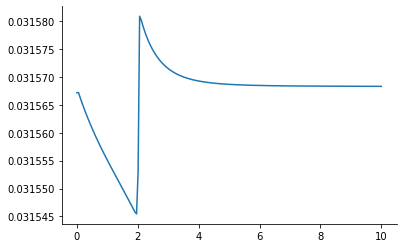

In [579]:
plt.plot(y_grid, h_star)

(0.0, 14.0)

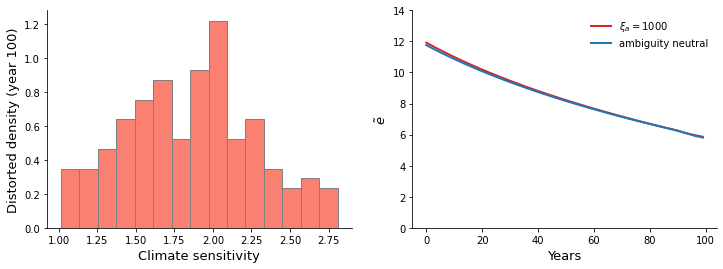

In [580]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.hist(θ_list*1000, weights=πt_rbt[-1], density=True, bins=15, color="salmon", ec="grey")
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)

ax2.plot(et_avg_no, color='C3', label=r'$\xi_a = 1000$', linewidth=2.)
ax2.plot(et_rbt, color='C0', label='ambiguity neutral', linewidth=2.)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel(r'$\tilde{e}$', fontsize=13)
ax2.legend(frameon=False, loc='upper right')
ax2.set_ylim(0, 14)

In [581]:
def simulate_traj_robust(y_grid, ems, π_mat, h_star, θ_list,  dt=1, T=100):
    # initiate
    periods = int(T/dt)
    ems_t = np.zeros(periods)
    y_t = np.zeros(periods)
    h_t = np.zeros(periods)
    π_t = np.zeros((periods, len(θ_list)))
    # interpolate
    get_π = interpolate.interp1d(y_grid, π_mat)
    y0 = θ_list.mean()*290
    y = y0
    for t in range(periods):
        ems_point = np.interp(y, y_grid, ems)
        h_point = np.interp(y, y_grid, h_star)
        π_list = get_π(y)
        ems_t[t] = ems_point
        h_t[t] = h_point
        π_t[t] = π_list
        dy = ems_point*(θ_list@π_list)*dt
        y = dy + y
        y_t[t] = y
    return y_t, ems_t, π_t, h_t

In [582]:
yt_rbt, et_rbt, πt_rbt, ht_rbt = simulate_traj_robust(y_grid, ems_rbt, π_rbt, h_star, θ_list)

Text(0, 0.5, 'Distorted density (year 100)')

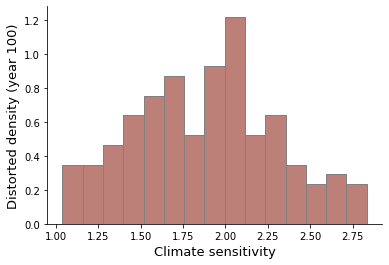

In [589]:
fig, ax1 = plt.subplots(1, 1,figsize=(6,4))
ax1.hist((θ_list + σy*ht_rbt[-1])*1000, weights=πt_rbt[-1], density=True, bins=15, color="salmon", ec="grey")
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)
ax1.hist((θ_list + σy*ht_rbt[0])*1000,  density=True, bins=15, color="grey", ec="grey", alpha=0.5)
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)

# Decompose ambiguity among climate models

#1 Partition over temp models

There are 16 temp models

In [682]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θtemp_list = list()
for i in range(n_temp):
    same_temp = θ_list[i*n_carb:i*n_carb+n_carb+1]
    θtemp_list.append(np.average(same_temp))

In [683]:
θtemp_list = np.array(θtemp_list)

In [684]:
ξₐ = 1/4000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θtemp_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_temp, ems_temp, π_temp = solve_smooth(y_grid, args)

episode: 1,	 ode error: 0.0016905139700299353,	 ft error: 0.0014429450445923454
episode: 2,	 ode error: 0.0014382102196991231,	 ft error: 0.0013062670314649347
episode: 3,	 ode error: 0.0013263740066758697,	 ft error: 0.0012381961558406527
episode: 4,	 ode error: 0.0012594120568700236,	 ft error: 0.001192680059854614
episode: 5,	 ode error: 0.0012099253851628826,	 ft error: 0.0011571374664771682
episode: 6,	 ode error: 0.0011697476756294806,	 ft error: 0.0011275457808082887
episode: 7,	 ode error: 0.0011357373093904043,	 ft error: 0.001100779670008078
episode: 8,	 ode error: 0.0011063001031302597,	 ft error: 0.0010768098291483378
episode: 9,	 ode error: 0.0010804324385910568,	 ft error: 0.0010557730890967728
episode: 10,	 ode error: 0.0010574261038513162,	 ft error: 0.001035859295955745
episode: 11,	 ode error: 0.0010367357667791996,	 ft error: 0.0010176160346474041
episode: 12,	 ode error: 0.0010179427842418433,	 ft error: 0.001000790544670238
episode: 13,	 ode error: 0.00100072137881

episode: 122,	 ode error: 0.0004607846733384191,	 ft error: 0.0004601308304624102
episode: 123,	 ode error: 0.00045844085894299557,	 ft error: 0.0004577947992324393
episode: 124,	 ode error: 0.0004561119176063413,	 ft error: 0.0004554734030281944
episode: 125,	 ode error: 0.0004537975605973843,	 ft error: 0.00045316635817851025
episode: 126,	 ode error: 0.0004514975056551896,	 ft error: 0.00045087338754066836
episode: 127,	 ode error: 0.00044921147701857734,	 ft error: 0.000448594220529124
episode: 128,	 ode error: 0.00044693920545579835,	 ft error: 0.00044632859314300743
episode: 129,	 ode error: 0.00044468042829331176,	 ft error: 0.0004440762479920637
episode: 130,	 ode error: 0.0004424348894425548,	 ft error: 0.0004418369343198748
episode: 131,	 ode error: 0.00044020233942383463,	 ft error: 0.0004396104080232657
episode: 132,	 ode error: 0.0004379825353865431,	 ft error: 0.00043739643166761566
episode: 133,	 ode error: 0.00043577524112479917,	 ft error: 0.0004351947744969317
episode

episode: 286,	 ode error: 0.00019629538436312377,	 ft error: 0.00019608690234410958
episode: 287,	 ode error: 0.00019526399871979175,	 ft error: 0.00019505754520379726
episode: 288,	 ode error: 0.00019423833336553646,	 ft error: 0.0001940338996902352
episode: 289,	 ode error: 0.00019321835922489667,	 ft error: 0.00019301593665937516
episode: 290,	 ode error: 0.0001922040472242592,	 ft error: 0.00019200362697174844
episode: 291,	 ode error: 0.000191195368296387,	 ft error: 0.00019099694149736965
episode: 292,	 ode error: 0.00019019229338484273,	 ft error: 0.00018999585112017733
episode: 293,	 ode error: 0.00018919479344825779,	 ft error: 0.0001890003267423825
episode: 294,	 ode error: 0.0001882028394645447,	 ft error: 0.00018801033928823874
episode: 295,	 ode error: 0.00018721640243495583,	 ft error: 0.00018702585970815921
episode: 296,	 ode error: 0.00018623545338798501,	 ft error: 0.00018604685898322704
episode: 297,	 ode error: 0.00018525996338329166,	 ft error: 0.0001850733081273463

episode: 451,	 ode error: 8.444957417618631e-05,	 ft error: 8.445802575245132e-05
episode: 452,	 ode error: 8.403149300654177e-05,	 ft error: 8.404066901108546e-05
episode: 453,	 ode error: 8.361560402583054e-05,	 ft error: 8.362549934658181e-05
episode: 454,	 ode error: 8.320189459417595e-05,	 ft error: 8.321250416221115e-05
episode: 455,	 ode error: 8.279035215351697e-05,	 ft error: 8.280167093273802e-05
episode: 456,	 ode error: 8.238096422711586e-05,	 ft error: 8.239298719935526e-05
episode: 457,	 ode error: 8.197371841885636e-05,	 ft error: 8.19864406133991e-05
episode: 458,	 ode error: 8.156860241280656e-05,	 ft error: 8.158201888428437e-05
episode: 459,	 ode error: 8.116560397262507e-05,	 ft error: 8.117970979907205e-05
episode: 460,	 ode error: 8.076471094105731e-05,	 ft error: 8.07795012270259e-05
episode: 461,	 ode error: 8.036591123925007e-05,	 ft error: 8.038138113578008e-05
episode: 462,	 ode error: 7.996919286633124e-05,	 ft error: 7.99853375453343e-05
episode: 463,	 ode 

episode: 616,	 ode error: 3.780802045176405e-05,	 ft error: 3.788415145355532e-05
episode: 617,	 ode error: 3.7626903473308776e-05,	 ft error: 3.770320149971511e-05
episode: 618,	 ode error: 3.744667494190912e-05,	 ft error: 3.752313765178576e-05
episode: 619,	 ode error: 3.726733024108275e-05,	 ft error: 3.7343955306481935e-05
episode: 620,	 ode error: 3.708886478066874e-05,	 ft error: 3.7165649864820405e-05
episode: 621,	 ode error: 3.691127399659986e-05,	 ft error: 3.6988216773730285e-05
episode: 622,	 ode error: 3.6734553350783235e-05,	 ft error: 3.6811651499199516e-05
episode: 623,	 ode error: 3.655869833086537e-05,	 ft error: 3.6635949533121256e-05
episode: 624,	 ode error: 3.638370445013285e-05,	 ft error: 3.646110640120419e-05
episode: 625,	 ode error: 3.6209567247330425e-05,	 ft error: 3.6287117642086475e-05
episode: 626,	 ode error: 3.6036282286483283e-05,	 ft error: 3.611397882537689e-05
episode: 627,	 ode error: 3.586384515678312e-05,	 ft error: 3.5941685531971454e-05
episo

episode: 781,	 ode error: 1.7198531196267373e-05,	 ft error: 1.7271701391943783e-05
episode: 782,	 ode error: 1.7116828113446594e-05,	 ft error: 1.7189780045269908e-05
episode: 783,	 ode error: 1.7035512587369457e-05,	 ft error: 1.7108243391359784e-05
episode: 784,	 ode error: 1.6954582735017915e-05,	 ft error: 1.7027089512580695e-05
episode: 785,	 ode error: 1.6874036683163832e-05,	 ft error: 1.6946316531452992e-05
episode: 786,	 ode error: 1.6793872568283226e-05,	 ft error: 1.6865922570543278e-05
episode: 787,	 ode error: 1.6714088536560275e-05,	 ft error: 1.6785905760259106e-05
episode: 788,	 ode error: 1.6634682743815656e-05,	 ft error: 1.6706264230267887e-05
episode: 789,	 ode error: 1.6555653355406473e-05,	 ft error: 1.6626996140698774e-05
episode: 790,	 ode error: 1.6476998546224408e-05,	 ft error: 1.654809964747132e-05
episode: 791,	 ode error: 1.6398716500652796e-05,	 ft error: 1.6469572913467106e-05
episode: 792,	 ode error: 1.632080541243326e-05,	 ft error: 1.639141412781986

episode: 943,	 ode error: 7.937203990768574e-06,	 ft error: 7.915902366512073e-06
episode: 944,	 ode error: 7.89929649509444e-06,	 ft error: 7.87677453315446e-06
episode: 945,	 ode error: 7.861569479695346e-06,	 ft error: 7.837812878534283e-06
episode: 946,	 ode error: 7.824022137324009e-06,	 ft error: 7.799016371624428e-06
episode: 947,	 ode error: 7.786653665327239e-06,	 ft error: 7.760383981467167e-06
episode: 948,	 ode error: 7.749463265643007e-06,	 ft error: 7.721914666603918e-06
episode: 949,	 ode error: 7.712450144810854e-06,	 ft error: 7.683607392954447e-06
episode: 950,	 ode error: 7.67561351403467e-06,	 ft error: 7.645461084712646e-06
episode: 951,	 ode error: 7.63895258903578e-06,	 ft error: 7.607474721629814e-06
episode: 952,	 ode error: 7.6024665902005035e-06,	 ft error: 7.569647225216802e-06
episode: 953,	 ode error: 7.566154742407339e-06,	 ft error: 7.531977575941928e-06
episode: 954,	 ode error: 7.530016275149689e-06,	 ft error: 7.4944647085462e-06
episode: 955,	 ode er

episode: 1104,	 ode error: 5.189749966527256e-06,	 ft error: 3.716816298256672e-06
episode: 1105,	 ode error: 5.167346821877139e-06,	 ft error: 3.6985518627139875e-06
episode: 1106,	 ode error: 5.145501375005605e-06,	 ft error: 3.6803850216500975e-06
episode: 1107,	 ode error: 5.124212417457607e-06,	 ft error: 3.662310750588797e-06
episode: 1108,	 ode error: 5.103475316293007e-06,	 ft error: 3.6443259774273282e-06
episode: 1109,	 ode error: 5.083282742351794e-06,	 ft error: 3.6264286434883886e-06
episode: 1110,	 ode error: 5.063625190497275e-06,	 ft error: 3.608617270186206e-06
episode: 1111,	 ode error: 5.044491398067258e-06,	 ft error: 3.5908907351315617e-06
episode: 1112,	 ode error: 5.025868697746902e-06,	 ft error: 3.5732481374478597e-06
episode: 1113,	 ode error: 5.007743320523529e-06,	 ft error: 3.555688727942726e-06
episode: 1114,	 ode error: 4.990100656963685e-06,	 ft error: 3.538211859263618e-06
episode: 1115,	 ode error: 4.972925482803518e-06,	 ft error: 3.5208169608484203e-

episode: 1258,	 ode error: 3.879854458017722e-06,	 ft error: 2.059098535266609e-06
episode: 1259,	 ode error: 3.875246938548629e-06,	 ft error: 2.0529390313874427e-06
episode: 1260,	 ode error: 3.870663634798104e-06,	 ft error: 2.046797824342232e-06
episode: 1261,	 ode error: 3.8661044300130785e-06,	 ft error: 2.0406748624477817e-06
episode: 1262,	 ode error: 3.861569208082492e-06,	 ft error: 2.034570090805876e-06
episode: 1263,	 ode error: 3.857057853407409e-06,	 ft error: 2.0284834580340067e-06
episode: 1264,	 ode error: 3.852570251020385e-06,	 ft error: 2.0224149106217357e-06
episode: 1265,	 ode error: 3.848106286508438e-06,	 ft error: 2.016364397868879e-06
episode: 1266,	 ode error: 3.8436658460624874e-06,	 ft error: 2.01033186293433e-06
episode: 1267,	 ode error: 3.8392488162845265e-06,	 ft error: 2.0043172588302127e-06
episode: 1268,	 ode error: 3.834855084498573e-06,	 ft error: 1.998320527096346e-06
episode: 1269,	 ode error: 3.830484538334337e-06,	 ft error: 1.9923416190216945e

episode: 1404,	 ode error: 3.3780768136866036e-06,	 ft error: 1.331561837273713e-06
episode: 1405,	 ode error: 3.377260327264999e-06,	 ft error: 1.327580104598658e-06
episode: 1406,	 ode error: 3.3764514875628065e-06,	 ft error: 1.3236120545550198e-06
episode: 1407,	 ode error: 3.371181366472627e-06,	 ft error: 1.980806821807087e-06
episode: 1408,	 ode error: 3.3391790832163447e-06,	 ft error: 1.3179343842650848e-06
episode: 1409,	 ode error: 3.339594754892786e-06,	 ft error: 1.3139919296153066e-06
episode: 1410,	 ode error: 3.3399990927105165e-06,	 ft error: 1.310065521944089e-06
episode: 1411,	 ode error: 3.3360039214868297e-06,	 ft error: 1.94130114636315e-06
episode: 1412,	 ode error: 3.3057722994981123e-06,	 ft error: 1.3044335580904751e-06
episode: 1413,	 ode error: 3.3072981955487393e-06,	 ft error: 1.300533736756556e-06
episode: 1414,	 ode error: 3.3044262426808343e-06,	 ft error: 1.9213336248380397e-06
episode: 1415,	 ode error: 3.2754385928354017e-06,	 ft error: 1.29495161452

episode: 1569,	 ode error: 2.4514813206163327e-06,	 ft error: 9.105416927853346e-07
episode: 1570,	 ode error: 2.4478414924142006e-06,	 ft error: 9.103270892883246e-07
episode: 1571,	 ode error: 2.444184229102018e-06,	 ft error: 9.101522530780004e-07
episode: 1572,	 ode error: 2.440509556600782e-06,	 ft error: 9.100171335929552e-07
episode: 1573,	 ode error: 2.4368174875674686e-06,	 ft error: 9.099215991329828e-07
episode: 1574,	 ode error: 2.4331080226141642e-06,	 ft error: 9.098659738369468e-07
episode: 1575,	 ode error: 2.42938113956205e-06,	 ft error: 9.098502933476323e-07
episode: 1576,	 ode error: 2.42563680249373e-06,	 ft error: 9.098745936547692e-07
episode: 1577,	 ode error: 2.421874962289371e-06,	 ft error: 9.099389717178349e-07
episode: 1578,	 ode error: 2.4180955554445414e-06,	 ft error: 9.100435864143701e-07
episode: 1579,	 ode error: 2.4142985030654266e-06,	 ft error: 9.101886085336834e-07
episode: 1580,	 ode error: 2.410483712329142e-06,	 ft error: 9.103739627193871e-07


episode: 1735,	 ode error: 2.3947727605051804e-06,	 ft error: 5.175240013153652e-07
episode: 1736,	 ode error: 2.3944415423187305e-06,	 ft error: 5.177757262178617e-07
episode: 1737,	 ode error: 2.394096315452485e-06,	 ft error: 5.179808556845152e-07
episode: 1738,	 ode error: 2.393737510125618e-06,	 ft error: 5.18143391444829e-07
episode: 1739,	 ode error: 2.3933655485619087e-06,	 ft error: 5.18258125141909e-07
episode: 1740,	 ode error: 2.3929808452658884e-06,	 ft error: 5.183261656919551e-07
episode: 1741,	 ode error: 2.3925838064379123e-06,	 ft error: 5.183486691146915e-07
episode: 1742,	 ode error: 2.392174830497505e-06,	 ft error: 5.183267495883123e-07
episode: 1743,	 ode error: 2.391754308046822e-06,	 ft error: 5.182614998151351e-07
episode: 1744,	 ode error: 2.3913226219161865e-06,	 ft error: 5.181539972550405e-07
episode: 1745,	 ode error: 2.3908801474619747e-06,	 ft error: 5.180052508810262e-07
episode: 1746,	 ode error: 2.390427252226175e-06,	 ft error: 5.178162923215787e-07

episode: 1901,	 ode error: 2.530153593227754e-06,	 ft error: 3.562244806192457e-07
episode: 1902,	 ode error: 2.5308056420240586e-06,	 ft error: 3.5537138014703673e-07
episode: 1903,	 ode error: 2.5314578214126232e-06,	 ft error: 3.545190339557247e-07
episode: 1904,	 ode error: 2.5321099889504244e-06,	 ft error: 3.5366722614162593e-07
episode: 1905,	 ode error: 2.532761998774865e-06,	 ft error: 3.528157182496513e-07
episode: 1906,	 ode error: 2.533413700901211e-06,	 ft error: 3.519642933352829e-07
episode: 1907,	 ode error: 2.534064942295031e-06,	 ft error: 3.5111274274598114e-07
episode: 1908,	 ode error: 2.5347155672945454e-06,	 ft error: 3.5026085649925154e-07
episode: 1909,	 ode error: 2.535365417579295e-06,	 ft error: 3.494084164825292e-07
episode: 1910,	 ode error: 2.5360143319331867e-06,	 ft error: 3.4855520769418635e-07
episode: 1911,	 ode error: 2.5366621465572337e-06,	 ft error: 3.477010346077577e-07
episode: 1912,	 ode error: 2.53730869586693e-06,	 ft error: 3.46845688547573

episode: 2067,	 ode error: 2.5462137664877186e-06,	 ft error: 1.6843548109509351e-07
episode: 2068,	 ode error: 2.545713602814057e-06,	 ft error: 1.674497885027308e-07
episode: 2069,	 ode error: 2.5452159309346015e-06,	 ft error: 1.664777565223615e-07
episode: 2070,	 ode error: 2.54472104867855e-06,	 ft error: 1.6552267990271874e-07
episode: 2071,	 ode error: 2.5442292493331074e-06,	 ft error: 1.6458102210931136e-07
episode: 2072,	 ode error: 2.543740821630148e-06,	 ft error: 1.6365285851009198e-07
episode: 2073,	 ode error: 2.543256048421485e-06,	 ft error: 1.627382753670766e-07
episode: 2074,	 ode error: 2.542775207493809e-06,	 ft error: 1.6183736573083252e-07
episode: 2075,	 ode error: 2.542298571859365e-06,	 ft error: 1.609501789947195e-07
episode: 2076,	 ode error: 2.5418264079260337e-06,	 ft error: 1.6007673804552258e-07
episode: 2077,	 ode error: 2.541358974823989e-06,	 ft error: 1.5921709492494607e-07
episode: 2078,	 ode error: 2.5408965258177083e-06,	 ft error: 1.5837126606660

episode: 2233,	 ode error: 2.5355099408725843e-06,	 ft error: 1.0308474410886115e-07
episode: 2234,	 ode error: 2.535612142059117e-06,	 ft error: 1.0281946418120673e-07
episode: 2235,	 ode error: 2.5357143207210787e-06,	 ft error: 1.0255511324423298e-07
episode: 2236,	 ode error: 2.535816506218881e-06,	 ft error: 1.0229174244915282e-07
episode: 2237,	 ode error: 2.535918729060509e-06,	 ft error: 1.0202939691034141e-07
episode: 2238,	 ode error: 2.5360210205639016e-06,	 ft error: 1.0176811657269802e-07
episode: 2239,	 ode error: 2.5361234126479166e-06,	 ft error: 1.015079490717293e-07
episode: 2240,	 ode error: 2.5362259381286434e-06,	 ft error: 1.0124893648026194e-07
episode: 2241,	 ode error: 2.5363286304716623e-06,	 ft error: 1.009911249881997e-07
episode: 2242,	 ode error: 2.536431523831727e-06,	 ft error: 1.0073454154158057e-07
episode: 2243,	 ode error: 2.536534652335619e-06,	 ft error: 1.0047923819367366e-07
episode: 2244,	 ode error: 2.5366380511106755e-06,	 ft error: 1.00225251

episode: 2397,	 ode error: 2.5662248736512913e-06,	 ft error: 7.730366958826526e-08
episode: 2398,	 ode error: 2.566455283617517e-06,	 ft error: 7.715267585685823e-08
episode: 2399,	 ode error: 2.5666844738523415e-06,	 ft error: 7.700029159424249e-08
episode: 2400,	 ode error: 2.566912416051366e-06,	 ft error: 7.684653770961836e-08
episode: 2401,	 ode error: 2.567139083474641e-06,	 ft error: 7.669140048710554e-08
episode: 2402,	 ode error: 2.5673644496593934e-06,	 ft error: 7.653491080478192e-08
episode: 2403,	 ode error: 2.5675884900357594e-06,	 ft error: 7.637705136167203e-08
episode: 2404,	 ode error: 2.567811180007528e-06,	 ft error: 7.621784426971775e-08
episode: 2405,	 ode error: 2.5680324963783027e-06,	 ft error: 7.605726783331083e-08
episode: 2406,	 ode error: 2.568252415668113e-06,	 ft error: 7.589534461542129e-08
episode: 2407,	 ode error: 2.5684709158725876e-06,	 ft error: 7.573207174797296e-08
episode: 2408,	 ode error: 2.568687975443209e-06,	 ft error: 7.556746833605374e-0

episode: 2559,	 ode error: 2.5860680779060566e-06,	 ft error: 4.6679826647596144e-08
episode: 2560,	 ode error: 2.586127631431525e-06,	 ft error: 4.65199624076947e-08
episode: 2561,	 ode error: 2.5861869298872105e-06,	 ft error: 4.636064392336363e-08
episode: 2562,	 ode error: 2.5862459728992807e-06,	 ft error: 4.620185396301639e-08
episode: 2563,	 ode error: 2.5863047596074752e-06,	 ft error: 4.604365740531099e-08
episode: 2564,	 ode error: 2.5863632899662033e-06,	 ft error: 4.588621716391147e-08
episode: 2565,	 ode error: 2.5864215626710614e-06,	 ft error: 4.5729281761737926e-08
episode: 2566,	 ode error: 2.5864795762911737e-06,	 ft error: 4.5572869540599914e-08
episode: 2567,	 ode error: 2.5865373302822164e-06,	 ft error: 4.541695834229624e-08
episode: 2568,	 ode error: 2.586594823254676e-06,	 ft error: 4.5261542095294725e-08
episode: 2569,	 ode error: 2.5866520537172325e-06,	 ft error: 4.5106615167526495e-08
episode: 2570,	 ode error: 2.586709020007533e-06,	 ft error: 4.49521571933

episode: 2717,	 ode error: 2.591596976584678e-06,	 ft error: 2.6312673683433672e-08
episode: 2718,	 ode error: 2.5916160779995722e-06,	 ft error: 2.622088013150744e-08
episode: 2719,	 ode error: 2.591635275225575e-06,	 ft error: 2.6129691755213034e-08
episode: 2720,	 ode error: 2.5916545743656064e-06,	 ft error: 2.6039089912055502e-08
episode: 2721,	 ode error: 2.5916739805900636e-06,	 ft error: 2.5949080719826306e-08
episode: 2722,	 ode error: 2.5916934993403407e-06,	 ft error: 2.5859672840577996e-08
episode: 2723,	 ode error: 2.5917131363819537e-06,	 ft error: 2.5770865927365882e-08
episode: 2724,	 ode error: 2.591732897170879e-06,	 ft error: 2.5682629518445726e-08
episode: 2725,	 ode error: 2.591752785934475e-06,	 ft error: 2.5595003743753935e-08
episode: 2726,	 ode error: 2.5917728086556407e-06,	 ft error: 2.5507975419392093e-08
episode: 2727,	 ode error: 2.5917929705447803e-06,	 ft error: 2.5421534761519798e-08
episode: 2728,	 ode error: 2.591813276251007e-06,	 ft error: 2.5335676

episode: 2882,	 ode error: 2.596884141532936e-06,	 ft error: 1.6638728277118542e-08
episode: 2883,	 ode error: 2.5969213865219298e-06,	 ft error: 1.6596278899772e-08
episode: 2884,	 ode error: 2.5969585766363076e-06,	 ft error: 1.655391237281867e-08
episode: 2885,	 ode error: 2.5969957111606043e-06,	 ft error: 1.6511632940548658e-08
episode: 2886,	 ode error: 2.597032789563127e-06,	 ft error: 1.646943265792844e-08
episode: 2887,	 ode error: 2.597069810984158e-06,	 ft error: 1.6427314925016034e-08
episode: 2888,	 ode error: 2.5971067748242955e-06,	 ft error: 1.638528860046599e-08
episode: 2889,	 ode error: 2.5971436808610616e-06,	 ft error: 1.6343343657576614e-08
episode: 2890,	 ode error: 2.5971805284476213e-06,	 ft error: 1.6301484849490233e-08
episode: 2891,	 ode error: 2.5972173171360906e-06,	 ft error: 1.6259704080830627e-08
episode: 2892,	 ode error: 2.5972540462649435e-06,	 ft error: 1.6218022145149856e-08
episode: 2893,	 ode error: 2.5972907161145547e-06,	 ft error: 1.6176429813

episode: 3047,	 ode error: 2.6022296250159823e-06,	 ft error: 1.0785486658874504e-08
episode: 3048,	 ode error: 2.6022557779554426e-06,	 ft error: 1.0754923387053713e-08
episode: 3049,	 ode error: 2.6022818190497453e-06,	 ft error: 1.0724398047852931e-08
episode: 3050,	 ode error: 2.602307748288807e-06,	 ft error: 1.0693900626135289e-08
episode: 3051,	 ode error: 2.6023335650379362e-06,	 ft error: 1.0663408420152898e-08
episode: 3052,	 ode error: 2.6023592678223466e-06,	 ft error: 1.0632952955613728e-08
episode: 3053,	 ode error: 2.602384856647134e-06,	 ft error: 1.06025247609276e-08
episode: 3054,	 ode error: 2.6024103311106557e-06,	 ft error: 1.0572128832098127e-08
episode: 3055,	 ode error: 2.6024356909747125e-06,	 ft error: 1.0541752875718274e-08
episode: 3056,	 ode error: 2.602460935517497e-06,	 ft error: 1.0511409081111664e-08
episode: 3057,	 ode error: 2.602486064534745e-06,	 ft error: 1.0481084923574802e-08
episode: 3058,	 ode error: 2.6025110772292972e-06,	 ft error: 1.0450780

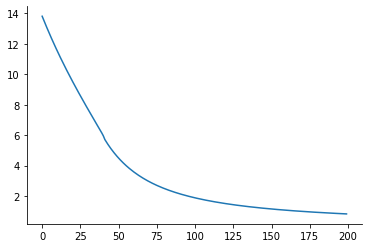

In [685]:
plt.plot(ems_temp)

In [686]:
yt_temp, et_temp, πt_temp = simulate_traj(y_grid, ems_temp, π_temp, θtemp_list)

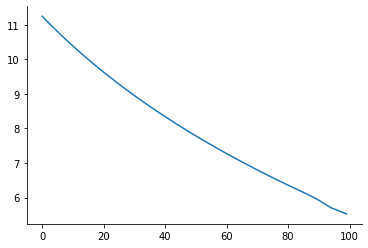

In [687]:
plt.plot(et_temp)

#2 Partition over carbon models

There are 9 carbon models.

In [688]:
θcarb_list = list()
for i in range(n_carb):
    idx_carb = np.arange(i, n_θ+i, n_carb)
    same_carb = θ_list[idx_carb]
    θcarb_list.append(np.average(same_carb))

In [689]:
θcarb_list = np.array(θcarb_list)

In [701]:
ξₐ = 1/4000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θcarb_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_carb, ems_carb, π_carb = solve_smooth(y_grid, args)

episode: 1,	 ode error: 0.0016934891562814382,	 ft error: 0.0014480394288089702
episode: 2,	 ode error: 0.001446589953996824,	 ft error: 0.0013149026842830312
episode: 3,	 ode error: 0.0013337983489367532,	 ft error: 0.0012463249835247474
episode: 4,	 ode error: 0.0012666252863122371,	 ft error: 0.0012004722275093744
episode: 5,	 ode error: 0.001217271403667099,	 ft error: 0.0011648105473007287
episode: 6,	 ode error: 0.0011772834408547274,	 ft error: 0.0011352290529240154
episode: 7,	 ode error: 0.0011434283855367177,	 ft error: 0.0011084854767994905
episode: 8,	 ode error: 0.0011140939438547787,	 ft error: 0.0010845429700009628
episode: 9,	 ode error: 0.001088283348551581,	 ft error: 0.001063550329484823
episode: 10,	 ode error: 0.001065301449305613,	 ft error: 0.0010436397487707414
episode: 11,	 ode error: 0.0010446135205844597,	 ft error: 0.0010253906762552932
episode: 12,	 ode error: 0.0010258091028447335,	 ft error: 0.0010085523659657822
episode: 13,	 ode error: 0.001008567980806

episode: 127,	 ode error: 0.00045471251488492963,	 ft error: 0.00045407699312819083
episode: 128,	 ode error: 0.00045242328549657666,	 ft error: 0.0004517945061137743
episode: 129,	 ode error: 0.0004501475959630633,	 ft error: 0.0004495253483774442
episode: 130,	 ode error: 0.0004478851906281198,	 ft error: 0.0004472692696125963
episode: 131,	 ode error: 0.00044563582046410583,	 ft error: 0.0004450260261796314
episode: 132,	 ode error: 0.0004433992430896064,	 ft error: 0.0004427953811185608
episode: 133,	 ode error: 0.00044117522278260305,	 ft error: 0.0004405771041568705
episode: 134,	 ode error: 0.000438963530488282,	 ft error: 0.0004383709717111171
episode: 135,	 ode error: 0.00043676394382106455,	 ft error: 0.0004361767668828338
episode: 136,	 ode error: 0.0004345762470602673,	 ft error: 0.0004339942794474745
episode: 137,	 ode error: 0.00043240023113885,	 ft error: 0.00043182330583616446
episode: 138,	 ode error: 0.00043023569362507725,	 ft error: 0.0004296636491101652
episode: 13

episode: 259,	 ode error: 0.0002301094556483175,	 ft error: 0.00022983853099417068
episode: 260,	 ode error: 0.00022890188089217376,	 ft error: 0.00022863323350952777
episode: 261,	 ode error: 0.0002277008226511429,	 ft error: 0.0002274344466909421
episode: 262,	 ode error: 0.0002265062538558206,	 ft error: 0.00022624214329536782
episode: 263,	 ode error: 0.00022531814726960706,	 ft error: 0.00022505629591775916
episode: 264,	 ode error: 0.00022413647549673443,	 ft error: 0.00022387687699856423
episode: 265,	 ode error: 0.00022296121099017274,	 ft error: 0.0002227038588318899
episode: 266,	 ode error: 0.00022179232605943234,	 ft error: 0.00022153721357329645
episode: 267,	 ode error: 0.00022062979287822983,	 ft error: 0.00022037691324703718
episode: 268,	 ode error: 0.00021947358349197867,	 ft error: 0.00021922292975417684
episode: 269,	 ode error: 0.00021832366982522358,	 ft error: 0.00021807523487883673
episode: 270,	 ode error: 0.0002171800236888911,	 ft error: 0.0002169338002968683

episode: 391,	 ode error: 0.00011657338032598557,	 ft error: 0.00011652791411037126
episode: 392,	 ode error: 0.00011598971650329673,	 ft error: 0.00011594537708212635
episode: 393,	 ode error: 0.00011540919724264216,	 ft error: 0.0001153659772734859
episode: 394,	 ode error: 0.00011483180386993592,	 ft error: 0.00011478969604937958
episode: 395,	 ode error: 0.00011425751782715441,	 ft error: 0.00011421651489720852
episode: 396,	 ode error: 0.00011368632067188054,	 ft error: 0.00011364641541428597
episode: 397,	 ode error: 0.00011311819407680318,	 ft error: 0.00011307937931653393
episode: 398,	 ode error: 0.00011255311982920758,	 ft error: 0.00011251538843374173
episode: 399,	 ode error: 0.00011199107983048248,	 ft error: 0.00011195442471005161
episode: 400,	 ode error: 0.0001114320560956487,	 ft error: 0.00011139647020074381
episode: 401,	 ode error: 0.00011087603075279992,	 ft error: 0.00011084150707586782
episode: 402,	 ode error: 0.00011032298604258715,	 ft error: 0.000110289517619

episode: 523,	 ode error: 6.0952875927953076e-05,	 ft error: 6.100671862324658e-05
episode: 524,	 ode error: 6.065962670995717e-05,	 ft error: 6.071393259032831e-05
episode: 525,	 ode error: 6.0367853287261785e-05,	 ft error: 6.042261908751716e-05
episode: 526,	 ode error: 6.007754760730007e-05,	 ft error: 6.013277008489378e-05
episode: 527,	 ode error: 5.978870166675049e-05,	 ft error: 5.984437759259942e-05
episode: 528,	 ode error: 5.950130751118351e-05,	 ft error: 5.955743367728102e-05
episode: 529,	 ode error: 5.921535723472395e-05,	 ft error: 5.927193044911554e-05
episode: 530,	 ode error: 5.8930842979719564e-05,	 ft error: 5.898786006673651e-05
episode: 531,	 ode error: 5.864775693639008e-05,	 ft error: 5.870521473371841e-05
episode: 532,	 ode error: 5.8366091342525574e-05,	 ft error: 5.842398671000264e-05
episode: 533,	 ode error: 5.8085838483066653e-05,	 ft error: 5.814416829704831e-05
episode: 534,	 ode error: 5.780699068987972e-05,	 ft error: 5.786575184597391e-05
episode: 53

episode: 654,	 ode error: 3.264441575380299e-05,	 ft error: 3.2736048350689995e-05
episode: 655,	 ode error: 3.249060852824671e-05,	 ft error: 3.258237902735902e-05
episode: 656,	 ode error: 3.233754154434378e-05,	 ft error: 3.242944791835567e-05
episode: 657,	 ode error: 3.218521104524975e-05,	 ft error: 3.2277251258358564e-05
episode: 658,	 ode error: 3.2033613294844376e-05,	 ft error: 3.212578531468224e-05
episode: 659,	 ode error: 3.1882744577698004e-05,	 ft error: 3.197504637104017e-05
episode: 660,	 ode error: 3.173260119884811e-05,	 ft error: 3.182503074102931e-05
episode: 661,	 ode error: 3.158317948374857e-05,	 ft error: 3.167573474909443e-05
episode: 662,	 ode error: 3.143447577814832e-05,	 ft error: 3.152715473857722e-05
episode: 663,	 ode error: 3.128648644793483e-05,	 ft error: 3.137928707030539e-05
episode: 664,	 ode error: 3.11392078789865e-05,	 ft error: 3.123212814667061e-05
episode: 665,	 ode error: 3.099263647708857e-05,	 ft error: 3.1085674367173355e-05
episode: 666

episode: 786,	 ode error: 1.755100266318129e-05,	 ft error: 1.7642297304165666e-05
episode: 787,	 ode error: 1.7468899811837104e-05,	 ft error: 1.7560025013009982e-05
episode: 788,	 ode error: 1.7387181962226755e-05,	 ft error: 1.7478134475233203e-05
episode: 789,	 ode error: 1.7305847260211437e-05,	 ft error: 1.7396623811805994e-05
episode: 790,	 ode error: 1.7224893861252847e-05,	 ft error: 1.731549115200256e-05
episode: 791,	 ode error: 1.714431993039367e-05,	 ft error: 1.7234734623986874e-05
episode: 792,	 ode error: 1.7064123642176153e-05,	 ft error: 1.7154352381550574e-05
episode: 793,	 ode error: 1.6984303180606107e-05,	 ft error: 1.7074342571315092e-05
episode: 794,	 ode error: 1.6904856739085694e-05,	 ft error: 1.6994703354427286e-05
episode: 795,	 ode error: 1.682578252037905e-05,	 ft error: 1.6915432906004318e-05
episode: 796,	 ode error: 1.674707873653065e-05,	 ft error: 1.6836529409883227e-05
episode: 797,	 ode error: 1.6668743608848824e-05,	 ft error: 1.6757991049854797e-

episode: 918,	 ode error: 9.44973424951332e-06,	 ft error: 9.466346512545151e-06
episode: 919,	 ode error: 9.405498681174787e-06,	 ft error: 9.420721093639228e-06
episode: 920,	 ode error: 9.36147119123907e-06,	 ft error: 9.375276941517297e-06
episode: 921,	 ode error: 9.317650883078343e-06,	 ft error: 9.330012442794005e-06
episode: 922,	 ode error: 9.274036866657276e-06,	 ft error: 9.284925937709059e-06
episode: 923,	 ode error: 9.230628258636892e-06,	 ft error: 9.240015720312264e-06
episode: 924,	 ode error: 9.18742418225954e-06,	 ft error: 9.195280123696267e-06
episode: 925,	 ode error: 9.14442376748507e-06,	 ft error: 9.150717428634455e-06
episode: 926,	 ode error: 9.101626151108359e-06,	 ft error: 9.106325863187752e-06
episode: 927,	 ode error: 9.059030476733939e-06,	 ft error: 9.062103665015883e-06
episode: 928,	 ode error: 9.016635894980589e-06,	 ft error: 9.018049001302542e-06
episode: 929,	 ode error: 8.974441563563409e-06,	 ft error: 8.974159993989836e-06
episode: 930,	 ode e

episode: 1048,	 ode error: 5.858503044720378e-06,	 ft error: 5.142503369202449e-06
episode: 1049,	 ode error: 5.843104733452547e-06,	 ft error: 5.118097983550229e-06
episode: 1050,	 ode error: 5.827883620794126e-06,	 ft error: 5.09380440200565e-06
episode: 1051,	 ode error: 5.812832768380409e-06,	 ft error: 5.06962217053375e-06
episode: 1052,	 ode error: 5.797945574413622e-06,	 ft error: 5.045550837366279e-06
episode: 1053,	 ode error: 5.783215762759908e-06,	 ft error: 5.0215899497172796e-06
episode: 1054,	 ode error: 5.76863737172074e-06,	 ft error: 4.99773905056807e-06
episode: 1055,	 ode error: 5.754204742561731e-06,	 ft error: 4.973997689908249e-06
episode: 1056,	 ode error: 5.739912507563157e-06,	 ft error: 4.950365413980418e-06
episode: 1057,	 ode error: 5.7257555783322045e-06,	 ft error: 4.926841771432655e-06
episode: 1058,	 ode error: 5.711729134061057e-06,	 ft error: 4.9034262891943054e-06
episode: 1059,	 ode error: 5.69782861029386e-06,	 ft error: 4.880118538696151e-06
episod

episode: 1179,	 ode error: 4.045947210814063e-06,	 ft error: 3.0320041938490068e-06
episode: 1180,	 ode error: 4.038775254893042e-06,	 ft error: 3.0173785348780457e-06
episode: 1181,	 ode error: 4.031630544849992e-06,	 ft error: 3.0028383276222335e-06
episode: 1182,	 ode error: 4.0245132892606375e-06,	 ft error: 2.9883830691967983e-06
episode: 1183,	 ode error: 4.0174236727501885e-06,	 ft error: 2.9740124853303946e-06
episode: 1184,	 ode error: 4.010361852097694e-06,	 ft error: 2.9597260468629725e-06
episode: 1185,	 ode error: 4.003327964545748e-06,	 ft error: 2.94552338182356e-06
episode: 1186,	 ode error: 3.996322124572222e-06,	 ft error: 2.9314041492811693e-06
episode: 1187,	 ode error: 3.989344424687859e-06,	 ft error: 2.917367954158312e-06
episode: 1188,	 ode error: 3.982394937944412e-06,	 ft error: 2.9034145126079678e-06
episode: 1189,	 ode error: 3.975473716565461e-06,	 ft error: 2.889543420347048e-06
episode: 1190,	 ode error: 3.9685807962539996e-06,	 ft error: 2.87575438732978

episode: 1311,	 ode error: 3.3227738553264375e-06,	 ft error: 1.6528510627759434e-06
episode: 1312,	 ode error: 3.319389105583149e-06,	 ft error: 1.6439866975387352e-06
episode: 1313,	 ode error: 3.3160495736109024e-06,	 ft error: 1.6351196476434757e-06
episode: 1314,	 ode error: 3.3127549588686392e-06,	 ft error: 1.626251360150229e-06
episode: 1315,	 ode error: 3.309504909389965e-06,	 ft error: 1.6173832531144832e-06
episode: 1316,	 ode error: 3.306299024738251e-06,	 ft error: 1.608516804682547e-06
episode: 1317,	 ode error: 3.3031368564076817e-06,	 ft error: 1.599653533292574e-06
episode: 1318,	 ode error: 3.3000179092559185e-06,	 ft error: 1.5907948835991448e-06
episode: 1319,	 ode error: 3.2969416456602807e-06,	 ft error: 1.5819423433705015e-06
episode: 1320,	 ode error: 3.293907486190276e-06,	 ft error: 1.5730974440436585e-06
episode: 1321,	 ode error: 3.2909148109405185e-06,	 ft error: 1.5642615918548541e-06
episode: 1322,	 ode error: 3.287962964772413e-06,	 ft error: 1.555436275

episode: 1443,	 ode error: 3.05125423611123e-06,	 ft error: 1.098758291654308e-06
episode: 1444,	 ode error: 3.0496553979295895e-06,	 ft error: 1.0954739899926569e-06
episode: 1445,	 ode error: 3.04806087849936e-06,	 ft error: 1.0921954884020777e-06
episode: 1446,	 ode error: 3.0464707101284655e-06,	 ft error: 1.0889228810780547e-06
episode: 1447,	 ode error: 3.044884925331587e-06,	 ft error: 1.0856562763020272e-06
episode: 1448,	 ode error: 3.0433035573298713e-06,	 ft error: 1.0823957664769328e-06
episode: 1449,	 ode error: 3.041726639527913e-06,	 ft error: 1.0791414542058824e-06
episode: 1450,	 ode error: 3.040154205908403e-06,	 ft error: 1.0758934332333325e-06
episode: 1451,	 ode error: 3.038586290721396e-06,	 ft error: 1.0726517983330095e-06
episode: 1452,	 ode error: 3.0370229285869854e-06,	 ft error: 1.0694166468922888e-06
episode: 1453,	 ode error: 3.035464154601121e-06,	 ft error: 1.0661880706317832e-06
episode: 1454,	 ode error: 3.0339100041824104e-06,	 ft error: 1.06296616574

episode: 1575,	 ode error: 2.889436991619491e-06,	 ft error: 7.36531903082945e-07
episode: 1576,	 ode error: 2.8886241368420796e-06,	 ft error: 7.343432181436405e-07
episode: 1577,	 ode error: 2.8878166215685723e-06,	 ft error: 7.32161091846854e-07
episode: 1578,	 ode error: 2.8870144015846625e-06,	 ft error: 7.299854861443171e-07
episode: 1579,	 ode error: 2.886217432933216e-06,	 ft error: 7.278163501623729e-07
episode: 1580,	 ode error: 2.8854256714092507e-06,	 ft error: 7.256536375145155e-07
episode: 1581,	 ode error: 2.884639072804531e-06,	 ft error: 7.234973115286907e-07
episode: 1582,	 ode error: 2.883857593194558e-06,	 ft error: 7.213473202094534e-07
episode: 1583,	 ode error: 2.8830811883885513e-06,	 ft error: 7.192036236697286e-07
episode: 1584,	 ode error: 2.882309814416801e-06,	 ft error: 7.170661838959425e-07
episode: 1585,	 ode error: 2.8815434275664435e-06,	 ft error: 7.149349577050453e-07
episode: 1586,	 ode error: 2.880781984163864e-06,	 ft error: 7.128099022493672e-07


episode: 1707,	 ode error: 2.8158997422349057e-06,	 ft error: 4.955197892055526e-07
episode: 1708,	 ode error: 2.8155477155143065e-06,	 ft error: 4.94035380394405e-07
episode: 1709,	 ode error: 2.815198422712159e-06,	 ft error: 4.925557867824226e-07
episode: 1710,	 ode error: 2.8148518590482164e-06,	 ft error: 4.910809935550672e-07
episode: 1711,	 ode error: 2.814508019477794e-06,	 ft error: 4.89610992767305e-07
episode: 1712,	 ode error: 2.81416689892856e-06,	 ft error: 4.881457681243003e-07
episode: 1713,	 ode error: 2.8138284920063922e-06,	 ft error: 4.866853093911846e-07
episode: 1714,	 ode error: 2.813492793237696e-06,	 ft error: 4.852296029561609e-07
episode: 1715,	 ode error: 2.813159796953937e-06,	 ft error: 4.837786385496664e-07
episode: 1716,	 ode error: 2.8128294974047235e-06,	 ft error: 4.823324004551063e-07
episode: 1717,	 ode error: 2.8125018885586392e-06,	 ft error: 4.808908744824425e-07
episode: 1718,	 ode error: 2.8121769641761005e-06,	 ft error: 4.794540466960633e-07


episode: 1839,	 ode error: 2.789403825177619e-06,	 ft error: 3.352349795214075e-07
episode: 1840,	 ode error: 2.7893200550528846e-06,	 ft error: 3.342482294763083e-07
episode: 1841,	 ode error: 2.7892374913542767e-06,	 ft error: 3.3326427402446956e-07
episode: 1842,	 ode error: 2.78915612416926e-06,	 ft error: 3.3228310867874e-07
episode: 1843,	 ode error: 2.7890759438676258e-06,	 ft error: 3.3130472447638154e-07
episode: 1844,	 ode error: 2.7889969408871444e-06,	 ft error: 3.303291080137642e-07
episode: 1845,	 ode error: 2.78891910559327e-06,	 ft error: 3.2935625474591246e-07
episode: 1846,	 ode error: 2.788842428605269e-06,	 ft error: 3.283861526685398e-07
episode: 1847,	 ode error: 2.788766900541106e-06,	 ft error: 3.274187999775339e-07
episode: 1848,	 ode error: 2.7886925123344654e-06,	 ft error: 3.264541794297434e-07
episode: 1849,	 ode error: 2.7886192546992643e-06,	 ft error: 3.254922907013532e-07
episode: 1850,	 ode error: 2.7885471187550194e-06,	 ft error: 3.245331216261693e-0

episode: 1971,	 ode error: 2.786132461317912e-06,	 ft error: 2.2666308088549933e-07
episode: 1972,	 ode error: 2.7861526399041445e-06,	 ft error: 2.2598974703154825e-07
episode: 1973,	 ode error: 2.786173317652829e-06,	 ft error: 2.2531882406158962e-07
episode: 1974,	 ode error: 2.786194491179411e-06,	 ft error: 2.2465036354316997e-07
episode: 1975,	 ode error: 2.7862161570181305e-06,	 ft error: 2.2398386372487108e-07
episode: 1976,	 ode error: 2.786238311702034e-06,	 ft error: 2.233193171820765e-07
episode: 1977,	 ode error: 2.7862609517158125e-06,	 ft error: 2.2265672076915433e-07
episode: 1978,	 ode error: 2.7862840736705757e-06,	 ft error: 2.2199607073910185e-07
episode: 1979,	 ode error: 2.786307674245629e-06,	 ft error: 2.213373586727278e-07
episode: 1980,	 ode error: 2.786331750009364e-06,	 ft error: 2.206805787991854e-07
episode: 1981,	 ode error: 2.7863562975456767e-06,	 ft error: 2.2002572678166596e-07
episode: 1982,	 ode error: 2.7863813134712057e-06,	 ft error: 2.1937279283

episode: 2103,	 ode error: 2.7919334099231734e-06,	 ft error: 1.5299952566457295e-07
episode: 2104,	 ode error: 2.7919935793726744e-06,	 ft error: 1.5254345572581393e-07
episode: 2105,	 ode error: 2.792053896044579e-06,	 ft error: 1.5208919280224054e-07
episode: 2106,	 ode error: 2.7921143584027893e-06,	 ft error: 1.5163641417746215e-07
episode: 2107,	 ode error: 2.792174964671491e-06,	 ft error: 1.5118496556517277e-07
episode: 2108,	 ode error: 2.7922357133154533e-06,	 ft error: 1.5073483807202342e-07
episode: 2109,	 ode error: 2.7922966026320455e-06,	 ft error: 1.502860343116641e-07
episode: 2110,	 ode error: 2.792357631179604e-06,	 ft error: 1.498385483629054e-07
episode: 2111,	 ode error: 2.792418797428536e-06,	 ft error: 1.4939237602771643e-07
episode: 2112,	 ode error: 2.7924800998133624e-06,	 ft error: 1.489475104944164e-07
episode: 2113,	 ode error: 2.792541536688806e-06,	 ft error: 1.4850395490863719e-07
episode: 2114,	 ode error: 2.7926031066913748e-06,	 ft error: 1.480617020

episode: 2234,	 ode error: 2.800587659735178e-06,	 ft error: 1.034841870412954e-07
episode: 2235,	 ode error: 2.80065655165751e-06,	 ft error: 1.0317596314350179e-07
episode: 2236,	 ode error: 2.8007254452088555e-06,	 ft error: 1.0286865208033089e-07
episode: 2237,	 ode error: 2.800794339624527e-06,	 ft error: 1.0256224678567571e-07
episode: 2238,	 ode error: 2.8008632339929273e-06,	 ft error: 1.0225675022013103e-07
episode: 2239,	 ode error: 2.8009321276339363e-06,	 ft error: 1.0195215716796158e-07
episode: 2240,	 ode error: 2.8010010197673622e-06,	 ft error: 1.0164846589444387e-07
episode: 2241,	 ode error: 2.801069909647491e-06,	 ft error: 1.0134567138044467e-07
episode: 2242,	 ode error: 2.8011387964452326e-06,	 ft error: 1.0104377374161219e-07
episode: 2243,	 ode error: 2.8012076794391595e-06,	 ft error: 1.0074276711458108e-07
episode: 2244,	 ode error: 2.8012765577876053e-06,	 ft error: 1.004426507245082e-07
episode: 2245,	 ode error: 2.801345430744422e-06,	 ft error: 1.001434239

episode: 2364,	 ode error: 2.809323814585707e-06,	 ft error: 7.019827930748734e-08
episode: 2365,	 ode error: 2.809387836372819e-06,	 ft error: 6.998904698851671e-08
episode: 2366,	 ode error: 2.8094517925911786e-06,	 ft error: 6.978043230049247e-08
episode: 2367,	 ode error: 2.8095156829518455e-06,	 ft error: 6.957243407536748e-08
episode: 2368,	 ode error: 2.809579507194503e-06,	 ft error: 6.936504987296403e-08
episode: 2369,	 ode error: 2.8096432650323794e-06,	 ft error: 6.915827764630844e-08
episode: 2370,	 ode error: 2.809706956172957e-06,	 ft error: 6.895211645865004e-08
episode: 2371,	 ode error: 2.8097705803590634e-06,	 ft error: 6.874656367320912e-08
episode: 2372,	 ode error: 2.809834137309998e-06,	 ft error: 6.854161919746712e-08
episode: 2373,	 ode error: 2.8098976268071865e-06,	 ft error: 6.833727875243945e-08
episode: 2374,	 ode error: 2.8099610485506294e-06,	 ft error: 6.813354504429474e-08
episode: 2375,	 ode error: 2.8100244024085964e-06,	 ft error: 6.793041121509284e-

episode: 2495,	 ode error: 2.817077486640487e-06,	 ft error: 4.746312939896136e-08
episode: 2496,	 ode error: 2.817131358111031e-06,	 ft error: 4.732152306582046e-08
episode: 2497,	 ode error: 2.8171851451205994e-06,	 ft error: 4.718033896437361e-08
episode: 2498,	 ode error: 2.8172388477690474e-06,	 ft error: 4.7039568235966264e-08
episode: 2499,	 ode error: 2.817292465842787e-06,	 ft error: 4.689921304322035e-08
episode: 2500,	 ode error: 2.8173459992948723e-06,	 ft error: 4.67592750977297e-08
episode: 2501,	 ode error: 2.8173994481834165e-06,	 ft error: 4.661974803884158e-08
episode: 2502,	 ode error: 2.8174528123719187e-06,	 ft error: 4.648063658500383e-08
episode: 2503,	 ode error: 2.8175060919460307e-06,	 ft error: 4.634193261771058e-08
episode: 2504,	 ode error: 2.817559286725775e-06,	 ft error: 4.6203641167659924e-08
episode: 2505,	 ode error: 2.817612396779673e-06,	 ft error: 4.606575595515287e-08
episode: 2506,	 ode error: 2.8176654219896555e-06,	 ft error: 4.592828256599901e

episode: 2627,	 ode error: 2.8234565736408703e-06,	 ft error: 3.1984732547692594e-08
episode: 2628,	 ode error: 2.823499344382029e-06,	 ft error: 3.1889198203368295e-08
episode: 2629,	 ode error: 2.823542033745033e-06,	 ft error: 3.179394942922261e-08
episode: 2630,	 ode error: 2.8235846419166896e-06,	 ft error: 3.169898117142782e-08
episode: 2631,	 ode error: 2.8236271689011192e-06,	 ft error: 3.160429423952153e-08
episode: 2632,	 ode error: 2.823669614766735e-06,	 ft error: 3.150988638992806e-08
episode: 2633,	 ode error: 2.823711979538907e-06,	 ft error: 3.141575948458394e-08
episode: 2634,	 ode error: 2.8237542633600997e-06,	 ft error: 3.132191195067321e-08
episode: 2635,	 ode error: 2.8237964663244217e-06,	 ft error: 3.122834123236995e-08
episode: 2636,	 ode error: 2.8238385884546413e-06,	 ft error: 3.11350475956651e-08
episode: 2637,	 ode error: 2.8238806298209063e-06,	 ft error: 3.104202967590952e-08
episode: 2638,	 ode error: 2.8239225904688617e-06,	 ft error: 3.094928662887113

episode: 2759,	 ode error: 2.82842951427947e-06,	 ft error: 2.154778868066846e-08
episode: 2760,	 ode error: 2.8284622758099377e-06,	 ft error: 2.1483368810767032e-08
episode: 2761,	 ode error: 2.8284949678075927e-06,	 ft error: 2.1419141483606612e-08
episode: 2762,	 ode error: 2.828527590419995e-06,	 ft error: 2.1355100627655037e-08
episode: 2763,	 ode error: 2.8285601435820923e-06,	 ft error: 2.129125175933296e-08
episode: 2764,	 ode error: 2.8285926274966306e-06,	 ft error: 2.122759202212906e-08
episode: 2765,	 ode error: 2.8286250422631396e-06,	 ft error: 2.116412153169156e-08
episode: 2766,	 ode error: 2.8286573880034836e-06,	 ft error: 2.1100838599556287e-08
episode: 2767,	 ode error: 2.8286896647836905e-06,	 ft error: 2.1037742046111273e-08
episode: 2768,	 ode error: 2.8287218726525494e-06,	 ft error: 2.0974832854366486e-08
episode: 2769,	 ode error: 2.828754011742333e-06,	 ft error: 2.091211238897106e-08
episode: 2770,	 ode error: 2.828786082255028e-06,	 ft error: 2.08495774580

episode: 2891,	 ode error: 2.8321914188767644e-06,	 ft error: 1.4513345166870344e-08
episode: 2892,	 ode error: 2.832215895240734e-06,	 ft error: 1.4469968926770587e-08
episode: 2893,	 ode error: 2.8322403157770735e-06,	 ft error: 1.4426720801781942e-08
episode: 2894,	 ode error: 2.8322646805592922e-06,	 ft error: 1.4383599346301512e-08
episode: 2895,	 ode error: 2.8322889896386727e-06,	 ft error: 1.434060831889683e-08
episode: 2896,	 ode error: 2.8323132432376934e-06,	 ft error: 1.4297744215426475e-08
episode: 2897,	 ode error: 2.8323374414155516e-06,	 ft error: 1.4255004711360986e-08
episode: 2898,	 ode error: 2.8323615841757167e-06,	 ft error: 1.4212394386370342e-08
episode: 2899,	 ode error: 2.8323856717283073e-06,	 ft error: 1.416990863765492e-08
episode: 2900,	 ode error: 2.8324097040955494e-06,	 ft error: 1.4127549165243725e-08
episode: 2901,	 ode error: 2.8324336813947536e-06,	 ft error: 1.4085315113339844e-08
episode: 2902,	 ode error: 2.8324576037296783e-06,	 ft error: 1.4043

In [702]:
yt_carb, et_carb, πt_carb = simulate_traj(y_grid, ems_carb, π_carb, θcarb_list)

(0.0, 13.5)

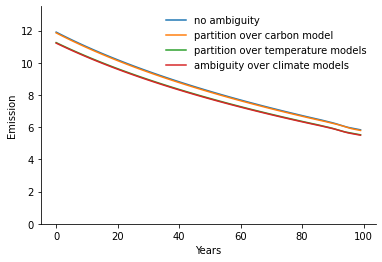

In [703]:
plt.plot(et_neutral, label="no ambiguity")
plt.plot(et_carb, label="partition over carbon model")
plt.plot(et_temp, label="partition over temperature models")
plt.plot(et_avg, label = "ambiguity over climate models")
plt.legend(frameon=False, loc='upper right')
plt.xlabel("Years")
plt.ylabel('Emission')
plt.ylim(0,13.5)
# plt.savefig("../figures/ems_partition.pdf")

In [706]:
ξₐ = 1/10_000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_avg, ems_avg, π_avg = solve_smooth(y_grid, args, tol=1e-6)
args = (δ, η, θtemp_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_temp, ems_temp, π_temp = solve_smooth(y_grid, args, tol=1e-6)
args = (δ, η, θcarb_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_carb, ems_carb, π_carb = solve_smooth(y_grid, args, tol=1e-6)
yt_avg, et_avg, πt_avg = simulate_traj(y_grid, ems_avg, π_avg, θ_list)
yt_temp, et_temp, πt_temp = simulate_traj(y_grid, ems_temp, π_temp, θtemp_list)
yt_carb, et_carb, πt_carb = simulate_traj(y_grid, ems_carb, π_carb, θcarb_list)

episode: 1,	 ode error: 0.0016934891469383843,	 ft error: 0.0014480393752882958
episode: 2,	 ode error: 0.001424571344043859,	 ft error: 0.0012911809460177664
episode: 3,	 ode error: 0.0013182733465200457,	 ft error: 0.0012259957682909043
episode: 4,	 ode error: 0.0012517022445031759,	 ft error: 0.0011819390658632982
episode: 5,	 ode error: 0.0012011983356119006,	 ft error: 0.0011467678203541413
episode: 6,	 ode error: 0.0011599257317909128,	 ft error: 0.0011170014414735063
episode: 7,	 ode error: 0.0011250875846168693,	 ft error: 0.0010899763631497814
episode: 8,	 ode error: 0.0010951120440712103,	 ft error: 0.0010665429523350188
episode: 9,	 ode error: 0.0010689394494998324,	 ft error: 0.0010444849346966621
episode: 10,	 ode error: 0.0010457733793164893,	 ft error: 0.0010244714864097021
episode: 11,	 ode error: 0.001025014458952475,	 ft error: 0.001006175378699931
episode: 12,	 ode error: 0.0010062063911072665,	 ft error: 0.0009893304874441415
episode: 13,	 ode error: 0.0009890000926

episode: 112,	 ode error: 0.0004765326673571009,	 ft error: 0.0004758260527353587
episode: 113,	 ode error: 0.00047404936923583065,	 ft error: 0.0004733529874928824
episode: 114,	 ode error: 0.0004715841258437272,	 ft error: 0.00047089769009092675
episode: 115,	 ode error: 0.00046913658452720885,	 ft error: 0.00046845981231255035
episode: 116,	 ode error: 0.00046670639898932563,	 ft error: 0.0004660390123135382
episode: 117,	 ode error: 0.0004642932292495467,	 ft error: 0.00046363495459374415
episode: 118,	 ode error: 0.0004618967416172877,	 ft error: 0.0004612473099806109
episode: 119,	 ode error: 0.0004595166086775888,	 ft error: 0.0004588757556236769
episode: 120,	 ode error: 0.00045715250928768283,	 ft error: 0.0004565199749984502
episode: 121,	 ode error: 0.0004548041285829101,	 ft error: 0.0004541796579184479
episode: 122,	 ode error: 0.0004524711579907254,	 ft error: 0.00045185450055419685
episode: 123,	 ode error: 0.0004501532952512848,	 ft error: 0.00044954420545703416
episode

episode: 218,	 ode error: 0.0002751580284704333,	 ft error: 0.00027481212929709087
episode: 219,	 ode error: 0.00027369364712971894,	 ft error: 0.0002733498015299966
episode: 220,	 ode error: 0.0002722365439992994,	 ft error: 0.0002718947601440073
episode: 221,	 ode error: 0.00027078670687075536,	 ft error: 0.0002704469926095623
episode: 222,	 ode error: 0.00026934412306606496,	 ft error: 0.0002690064859217171
episode: 223,	 ode error: 0.0002679087794366181,	 ft error: 0.0002675732266000051
episode: 224,	 ode error: 0.0002664806623631111,	 ft error: 0.0002661472006891541
episode: 225,	 ode error: 0.00026505975775640244,	 ft error: 0.0002647283937608445
episode: 226,	 ode error: 0.0002636460510592678,	 ft error: 0.0002633167909162302
episode: 227,	 ode error: 0.00026223952724884923,	 ft error: 0.0002619123767889457
episode: 228,	 ode error: 0.00026084017083991906,	 ft error: 0.00026051513554908406
episode: 229,	 ode error: 0.000259447965888797,	 ft error: 0.0002591250509078001
episode: 

episode: 321,	 ode error: 0.00015883263771687478,	 ft error: 0.00015869277806605797
episode: 322,	 ode error: 0.00015799799869276304,	 ft error: 0.00015785978480173843
episode: 323,	 ode error: 0.00015716804996969284,	 ft error: 0.0001570314725977499
episode: 324,	 ode error: 0.00015634276459909526,	 ft error: 0.00015620781450736051
episode: 325,	 ode error: 0.0001555221157341065,	 ft error: 0.0001553887836854238
episode: 326,	 ode error: 0.00015470607663095007,	 ft error: 0.00015457435339138553
episode: 327,	 ode error: 0.0001538946206504462,	 ft error: 0.0001537644969918049
episode: 328,	 ode error: 0.00015308772125932483,	 ft error: 0.0001529591879586197
episode: 329,	 ode error: 0.00015228535203159197,	 ft error: 0.0001521583998744432
episode: 330,	 ode error: 0.00015148748664972817,	 ft error: 0.00015136210642951084
episode: 331,	 ode error: 0.00015069409890593167,	 ft error: 0.00015057028142718515
episode: 332,	 ode error: 0.00014990516270320614,	 ft error: 0.00014978289878208226

episode: 434,	 ode error: 8.864245615310758e-05,	 ft error: 8.863559708647643e-05
episode: 435,	 ode error: 8.819488771015993e-05,	 ft error: 8.818880211008961e-05
episode: 436,	 ode error: 8.774971002945854e-05,	 ft error: 8.774439223632746e-05
episode: 437,	 ode error: 8.730690907751682e-05,	 ft error: 8.730235346786816e-05
episode: 438,	 ode error: 8.686647091255331e-05,	 ft error: 8.686267186815144e-05
episode: 439,	 ode error: 8.642838168372254e-05,	 ft error: 8.642533364332702e-05
episode: 440,	 ode error: 8.599262763055572e-05,	 ft error: 8.599032508248747e-05
episode: 441,	 ode error: 8.555919508249478e-05,	 ft error: 8.55576325308379e-05
episode: 442,	 ode error: 8.512807045823274e-05,	 ft error: 8.512724242258629e-05
episode: 443,	 ode error: 8.4699240265089e-05,	 ft error: 8.469914131147468e-05
episode: 444,	 ode error: 8.42726910983729e-05,	 ft error: 8.427331583296209e-05
episode: 445,	 ode error: 8.384840964087881e-05,	 ft error: 8.384975269527344e-05
episode: 446,	 ode e

episode: 547,	 ode error: 5.042185967724425e-05,	 ft error: 5.047321123411349e-05
episode: 548,	 ode error: 5.017357434594085e-05,	 ft error: 5.0225227584456876e-05
episode: 549,	 ode error: 4.9926549665668934e-05,	 ft error: 4.9978501547980524e-05
episode: 550,	 ode error: 4.9680778781925096e-05,	 ft error: 4.973302626029112e-05
episode: 551,	 ode error: 4.9436254881565105e-05,	 ft error: 4.94887949189828e-05
episode: 552,	 ode error: 4.919297119244817e-05,	 ft error: 4.9245800786227686e-05
episode: 553,	 ode error: 4.895092098325209e-05,	 ft error: 4.900403713194631e-05
episode: 554,	 ode error: 4.871009756310027e-05,	 ft error: 4.876349728735278e-05
episode: 555,	 ode error: 4.847049428144217e-05,	 ft error: 4.8524174596775715e-05
episode: 556,	 ode error: 4.823210452756027e-05,	 ft error: 4.82860624901003e-05
episode: 557,	 ode error: 4.799492173053618e-05,	 ft error: 4.8049154374799063e-05
episode: 558,	 ode error: 4.775893935877421e-05,	 ft error: 4.7813443755859164e-05
episode: 

episode: 656,	 ode error: 2.9540825219436613e-05,	 ft error: 2.960931084539098e-05
episode: 657,	 ode error: 2.939693269600615e-05,	 ft error: 2.9465444150907537e-05
episode: 658,	 ode error: 2.92537479377634e-05,	 ft error: 2.9322283041990915e-05
episode: 659,	 ode error: 2.9111267304879145e-05,	 ft error: 2.9179823873593896e-05
episode: 660,	 ode error: 2.8969487177813932e-05,	 ft error: 2.9038063035872568e-05
episode: 661,	 ode error: 2.8828403957173974e-05,	 ft error: 2.8896996932190055e-05
episode: 662,	 ode error: 2.8688014063619105e-05,	 ft error: 2.875662198506083e-05
episode: 663,	 ode error: 2.8548313937723133e-05,	 ft error: 2.8616934638232377e-05
episode: 664,	 ode error: 2.840930003984569e-05,	 ft error: 2.847793134572174e-05
episode: 665,	 ode error: 2.8270968850003858e-05,	 ft error: 2.833960861016449e-05
episode: 666,	 ode error: 2.8133316867760393e-05,	 ft error: 2.8201962921983736e-05
episode: 667,	 ode error: 2.7996340612128964e-05,	 ft error: 2.806499079646696e-05
e

episode: 772,	 ode error: 1.6774956826511467e-05,	 ft error: 1.6832264504949384e-05
episode: 773,	 ode error: 1.6693252447906246e-05,	 ft error: 1.6750338905126748e-05
episode: 774,	 ode error: 1.6611942418752012e-05,	 ft error: 1.6668805440517298e-05
episode: 775,	 ode error: 1.6531024795925263e-05,	 ft error: 1.6587662170775008e-05
episode: 776,	 ode error: 1.645049764649497e-05,	 ft error: 1.650690715125173e-05
episode: 777,	 ode error: 1.637035904765514e-05,	 ft error: 1.642653845931874e-05
episode: 778,	 ode error: 1.6290607086644053e-05,	 ft error: 1.6346554175747374e-05
episode: 779,	 ode error: 1.6211239860740236e-05,	 ft error: 1.6266952383066822e-05
episode: 780,	 ode error: 1.6132255477174003e-05,	 ft error: 1.6187731194776865e-05
episode: 781,	 ode error: 1.6053652053008298e-05,	 ft error: 1.610888873133931e-05
episode: 782,	 ode error: 1.5975427715201576e-05,	 ft error: 1.603042310757234e-05
episode: 783,	 ode error: 1.589758060052313e-05,	 ft error: 1.5952332443891493e-05

episode: 881,	 ode error: 9.832952671343597e-06,	 ft error: 9.851910495647006e-06
episode: 882,	 ode error: 9.784649168652197e-06,	 ft error: 9.803106388595051e-06
episode: 883,	 ode error: 9.736577786011733e-06,	 ft error: 9.754531314816925e-06
episode: 884,	 ode error: 9.688737414714137e-06,	 ft error: 9.706184153149278e-06
episode: 885,	 ode error: 9.641126951646147e-06,	 ft error: 9.658063781318543e-06
episode: 886,	 ode error: 9.593745299265894e-06,	 ft error: 9.61016909705829e-06
episode: 887,	 ode error: 9.546591365597584e-06,	 ft error: 9.562498984779419e-06
episode: 888,	 ode error: 9.499664064147907e-06,	 ft error: 9.515052342030466e-06
episode: 889,	 ode error: 9.452962313929243e-06,	 ft error: 9.467828077462197e-06
episode: 890,	 ode error: 9.406485039363923e-06,	 ft error: 9.42082511140585e-06
episode: 891,	 ode error: 9.360231170299732e-06,	 ft error: 9.374042356513623e-06
episode: 892,	 ode error: 9.314199642058486e-06,	 ft error: 9.327478712647016e-06
episode: 893,	 ode

episode: 993,	 ode error: 5.667518744909765e-06,	 ft error: 5.5839396453927215e-06
episode: 994,	 ode error: 5.653866813901034e-06,	 ft error: 5.55488556217935e-06
episode: 995,	 ode error: 5.6402928859492244e-06,	 ft error: 5.525962629912562e-06
episode: 996,	 ode error: 5.62679664589357e-06,	 ft error: 5.4971701612486585e-06
episode: 997,	 ode error: 5.61337778103813e-06,	 ft error: 5.468507461858785e-06
episode: 998,	 ode error: 5.600035981228604e-06,	 ft error: 5.439973885361845e-06
episode: 999,	 ode error: 5.586770937802065e-06,	 ft error: 5.411568725655995e-06
episode: 1000,	 ode error: 5.573582345045269e-06,	 ft error: 5.383291357916968e-06
episode: 1001,	 ode error: 5.5604698980729205e-06,	 ft error: 5.355141124592048e-06
episode: 1002,	 ode error: 5.547433293991242e-06,	 ft error: 5.327117340557982e-06
episode: 1003,	 ode error: 5.534472232621027e-06,	 ft error: 5.299219351754629e-06
episode: 1004,	 ode error: 5.521586415571189e-06,	 ft error: 5.271446532062463e-06
episode: 1

episode: 1101,	 ode error: 4.590440308890973e-06,	 ft error: 3.913226674472081e-06
episode: 1102,	 ode error: 4.583816524552351e-06,	 ft error: 3.902888381727051e-06
episode: 1103,	 ode error: 4.57724928142598e-06,	 ft error: 3.892592971554513e-06
episode: 1104,	 ode error: 4.570738537965991e-06,	 ft error: 3.882340408913054e-06
episode: 1105,	 ode error: 4.564284253158154e-06,	 ft error: 3.8721308112781485e-06
episode: 1106,	 ode error: 4.557886392691699e-06,	 ft error: 3.861964234265029e-06
episode: 1107,	 ode error: 4.5515449263812445e-06,	 ft error: 3.851840776301907e-06
episode: 1108,	 ode error: 4.545259829685333e-06,	 ft error: 3.8417605027069035e-06
episode: 1109,	 ode error: 4.539031082666136e-06,	 ft error: 3.831723566517324e-06
episode: 1110,	 ode error: 4.5328586729367535e-06,	 ft error: 3.821730006521584e-06
episode: 1111,	 ode error: 4.526742590748797e-06,	 ft error: 3.811779896896461e-06
episode: 1112,	 ode error: 4.5206828308022e-06,	 ft error: 3.8018733708687176e-06
ep

episode: 1215,	 ode error: 4.292357956673775e-06,	 ft error: 3.2260326126668888e-06
episode: 1216,	 ode error: 4.299839603076009e-06,	 ft error: 3.244081040604252e-06
episode: 1217,	 ode error: 4.308316604742057e-06,	 ft error: 3.26679235956399e-06
episode: 1218,	 ode error: 4.317997717620103e-06,	 ft error: 3.295806140293789e-06
episode: 1219,	 ode error: 4.329172198937149e-06,	 ft error: 3.333859892873381e-06
episode: 1220,	 ode error: 4.336962917046521e-06,	 ft error: 2.5577744240783593e-06
episode: 1221,	 ode error: 4.314352912678952e-06,	 ft error: 3.228086039667085e-06
episode: 1222,	 ode error: 4.3230664721605454e-06,	 ft error: 3.257900169350662e-06
episode: 1223,	 ode error: 4.33336227422047e-06,	 ft error: 3.2987477313617397e-06
episode: 1224,	 ode error: 4.340432995164601e-06,	 ft error: 2.521168229151216e-06
episode: 1225,	 ode error: 4.317056184165765e-06,	 ft error: 3.199240043115041e-06
episode: 1226,	 ode error: 4.3254924511686665e-06,	 ft error: 3.23476773554654e-06
ep

episode: 1333,	 ode error: 3.7717986603368276e-06,	 ft error: 1.739256670918917e-06
episode: 1334,	 ode error: 3.75954955729739e-06,	 ft error: 1.7340477678068345e-06
episode: 1335,	 ode error: 3.747627630701063e-06,	 ft error: 1.7288522221002116e-06
episode: 1336,	 ode error: 3.736040341931516e-06,	 ft error: 1.7236714645874063e-06
episode: 1337,	 ode error: 3.724791571673748e-06,	 ft error: 1.7185060668251095e-06
episode: 1338,	 ode error: 3.7186530211784125e-06,	 ft error: 2.4616877886939523e-06
episode: 1339,	 ode error: 3.7414218381102635e-06,	 ft error: 1.7061205713833627e-06
episode: 1340,	 ode error: 3.7299934554131534e-06,	 ft error: 1.7010104267495274e-06
episode: 1341,	 ode error: 3.7188658205864985e-06,	 ft error: 1.695913289072315e-06
episode: 1342,	 ode error: 3.7080458438940554e-06,	 ft error: 1.6908306266216755e-06
episode: 1343,	 ode error: 3.697537127043569e-06,	 ft error: 1.6857630171646099e-06
episode: 1344,	 ode error: 3.6921438406978344e-06,	 ft error: 2.434534689

episode: 1435,	 ode error: 3.429402115731389e-06,	 ft error: 1.9678705257680784e-06
episode: 1436,	 ode error: 3.3954552277302985e-06,	 ft error: 1.8609252623591477e-06
episode: 1437,	 ode error: 3.422809260015874e-06,	 ft error: 1.9432744591726023e-06
episode: 1438,	 ode error: 3.4438409271058366e-06,	 ft error: 1.960642182820734e-06
episode: 1439,	 ode error: 3.4094026693817325e-06,	 ft error: 1.8761712778855855e-06
episode: 1440,	 ode error: 3.428211206163434e-06,	 ft error: 1.9563216110731383e-06
episode: 1441,	 ode error: 3.3937555306508727e-06,	 ft error: 1.8151280462124406e-06
episode: 1442,	 ode error: 3.4194799284685507e-06,	 ft error: 1.8852751615163386e-06
episode: 1443,	 ode error: 3.43866064697238e-06,	 ft error: 1.959076826550203e-06
episode: 1444,	 ode error: 3.403798936092706e-06,	 ft error: 1.8189582802359088e-06
episode: 1445,	 ode error: 3.429803935378281e-06,	 ft error: 1.8911878661593644e-06
episode: 1446,	 ode error: 3.44921577076512e-06,	 ft error: 1.964966051005

episode: 1572,	 ode error: 3.4368539750204174e-06,	 ft error: 1.1999582694618058e-06
episode: 1573,	 ode error: 3.444203031641483e-06,	 ft error: 2.0333170260590045e-06
episode: 1574,	 ode error: 3.405592168633355e-06,	 ft error: 1.1755126858257563e-06
episode: 1575,	 ode error: 3.4209160714035935e-06,	 ft error: 1.21461607490575e-06
episode: 1576,	 ode error: 3.4299493113546745e-06,	 ft error: 2.020686606212426e-06
episode: 1577,	 ode error: 3.392285438535449e-06,	 ft error: 1.193462536100883e-06
episode: 1578,	 ode error: 3.401645539009119e-06,	 ft error: 2.010417518120977e-06
episode: 1579,	 ode error: 3.3649833252394346e-06,	 ft error: 1.1772084772959657e-06
episode: 1580,	 ode error: 3.3826523265679414e-06,	 ft error: 1.2234838932950742e-06
episode: 1581,	 ode error: 3.394133719707875e-06,	 ft error: 1.9958893361995966e-06
episode: 1582,	 ode error: 3.3582525000311553e-06,	 ft error: 1.2083479131059598e-06
episode: 1583,	 ode error: 3.37016144672539e-06,	 ft error: 1.9858346759007

episode: 71,	 ode error: 0.0006034548276805786,	 ft error: 0.0006019785915910061
episode: 72,	 ode error: 0.0005998024019135305,	 ft error: 0.0005983550086240362
episode: 73,	 ode error: 0.0005961919216213626,	 ft error: 0.0005947726121237109
episode: 74,	 ode error: 0.0005926223986146932,	 ft error: 0.0005912304411894581
episode: 75,	 ode error: 0.0005890928795599477,	 ft error: 0.0005877275685019455
episode: 76,	 ode error: 0.0005856024444395007,	 ft error: 0.0005842630988170857
episode: 77,	 ode error: 0.0005821502050371439,	 ft error: 0.0005808361674847912
episode: 78,	 ode error: 0.0005787353034568018,	 ft error: 0.0005774459390018907
episode: 79,	 ode error: 0.0005753569106815887,	 ft error: 0.0005740916056077086
episode: 80,	 ode error: 0.0005720142251783759,	 ft error: 0.0005707723859269566
episode: 81,	 ode error: 0.0005687064715517162,	 ft error: 0.0005674875236640181
episode: 82,	 ode error: 0.0005654328992495782,	 ft error: 0.0005642362863499002
episode: 83,	 ode error: 0.0

episode: 224,	 ode error: 0.00026903632810803635,	 ft error: 0.00026869732276275465
episode: 225,	 ode error: 0.0002676079879646104,	 ft error: 0.000267271157328719
episode: 226,	 ode error: 0.0002661868695905433,	 ft error: 0.0002658522187204878
episode: 227,	 ode error: 0.0002647729576976869,	 ft error: 0.0002644404913218953
episode: 228,	 ode error: 0.00026336623654176926,	 ft error: 0.0002630359590597107
episode: 229,	 ode error: 0.0002619666899262535,	 ft error: 0.0002616386054080563
episode: 230,	 ode error: 0.0002605743012067983,	 ft error: 0.0002602484133930559
episode: 231,	 ode error: 0.00025918905329637746,	 ft error: 0.00025886536559908046
episode: 232,	 ode error: 0.0002578109286707781,	 ft error: 0.0002574894441741138
episode: 233,	 ode error: 0.00025643990937472853,	 ft error: 0.0002561206308367379
episode: 234,	 ode error: 0.00025507597702836176,	 ft error: 0.00025475890688293296
episode: 235,	 ode error: 0.0002537191128340992,	 ft error: 0.0002534042531933632
episode: 

episode: 375,	 ode error: 0.00012147702203804103,	 ft error: 0.00012141303199118825
episode: 376,	 ode error: 0.00012085502231056595,	 ft error: 0.00012079222506023354
episode: 377,	 ode error: 0.00012023643908731947,	 ft error: 0.00012017482667971147
episode: 378,	 ode error: 0.0001196212518807916,	 ft error: 0.0001195608164037317
episode: 379,	 ode error: 0.00011900944032626319,	 ft error: 0.00011895017390656237
episode: 380,	 ode error: 0.00011840098418146165,	 ft error: 0.00011834287898376354
episode: 381,	 ode error: 0.00011779586332624791,	 ft error: 0.0001177389115572756
episode: 382,	 ode error: 0.00011719405776224458,	 ft error: 0.00011713825166737024
episode: 383,	 ode error: 0.00011659554761253934,	 ft error: 0.00011654087947579606
episode: 384,	 ode error: 0.00011600031312125169,	 ft error: 0.00011594677526982622
episode: 385,	 ode error: 0.0001154083346531985,	 ft error: 0.0001153559194501617
episode: 386,	 ode error: 0.00011481959269348235,	 ft error: 0.000114768292543444

episode: 535,	 ode error: 5.451313210690979e-05,	 ft error: 5.4563315520552345e-05
episode: 536,	 ode error: 5.424613079079972e-05,	 ft error: 5.429667145219937e-05
episode: 537,	 ode error: 5.39804848054135e-05,	 ft error: 5.40313795020092e-05
episode: 538,	 ode error: 5.371618674923683e-05,	 ft error: 5.376743227619718e-05
episode: 539,	 ode error: 5.3453229265782104e-05,	 ft error: 5.3504822437299336e-05
episode: 540,	 ode error: 5.319160504325168e-05,	 ft error: 5.324354268416524e-05
episode: 541,	 ode error: 5.293130681428273e-05,	 ft error: 5.298358577120188e-05
episode: 542,	 ode error: 5.2672327355570954e-05,	 ft error: 5.272494448489706e-05
episode: 543,	 ode error: 5.241465948761998e-05,	 ft error: 5.246761166498304e-05
episode: 544,	 ode error: 5.215829607443337e-05,	 ft error: 5.221158018156129e-05
episode: 545,	 ode error: 5.190323002316041e-05,	 ft error: 5.195684297097658e-05
episode: 546,	 ode error: 5.1649454283867434e-05,	 ft error: 5.170339298648149e-05
episode: 547,

episode: 689,	 ode error: 2.5782458542442967e-05,	 ft error: 2.5856124122545603e-05
episode: 690,	 ode error: 2.565818777114316e-05,	 ft error: 2.5731825130520525e-05
episode: 691,	 ode error: 2.5534520411449302e-05,	 ft error: 2.5608127397306706e-05
episode: 692,	 ode error: 2.541145341412247e-05,	 ft error: 2.5485027856815095e-05
episode: 693,	 ode error: 2.5288983746526994e-05,	 ft error: 2.5362523491667677e-05
episode: 694,	 ode error: 2.5167108392547743e-05,	 ft error: 2.5240611271857654e-05
episode: 695,	 ode error: 2.5045824352498388e-05,	 ft error: 2.5119288209913642e-05
episode: 696,	 ode error: 2.4925128643032502e-05,	 ft error: 2.4998551310893385e-05
episode: 697,	 ode error: 2.480501829700977e-05,	 ft error: 2.4878397616306946e-05
episode: 698,	 ode error: 2.4685490363432787e-05,	 ft error: 2.475882416738684e-05
episode: 699,	 ode error: 2.456654190733428e-05,	 ft error: 2.463982803307489e-05
episode: 700,	 ode error: 2.4448170009664055e-05,	 ft error: 2.452140629600567e-05

episode: 839,	 ode error: 1.2489900679962546e-05,	 ft error: 1.2533525839709497e-05
episode: 840,	 ode error: 1.2429542482164549e-05,	 ft error: 1.2472768365264416e-05
episode: 841,	 ode error: 1.236947214743045e-05,	 ft error: 1.2412295565556824e-05
episode: 842,	 ode error: 1.2309688293081879e-05,	 ft error: 1.2352106039415871e-05
episode: 843,	 ode error: 1.2250189543466534e-05,	 ft error: 1.229219840489145e-05
episode: 844,	 ode error: 1.2190974529982242e-05,	 ft error: 1.2232571269231903e-05
episode: 845,	 ode error: 1.2132041891015381e-05,	 ft error: 1.2173223251250403e-05
episode: 846,	 ode error: 1.2073390271852627e-05,	 ft error: 1.2114152997793245e-05
episode: 847,	 ode error: 1.2015018324769964e-05,	 ft error: 1.2055359115114203e-05
episode: 848,	 ode error: 1.1956924708856828e-05,	 ft error: 1.1996840263752325e-05
episode: 849,	 ode error: 1.1899108090053078e-05,	 ft error: 1.1938595090392006e-05
episode: 850,	 ode error: 1.1841567141114518e-05,	 ft error: 1.188062224544150

episode: 982,	 ode error: 6.224119285594735e-06,	 ft error: 6.165703595809036e-06
episode: 983,	 ode error: 6.193719350914813e-06,	 ft error: 6.13412634522618e-06
episode: 984,	 ode error: 6.163466531816544e-06,	 ft error: 6.1026864482209104e-06
episode: 985,	 ode error: 6.133360163857252e-06,	 ft error: 6.071383200426106e-06
episode: 986,	 ode error: 6.103399586363488e-06,	 ft error: 6.040215765936349e-06
episode: 987,	 ode error: 6.073584142109027e-06,	 ft error: 6.0091833891754804e-06
episode: 988,	 ode error: 6.0439131774468096e-06,	 ft error: 5.978285294976534e-06
episode: 989,	 ode error: 6.014386042193696e-06,	 ft error: 5.9475207164992145e-06
episode: 990,	 ode error: 5.985002089646833e-06,	 ft error: 5.916888901127959e-06
episode: 991,	 ode error: 5.955760676617378e-06,	 ft error: 5.886389068884834e-06
episode: 992,	 ode error: 5.940225811423177e-06,	 ft error: 5.85602044344639e-06
episode: 993,	 ode error: 5.925926261924036e-06,	 ft error: 5.825782277540012e-06
episode: 994,	

episode: 1145,	 ode error: 4.733417931353137e-06,	 ft error: 3.6713576360402254e-06
episode: 1146,	 ode error: 4.7378718589914616e-06,	 ft error: 3.686559797213644e-06
episode: 1147,	 ode error: 4.7432239710143475e-06,	 ft error: 3.7056379412666227e-06
episode: 1148,	 ode error: 4.749638389533962e-06,	 ft error: 3.729788703270287e-06
episode: 1149,	 ode error: 4.75733515315147e-06,	 ft error: 3.7608593877215086e-06
episode: 1150,	 ode error: 4.766619975853114e-06,	 ft error: 3.8018844813446826e-06
episode: 1151,	 ode error: 4.772841729678364e-06,	 ft error: 3.0356062925377776e-06
episode: 1152,	 ode error: 4.750179891826458e-06,	 ft error: 3.717538601966571e-06
episode: 1153,	 ode error: 4.758371934082163e-06,	 ft error: 3.7585551153351826e-06
episode: 1154,	 ode error: 4.7636217282392805e-06,	 ft error: 3.0043164001939777e-06
episode: 1155,	 ode error: 4.740461410977553e-06,	 ft error: 3.6838281261090495e-06
episode: 1156,	 ode error: 4.748179869314541e-06,	 ft error: 3.72939384159221

episode: 1297,	 ode error: 3.6607256750490792e-06,	 ft error: 1.922502626296174e-06
episode: 1298,	 ode error: 3.65693015076142e-06,	 ft error: 1.9167500921411324e-06
episode: 1299,	 ode error: 3.6531581870460363e-06,	 ft error: 1.9110146418782614e-06
episode: 1300,	 ode error: 3.6494094954367916e-06,	 ft error: 1.9052962256863037e-06
episode: 1301,	 ode error: 3.645683801453052e-06,	 ft error: 1.8995947935242694e-06
episode: 1302,	 ode error: 3.641980843620003e-06,	 ft error: 1.8939102958368907e-06
episode: 1303,	 ode error: 3.6383003726110424e-06,	 ft error: 1.8882426835546233e-06
episode: 1304,	 ode error: 3.6346421504400536e-06,	 ft error: 1.8825919068677737e-06
episode: 1305,	 ode error: 3.6310059496294945e-06,	 ft error: 1.8769579161632504e-06
episode: 1306,	 ode error: 3.627391552516834e-06,	 ft error: 1.8713406626259348e-06
episode: 1307,	 ode error: 3.623798750618235e-06,	 ft error: 1.8657400976951344e-06
episode: 1308,	 ode error: 3.6202273439876797e-06,	 ft error: 1.86015617

episode: 1449,	 ode error: 3.504196648769411e-06,	 ft error: 1.192943470060733e-06
episode: 1450,	 ode error: 3.498393347103803e-06,	 ft error: 1.939788495906869e-06
episode: 1451,	 ode error: 3.520538213438952e-06,	 ft error: 1.1837301921076757e-06
episode: 1452,	 ode error: 3.509534149453194e-06,	 ft error: 1.1801857076216653e-06
episode: 1453,	 ode error: 3.503658179924594e-06,	 ft error: 1.9603926149543613e-06
episode: 1454,	 ode error: 3.526887215479801e-06,	 ft error: 1.17097400179067e-06
episode: 1455,	 ode error: 3.5155763169275535e-06,	 ft error: 1.1674673353057052e-06
episode: 1456,	 ode error: 3.504555933951149e-06,	 ft error: 1.1639688233163379e-06
episode: 1457,	 ode error: 3.498626019433611e-06,	 ft error: 1.9340150435078383e-06
episode: 1458,	 ode error: 3.5214827844386024e-06,	 ft error: 1.1548789638609245e-06
episode: 1459,	 ode error: 3.510226742416589e-06,	 ft error: 1.1514201351744968e-06
episode: 1460,	 ode error: 3.4992751188978933e-06,	 ft error: 1.14796941872580

episode: 96,	 ode error: 0.0005313128818720706,	 ft error: 0.0005303496051126238
episode: 97,	 ode error: 0.0005284497432862968,	 ft error: 0.0005275021823030723
episode: 98,	 ode error: 0.0005256113701807005,	 ft error: 0.000524679151310085
episode: 99,	 ode error: 0.0005227972849819388,	 ft error: 0.0005218800416578392
episode: 100,	 ode error: 0.0005200070201011531,	 ft error: 0.000519104392519403
episode: 101,	 ode error: 0.0005172401175046145,	 ft error: 0.00051635175231695
episode: 102,	 ode error: 0.0005144961283177426,	 ft error: 0.0005136216783547162
episode: 103,	 ode error: 0.0005117746124612783,	 ft error: 0.0005109137364827168
episode: 104,	 ode error: 0.0005090751383186493,	 ft error: 0.0005082275007909736
episode: 105,	 ode error: 0.0005063972824332845,	 ft error: 0.0005055625533324087
episode: 106,	 ode error: 0.0005037406292347277,	 ft error: 0.0005029184838735319
episode: 107,	 ode error: 0.0005011047707925002,	 ft error: 0.0005002948896717929
episode: 108,	 ode error

episode: 246,	 ode error: 0.0002446510746425441,	 ft error: 0.00024435299376064185
episode: 247,	 ode error: 0.00024336154004158468,	 ft error: 0.00024306575771163946
episode: 248,	 ode error: 0.0002420788403075518,	 ft error: 0.00024178535386979821
episode: 249,	 ode error: 0.00024080295142849743,	 ft error: 0.00024051175797540347
episode: 250,	 ode error: 0.00023953384910940247,	 ft error: 0.00023924494549143935
episode: 251,	 ode error: 0.00023827150878131815,	 ft error: 0.0002379848916109669
episode: 252,	 ode error: 0.00023701590561042512,	 ft error: 0.00023673157126794891
episode: 253,	 ode error: 0.00023576701450707177,	 ft error: 0.0002354849591456228
episode: 254,	 ode error: 0.00023452481013473984,	 ft error: 0.00023424502968545186
episode: 255,	 ode error: 0.00023328926691906164,	 ft error: 0.00023301175709644628
episode: 256,	 ode error: 0.00023206035905658088,	 ft error: 0.00023178511536358268
episode: 257,	 ode error: 0.00023083806052363962,	 ft error: 0.00023056507825687

episode: 389,	 ode error: 0.00011659761752151197,	 ft error: 0.00011654977827992019
episode: 390,	 ode error: 0.000116011067905548,	 ft error: 0.00011596435503193984
episode: 391,	 ode error: 0.000115427690316456,	 ft error: 0.00011538209638862577
episode: 392,	 ode error: 0.00011484746587008541,	 ft error: 0.00011480298350715716
episode: 393,	 ode error: 0.00011427037579944145,	 ft error: 0.00011422699766304445
episode: 394,	 ode error: 0.00011369640145423448,	 ft error: 0.00011365412024770076
episode: 395,	 ode error: 0.00011312552430038051,	 ft error: 0.00011308433276777108
episode: 396,	 ode error: 0.00011255772591953314,	 ft error: 0.00011251761684820857
episode: 397,	 ode error: 0.00011199298800857707,	 ft error: 0.0001119539542237628
episode: 398,	 ode error: 0.00011143129237915664,	 ft error: 0.0001113933267534358
episode: 399,	 ode error: 0.0001108726209571437,	 ft error: 0.00011083571639899463
episode: 400,	 ode error: 0.00011031695578213503,	 ft error: 0.00011028110524516355

episode: 555,	 ode error: 5.1563213673833964e-05,	 ft error: 5.162742647869811e-05
episode: 556,	 ode error: 5.1315531864153975e-05,	 ft error: 5.1380090818342605e-05
episode: 557,	 ode error: 5.1069084709470716e-05,	 ft error: 5.1133986982837554e-05
episode: 558,	 ode error: 5.082386559398513e-05,	 ft error: 5.0889108378499026e-05
episode: 559,	 ode error: 5.057986794136757e-05,	 ft error: 5.0645448418628246e-05
episode: 560,	 ode error: 5.033708521442375e-05,	 ft error: 5.040300058563781e-05
episode: 561,	 ode error: 5.0095510914734565e-05,	 ft error: 5.016175841081327e-05
episode: 562,	 ode error: 4.9855138582632365e-05,	 ft error: 4.992171540809295e-05
episode: 563,	 ode error: 4.961596179668443e-05,	 ft error: 4.9682865200471424e-05
episode: 564,	 ode error: 4.9377974173502796e-05,	 ft error: 4.9445201428498696e-05
episode: 565,	 ode error: 4.914116936757134e-05,	 ft error: 4.920871774213853e-05
episode: 566,	 ode error: 4.890554107107956e-05,	 ft error: 4.897340780830872e-05
epis

episode: 699,	 ode error: 2.5952972346972997e-05,	 ft error: 2.6042048998781153e-05
episode: 700,	 ode error: 2.583040691532567e-05,	 ft error: 2.5919496420117226e-05
episode: 701,	 ode error: 2.5708427517908057e-05,	 ft error: 2.5797527703763645e-05
episode: 702,	 ode error: 2.5587031230103014e-05,	 ft error: 2.5676139922617414e-05
episode: 703,	 ode error: 2.546621514304306e-05,	 ft error: 2.5555330161117218e-05
episode: 704,	 ode error: 2.5345976363556812e-05,	 ft error: 2.543509552518919e-05
episode: 705,	 ode error: 2.5226312014036073e-05,	 ft error: 2.5315433129433074e-05
episode: 706,	 ode error: 2.5107219232419994e-05,	 ft error: 2.5196340104639375e-05
episode: 707,	 ode error: 2.498869517196349e-05,	 ft error: 2.5077813613471243e-05
episode: 708,	 ode error: 2.487073700130761e-05,	 ft error: 2.4959850805384803e-05
episode: 709,	 ode error: 2.475334190426919e-05,	 ft error: 2.484244886783819e-05
episode: 710,	 ode error: 2.4636507079798154e-05,	 ft error: 2.4725604992846078e-05

episode: 864,	 ode error: 1.190233020464742e-05,	 ft error: 1.1955488210951826e-05
episode: 865,	 ode error: 1.184620169105094e-05,	 ft error: 1.1898793857550069e-05
episode: 866,	 ode error: 1.179033638078089e-05,	 ft error: 1.184235581976519e-05
episode: 867,	 ode error: 1.1734733041789602e-05,	 ft error: 1.1786172761744467e-05
episode: 868,	 ode error: 1.1679390448428046e-05,	 ft error: 1.1730243365791945e-05
episode: 869,	 ode error: 1.162430738135226e-05,	 ft error: 1.167456633995497e-05
episode: 870,	 ode error: 1.1569482627631121e-05,	 ft error: 1.1619140353746893e-05
episode: 871,	 ode error: 1.15149149806672e-05,	 ft error: 1.156396411068165e-05
episode: 872,	 ode error: 1.146060324008324e-05,	 ft error: 1.1509036323895105e-05
episode: 873,	 ode error: 1.1406546211875147e-05,	 ft error: 1.1454355666508839e-05
episode: 874,	 ode error: 1.1352742708214871e-05,	 ft error: 1.1399920869399154e-05
episode: 875,	 ode error: 1.1299191547470364e-05,	 ft error: 1.1345730648384955e-05
ep

episode: 1019,	 ode error: 6.217021248215628e-06,	 ft error: 5.356649177441312e-06
episode: 1020,	 ode error: 6.208079451115235e-06,	 ft error: 5.315751592747479e-06
episode: 1021,	 ode error: 6.199479272621725e-06,	 ft error: 5.274029005834328e-06
episode: 1022,	 ode error: 6.1912439699709164e-06,	 ft error: 5.231359878783241e-06
episode: 1023,	 ode error: 6.183400181364817e-06,	 ft error: 5.187600638084655e-06
episode: 1024,	 ode error: 6.175978588720502e-06,	 ft error: 5.142578318022747e-06
episode: 1025,	 ode error: 6.169014811001155e-06,	 ft error: 5.0960821572817085e-06
episode: 1026,	 ode error: 6.162550558992371e-06,	 ft error: 5.047853562737774e-06
episode: 1027,	 ode error: 6.156635123413497e-06,	 ft error: 4.997568539485964e-06
episode: 1028,	 ode error: 6.151327419690619e-06,	 ft error: 4.944817235119636e-06
episode: 1029,	 ode error: 6.146698721907703e-06,	 ft error: 4.889068301155061e-06
episode: 1030,	 ode error: 6.142836557618476e-06,	 ft error: 4.82962232532802e-06
epi

episode: 1158,	 ode error: 4.2392063232462055e-06,	 ft error: 3.9397031022005615e-06
episode: 1159,	 ode error: 4.211806540157365e-06,	 ft error: 3.949875832173766e-06
episode: 1160,	 ode error: 4.184275569264252e-06,	 ft error: 3.961717391157138e-06
episode: 1161,	 ode error: 4.161067408067819e-06,	 ft error: 2.8453875829346593e-06
episode: 1162,	 ode error: 4.164836896990642e-06,	 ft error: 3.8692851528817264e-06
episode: 1163,	 ode error: 4.139573710616946e-06,	 ft error: 3.8732891604239174e-06
episode: 1164,	 ode error: 4.114315280811056e-06,	 ft error: 3.878424118831473e-06
episode: 1165,	 ode error: 4.089053124155175e-06,	 ft error: 3.883440483354317e-06
episode: 1166,	 ode error: 4.068254241633472e-06,	 ft error: 2.7646889456250934e-06
episode: 1167,	 ode error: 4.074390567483264e-06,	 ft error: 3.7785603909888206e-06
episode: 1168,	 ode error: 4.0518092106324e-06,	 ft error: 3.7757450403278865e-06
episode: 1169,	 ode error: 4.029366533460821e-06,	 ft error: 3.7737924185367775e-

episode: 1313,	 ode error: 3.154241186742186e-06,	 ft error: 1.9038788937516169e-06
episode: 1314,	 ode error: 3.1635014353652183e-06,	 ft error: 1.8981885292410072e-06
episode: 1315,	 ode error: 3.1722838770548004e-06,	 ft error: 1.892516941943978e-06
episode: 1316,	 ode error: 3.1761939747946936e-06,	 ft error: 2.239095154935959e-06
episode: 1317,	 ode error: 3.1536866864722126e-06,	 ft error: 1.8835446057019478e-06
episode: 1318,	 ode error: 3.1622889690792098e-06,	 ft error: 1.8779067743659081e-06
episode: 1319,	 ode error: 3.1704594784137978e-06,	 ft error: 1.8722922425981614e-06
episode: 1320,	 ode error: 3.1782035748986943e-06,	 ft error: 1.8666964921610722e-06
episode: 1321,	 ode error: 3.181151654382678e-06,	 ft error: 2.204297630282552e-06
episode: 1322,	 ode error: 3.1578595754303083e-06,	 ft error: 1.8578621900286474e-06
episode: 1323,	 ode error: 3.165566794900308e-06,	 ft error: 1.8523005742195528e-06
episode: 1324,	 ode error: 3.1728889536783173e-06,	 ft error: 1.8467613

episode: 1472,	 ode error: 2.793552192041724e-06,	 ft error: 1.0880661727163954e-06
episode: 1473,	 ode error: 2.793510484463903e-06,	 ft error: 1.0854557211161429e-06
episode: 1474,	 ode error: 2.793457136135815e-06,	 ft error: 1.0828363161107433e-06
episode: 1475,	 ode error: 2.79339250007797e-06,	 ft error: 1.0802083157818165e-06
episode: 1476,	 ode error: 2.7933169160479954e-06,	 ft error: 1.077572048709119e-06
episode: 1477,	 ode error: 2.7932307103218984e-06,	 ft error: 1.0749278399451354e-06
episode: 1478,	 ode error: 2.793134196468457e-06,	 ft error: 1.0722760086442906e-06
episode: 1479,	 ode error: 2.7930276759289435e-06,	 ft error: 1.0696168558273675e-06
episode: 1480,	 ode error: 2.792911438167557e-06,	 ft error: 1.0669506802600075e-06
episode: 1481,	 ode error: 2.792785761418764e-06,	 ft error: 1.0642777765792108e-06
episode: 1482,	 ode error: 2.7926509132013733e-06,	 ft error: 1.0615984153324507e-06
episode: 1483,	 ode error: 2.79250715017412e-06,	 ft error: 1.058912868940

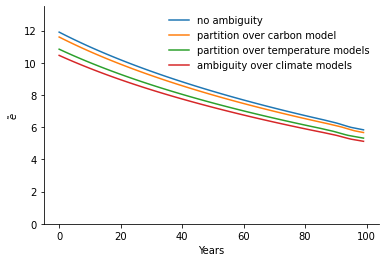

In [709]:
plt.plot(et_neutral, label="no ambiguity")
plt.plot(et_carb, label="partition over carbon model")
plt.plot(et_temp, label="partition over temperature models")
plt.plot(et_avg, label = "ambiguity over climate models")
plt.legend(frameon=False, loc='upper right')
plt.xlabel("Years")
plt.ylabel('$\\tilde e$')
plt.ylim(0,13.5)
# plt.savefig("../figures/ems_partition.pdf")